# SAX circuit simulator

[SAX](https://flaport.github.io/sax/) is a circuit solver written in JAX, writing your component models in SAX enables you not only to get the function values but the gradients, this is useful for circuit optimization.

This tutorial has been adapted from SAX tutorial.

Note that SAX does not work on Windows, so if you use windows you'll need to run from [WSL](https://docs.microsoft.com/en-us/windows/wsl/) or using docker.

You can install sax with pip

```
! pip install sax
```

In [1]:
import gdsfactory as gf
import gdsfactory.simulation.sax as gs
import gdsfactory.simulation.modes as gm
import sax

2022-03-01 18:43:15.005 | INFO     | gdsfactory.config:<module>:52 - Load '/home/runner/work/gdsfactory/gdsfactory/gdsfactory' 4.2.16


2022-03-01 18:43:16.843 | INFO     | gdsfactory.simulation.gmeep:<module>:28 - Meep '1.22.0' installed at ['/usr/share/miniconda/envs/anaconda-client-env/lib/python3.9/site-packages/meep']


Using MPI version 3.1, 1 processes


## Scatter *dictionaries*

The core datastructure for specifying scatter parameters in SAX is a dictionary... more specifically a dictionary which maps a port combination (2-tuple) to a scatter parameter (or an array of scatter parameters when considering multiple wavelengths for example). Such a specific dictionary mapping is called ann `SDict` in SAX (`SDict ≈ Dict[Tuple[str,str], float]`).

Dictionaries are in fact much better suited for characterizing S-parameters than, say, (jax-)numpy arrays due to the inherent sparse nature of scatter parameters. Moreover, dictonaries allow for string indexing, which makes them much more pleasant to use in this context.

```
o2            o3 
   \        /
    ========
   /        \
o1            o4 
```

In [2]:
coupling = 0.5
kappa = coupling ** 0.5
tau = (1 - coupling) ** 0.5
coupler_dict = {
    ("o1", "o4"): tau,
    ("o4", "o1"): tau,
    ("o1", "o3"): 1j * kappa,
    ("o3", "o1"): 1j * kappa,
    ("o2", "o4"): 1j * kappa,
    ("o4", "o2"): 1j * kappa,
    ("o2", "o3"): tau,
    ("o3", "o2"): tau,
}
coupler_dict

{('o1', 'o4'): 0.7071067811865476,
 ('o4', 'o1'): 0.7071067811865476,
 ('o1', 'o3'): 0.7071067811865476j,
 ('o3', 'o1'): 0.7071067811865476j,
 ('o2', 'o4'): 0.7071067811865476j,
 ('o4', 'o2'): 0.7071067811865476j,
 ('o2', 'o3'): 0.7071067811865476,
 ('o3', 'o2'): 0.7071067811865476}

 it can still be tedious to specify every port in the circuit manually. SAX therefore offers the `reciprocal` function, which auto-fills the reverse connection if the forward connection exist. For example:

In [3]:
coupler_dict = sax.reciprocal(
    {
        ("o1", "o4"): tau,
        ("o1", "o3"): 1j * kappa,
        ("o2", "o4"): 1j * kappa,
        ("o2", "o3"): tau,
    }
)

coupler_dict

{('o1', 'o4'): 0.7071067811865476,
 ('o1', 'o3'): 0.7071067811865476j,
 ('o2', 'o4'): 0.7071067811865476j,
 ('o2', 'o3'): 0.7071067811865476,
 ('o4', 'o1'): 0.7071067811865476,
 ('o3', 'o1'): 0.7071067811865476j,
 ('o4', 'o2'): 0.7071067811865476j,
 ('o3', 'o2'): 0.7071067811865476}

## Parametrized Models

Constructing such an `SDict` is easy, however, usually we're more interested in having parametrized models for our components. To parametrize the coupler `SDict`, just wrap it in a function to obtain a SAX `Model`, which is a keyword-only function mapping to an `SDict`:

In [4]:
def coupler(coupling=0.5) -> sax.SDict:
    kappa = coupling ** 0.5
    tau = (1 - coupling) ** 0.5
    coupler_dict = sax.reciprocal(
        {
        ("o1", "o4"): tau,
        ("o1", "o3"): 1j * kappa,
        ("o2", "o4"): 1j * kappa,
        ("o2", "o3"): tau,
        }
    )
    return coupler_dict


coupler(coupling=0.3)

{('o1', 'o4'): 0.8366600265340756,
 ('o1', 'o3'): 0.5477225575051661j,
 ('o2', 'o4'): 0.5477225575051661j,
 ('o2', 'o3'): 0.8366600265340756,
 ('o4', 'o1'): 0.8366600265340756,
 ('o3', 'o1'): 0.5477225575051661j,
 ('o4', 'o2'): 0.5477225575051661j,
 ('o3', 'o2'): 0.8366600265340756}

In [5]:
def waveguide(wl=1.55, wl0=1.55, neff=2.34, ng=3.4, length=10.0, loss=0.0) -> sax.SDict:
    dwl = wl - wl0
    dneff_dwl = (ng - neff) / wl0
    neff = neff - dwl * dneff_dwl
    phase = 2 * jnp.pi * neff * length / wl
    transmission = 10 ** (-loss * length / 20) * jnp.exp(1j * phase)
    sdict = sax.reciprocal(
        {
            ("o1", "o2"): transmission,
        }
    )
    return sdict

## Component Models

### Waveguide model

You can create a dispersive waveguide model in SAX.

Lets compute the effective index `neff` and group index `ng` for a 1550nm 500nm straight waveguide

In [6]:
m = gm.find_mode_dispersion(wavelength=1.55)
print(m.neff, m.ng)

2.3638584286954814 4.251242165908622


In [7]:
straight_sc = gf.partial(gs.models.straight, neff=m.neff, ng=m.ng)

/usr/share/miniconda/envs/anaconda-client-env/lib/python3.9/site-packages/jax/_src/numpy/lax_numpy.py:3690: UserWarning: Explicitly requested dtype <class 'complex'> requested in asarray is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "asarray")


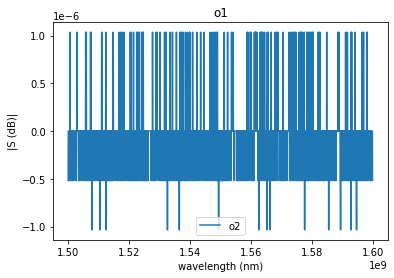

<AxesSubplot:title={'center':'o1'}, xlabel='wavelength (nm)', ylabel='|S (dB)|'>

In [8]:
gs.plot_model(straight_sc)

/usr/share/miniconda/envs/anaconda-client-env/lib/python3.9/site-packages/jax/_src/numpy/lax_numpy.py:3690: UserWarning: Explicitly requested dtype <class 'complex'> requested in asarray is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "asarray")


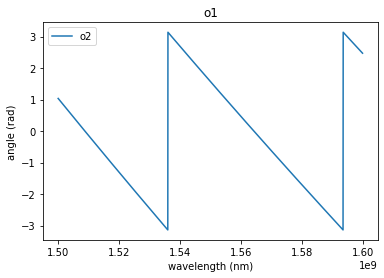

<AxesSubplot:title={'center':'o1'}, xlabel='wavelength (nm)', ylabel='angle (rad)'>

In [9]:
gs.plot_model(straight_sc, phase=True)

### Coupler model

In [10]:
gm.find_coupling_vs_gap?

In [11]:
df = gm.find_coupling_vs_gap()
df

  0%|          | 0/12 [00:00<?, ?it/s]

100%|██████████| 12/12 [00:00<00:00, 487.43it/s]

,gap,ne,no,lc,dn
0,0.200000,2.457894,2.437607,38.201198,0.020287
1,0.218182,2.459028,2.441121,43.278893,0.017907
2,0.236364,2.452195,2.437659,53.318206,0.014535
3,0.254545,2.451946,2.439549,62.514018,0.012397
4,0.272727,2.451248,2.441058,76.053858,0.010190
5,0.290909,2.451491,2.442325,84.553535,0.009166
6,0.309091,2.449447,2.441517,97.723696,0.007931
7,0.327273,2.447256,2.440698,118.168160,0.006558
8,0.345455,2.451715,2.446248,141.751936,0.005467
9,0.363636,2.451128,2.446210,157.608710,0.004917


For a 200nm gap the effective index difference `dn` is `0.02`, which means that there is 100% power coupling over 38.2um

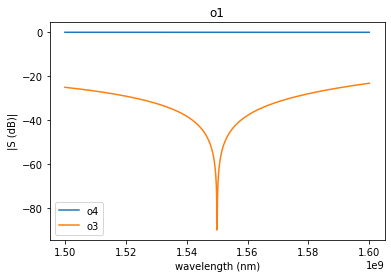

<AxesSubplot:title={'center':'o1'}, xlabel='wavelength (nm)', ylabel='|S (dB)|'>

In [12]:
coupler_sc = gf.partial(gs.models.coupler, dn=0.02, length=0, coupling0=0)
gs.plot_model(coupler_sc)

If we ignore the coupling from the bend `coupling0 = 0` we know that for a 3dB coupling we need half of the `lc` length, which is the length needed to coupler `100%` of power.

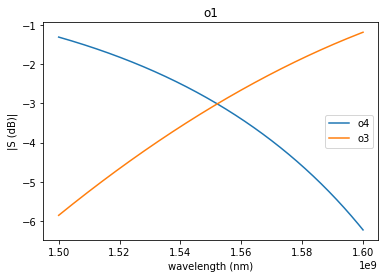

<AxesSubplot:title={'center':'o1'}, xlabel='wavelength (nm)', ylabel='|S (dB)|'>

In [13]:
coupler_sc = gf.partial(gs.models.coupler, dn=0.02, length=38.2/2, coupling0=0)
gs.plot_model(coupler_sc)

### FDTD Sparameters model

You can also fit a model from Sparameter FDTD simulation data.

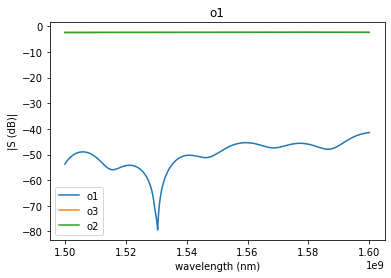

<AxesSubplot:title={'center':'o1'}, xlabel='wavelength (nm)', ylabel='|S (dB)|'>

In [14]:
from gdsfactory.simulation.get_sparameters_path import get_sparameters_path_lumerical

filepath = get_sparameters_path_lumerical(gf.c.mmi1x2)
mmi1x2 = gf.partial(gs.read.sdict_from_csv, filepath=filepath)
gs.plot_model(mmi1x2)

## Circuit Models

You can combine component models into a circuit using `sax.circuit`, which basically creates a new `Model` function:

Lets define a [MZI interferometer](https://en.wikipedia.org/wiki/Mach%E2%80%93Zehnder_interferometer)

```
           _________
          |  top    |
          |         |
    lft===|         |===rgt
          |         |
          |_________|
             bot
             
               o1    top   o2
                 ----------
o2            o3           o2            o3 
   \        /                 \        /
    ========                   ========
   /        \                 /        \
o1     lft    04           o1    rgt     04 
                 ----------
               o1   bot    o2
```

In [15]:
waveguide = straight_sc
coupler = coupler_sc

mzi = sax.circuit(
    instances={
        "lft": coupler,
        "top": waveguide,
        "bot": waveguide,
        "rgt": coupler,
    },
    connections={
        "lft,o4": "bot,o1",
        "bot,o2": "rgt,o1",
        "lft,o3": "top,o1",
        "top,o2": "rgt,o2",
    },
    ports={
        "o1": "lft,o1",
        "o2": "lft,o2",
        "o4": "rgt,o4",
        "o3": "rgt,o3",
    },
)

The `circuit` function just creates a similar function as we created for the waveguide and the coupler, but in stead of taking parameters directly it takes parameter *dictionaries* for each of the instances in the circuit. The keys in these parameter dictionaries should correspond to the keyword arguments of each individual subcomponent. 

Let's now do a simulation for the MZI we just constructed:

In [16]:
%time mzi()

/usr/share/miniconda/envs/anaconda-client-env/lib/python3.9/site-packages/jax/_src/numpy/lax_numpy.py:3690: UserWarning: Explicitly requested dtype <class 'complex'> requested in asarray is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "asarray")


CPU times: user 2.24 s, sys: 31.6 ms, total: 2.27 s
Wall time: 2.27 s


{('o2', 'o2'): 0j,
 ('o2', 'o1'): 0j,
 ('o1', 'o2'): 0j,
 ('o1', 'o1'): 0j,
 ('o3', 'o3'): 0j,
 ('o3', 'o4'): 0j,
 ('o3', 'o2'): -9.807199239730835e-05+0.02229j,
 ('o3', 'o1'): 0.99974+0.0044j,
 ('o4', 'o3'): 0j,
 ('o4', 'o4'): 0j,
 ('o4', 'o2'): 0.99974+0.0044j,
 ('o4', 'o1'): -9.807199239730835e-05+0.02229j,
 ('o2', 'o3'): -9.807199239730835e-05+0.02229j,
 ('o2', 'o4'): 0.99974+0.0044j,
 ('o1', 'o3'): 0.99974+0.0044j,
 ('o1', 'o4'): -9.807199239730835e-05+0.02229j}

In [17]:
import jax
import jax.example_libraries.optimizers as opt
import jax.numpy as jnp
import matplotlib.pyplot as plt  # plotting

mzi2 = jax.jit(mzi)

In [18]:
%time mzi2()

CPU times: user 3.38 s, sys: 51.6 ms, total: 3.43 s
Wall time: 3.4 s


{('o1', 'o1'): 0j,
 ('o1', 'o2'): 0j,
 ('o1', 'o3'): 0.99974+0.0044j,
 ('o1', 'o4'): -9.807199239730835e-05+0.02229j,
 ('o2', 'o1'): 0j,
 ('o2', 'o2'): 0j,
 ('o2', 'o3'): -9.807199239730835e-05+0.02229j,
 ('o2', 'o4'): 0.99974+0.0044j,
 ('o3', 'o1'): 0.99974+0.0044j,
 ('o3', 'o2'): -9.807199239730835e-05+0.02229j,
 ('o3', 'o3'): 0j,
 ('o3', 'o4'): 0j,
 ('o4', 'o1'): -9.807199239730835e-05+0.02229j,
 ('o4', 'o2'): 0.99974+0.0044j,
 ('o4', 'o3'): 0j,
 ('o4', 'o4'): 0j}

In [19]:
mzi(top={"length": 25.0}, btm={"length": 15.0})

{('o2', 'o2'): 0j,
 ('o2', 'o1'): 0j,
 ('o1', 'o2'): 0j,
 ('o1', 'o1'): 0j,
 ('o3', 'o3'): 0j,
 ('o3', 'o4'): 0j,
 ('o3', 'o2'): 0.35958-0.12346j,
 ('o3', 'o1'): 0.85721-0.34735j,
 ('o4', 'o3'): 0j,
 ('o4', 'o4'): 0j,
 ('o4', 'o2'): 0.85721-0.34735j,
 ('o4', 'o1'): -0.34409+0.16169j,
 ('o2', 'o3'): 0.35958-0.12346j,
 ('o2', 'o4'): 0.85721-0.34735j,
 ('o1', 'o3'): 0.85721-0.34735j,
 ('o1', 'o4'): -0.34409+0.16169j}

In [20]:
wl = jnp.linspace(1.51, 1.59, 1000)
%time S = mzi(wl=wl, top={"length": 25.0}, btm={"length": 15.0})

/usr/share/miniconda/envs/anaconda-client-env/lib/python3.9/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/usr/share/miniconda/envs/anaconda-client-env/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


CPU times: user 2.61 s, sys: 3.71 ms, total: 2.62 s
Wall time: 2.61 s


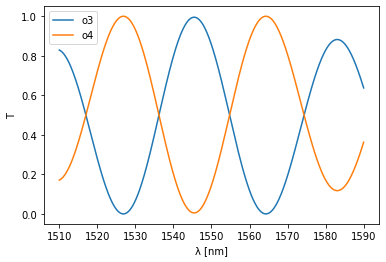

In [21]:
plt.plot(wl * 1e3, abs(S["o1", "o3"]) ** 2, label='o3')
plt.plot(wl * 1e3, abs(S["o1", "o4"]) ** 2, label='o4')
plt.ylim(-0.05, 1.05)
plt.xlabel("λ [nm]")
plt.ylabel("T")
plt.ylim(-0.05, 1.05)
plt.legend()
plt.show()

## Optimization

You can optimize an MZI to get T=0 at 1550nm.
To do this, you need to define a loss function for the circuit at 1550nm.
This function should take the parameters that you want to optimize as positional arguments:

In [22]:
@jax.jit
def loss(delta_length):
    S = mzi(wl=1.55, top={"length": 15.0 + delta_length}, btm={"length": 15.0})
    return (abs(S["o1", "o4"]) ** 2).mean()

In [23]:
%time loss(10.0)

/usr/share/miniconda/envs/anaconda-client-env/lib/python3.9/site-packages/jax/_src/numpy/lax_numpy.py:3690: UserWarning: Explicitly requested dtype <class 'complex'> requested in asarray is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "asarray")


CPU times: user 3.59 s, sys: 11.5 ms, total: 3.6 s
Wall time: 3.56 s


0.14454

You can use this loss function to define a grad function which works on the parameters of the loss function:

In [24]:
grad = jax.jit(
    jax.grad(
        loss,
        argnums=0,  # JAX gradient function for the first positional argument, jitted
    )
)

Next, you need to define a JAX optimizer, which on its own is nothing more than three more functions:  

1. an initialization function with which to initialize the optimizer state
2. an update function which will update the optimizer state (and with it the model parameters). 
3. a function with the model parameters given the optimizer state.

In [25]:
initial_delta_length = 10.0
optim_init, optim_update, optim_params = opt.adam(step_size=0.1)
optim_state = optim_init(initial_delta_length)

In [26]:
def train_step(step, optim_state):
    settings = optim_params(optim_state)
    lossvalue = loss(settings)
    gradvalue = grad(settings)
    optim_state = optim_update(step, gradvalue, optim_state)
    return lossvalue, optim_state

In [27]:
import tqdm

range_ = tqdm.trange(300)
for step in range_:
    lossvalue, optim_state = train_step(step, optim_state)
    range_.set_postfix(loss=f"{lossvalue:.6f}")

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:04<?, ?it/s, loss=0.144537]

  0%|          | 1/300 [00:04<21:57,  4.41s/it, loss=0.144537]

  0%|          | 1/300 [00:12<21:57,  4.41s/it, loss=0.008521]

  1%|          | 2/300 [00:12<31:29,  6.34s/it, loss=0.008521]

  1%|          | 2/300 [00:12<31:29,  6.34s/it, loss=0.095274]

  1%|          | 2/300 [00:12<31:29,  6.34s/it, loss=0.063922]

  1%|          | 2/300 [00:12<31:29,  6.34s/it, loss=0.007386]

  1%|          | 2/300 [00:12<31:29,  6.34s/it, loss=0.010611]

  1%|          | 2/300 [00:12<31:29,  6.34s/it, loss=0.044013]

  1%|          | 2/300 [00:12<31:29,  6.34s/it, loss=0.045545]

  1%|          | 2/300 [00:12<31:29,  6.34s/it, loss=0.019057]

  3%|▎         | 9/300 [00:12<04:32,  1.07it/s, loss=0.019057]

  3%|▎         | 9/300 [00:12<04:32,  1.07it/s, loss=0.000873]

  3%|▎         | 9/300 [00:12<04:32,  1.07it/s, loss=0.009007]

  3%|▎         | 9/300 [00:12<04:32,  1.07it/s, loss=0.025268]

  3%|▎         | 9/300 [00:12<04:32,  1.07it/s, loss=0.026025]

  3%|▎         | 9/300 [00:12<04:32,  1.07it/s, loss=0.012185]

  3%|▎         | 9/300 [00:12<04:32,  1.07it/s, loss=0.001130]

  5%|▌         | 15/300 [00:12<02:12,  2.15it/s, loss=0.001130]

  5%|▌         | 15/300 [00:12<02:12,  2.15it/s, loss=0.003934]

  5%|▌         | 15/300 [00:12<02:12,  2.15it/s, loss=0.013488]

  5%|▌         | 15/300 [00:12<02:12,  2.15it/s, loss=0.016100]

  5%|▌         | 15/300 [00:12<02:12,  2.15it/s, loss=0.009127]

  5%|▌         | 15/300 [00:12<02:12,  2.15it/s, loss=0.001556]

  5%|▌         | 15/300 [00:12<02:12,  2.15it/s, loss=0.001622]

  7%|▋         | 21/300 [00:12<01:17,  3.62it/s, loss=0.001622]

  7%|▋         | 21/300 [00:12<01:17,  3.62it/s, loss=0.007207]

  7%|▋         | 21/300 [00:12<01:17,  3.62it/s, loss=0.009955]

  7%|▋         | 21/300 [00:12<01:17,  3.62it/s, loss=0.006496]

  7%|▋         | 21/300 [00:12<01:17,  3.62it/s, loss=0.001547]

  7%|▋         | 21/300 [00:12<01:17,  3.62it/s, loss=0.000903]

  7%|▋         | 21/300 [00:12<01:17,  3.62it/s, loss=0.004184]

  9%|▉         | 27/300 [00:12<00:48,  5.59it/s, loss=0.004184]

  9%|▉         | 27/300 [00:12<00:48,  5.59it/s, loss=0.006213]

  9%|▉         | 27/300 [00:12<00:48,  5.59it/s, loss=0.004298]

  9%|▉         | 27/300 [00:12<00:48,  5.59it/s, loss=0.001191]

  9%|▉         | 27/300 [00:12<00:48,  5.59it/s, loss=0.000741]

  9%|▉         | 27/300 [00:12<00:48,  5.59it/s, loss=0.002797]

  9%|▉         | 27/300 [00:12<00:48,  5.59it/s, loss=0.003993]

 11%|█         | 33/300 [00:12<00:32,  8.17it/s, loss=0.003993]

 11%|█         | 33/300 [00:12<00:32,  8.17it/s, loss=0.002671]

 11%|█         | 33/300 [00:12<00:32,  8.17it/s, loss=0.000793]

 11%|█         | 33/300 [00:12<00:32,  8.17it/s, loss=0.000765]

 11%|█         | 33/300 [00:12<00:32,  8.17it/s, loss=0.002130]

 11%|█         | 33/300 [00:12<00:32,  8.17it/s, loss=0.002621]

 11%|█         | 33/300 [00:12<00:32,  8.17it/s, loss=0.001561]

 13%|█▎        | 39/300 [00:12<00:22, 11.43it/s, loss=0.001561]

 13%|█▎        | 39/300 [00:12<00:22, 11.43it/s, loss=0.000547]

 13%|█▎        | 39/300 [00:12<00:22, 11.43it/s, loss=0.000864]

 13%|█▎        | 39/300 [00:12<00:22, 11.43it/s, loss=0.001721]

 13%|█▎        | 39/300 [00:12<00:22, 11.43it/s, loss=0.001694]

 13%|█▎        | 39/300 [00:12<00:22, 11.43it/s, loss=0.000878]

 13%|█▎        | 39/300 [00:12<00:22, 11.43it/s, loss=0.000504]

 15%|█▌        | 45/300 [00:12<00:16, 15.35it/s, loss=0.000504]

 15%|█▌        | 45/300 [00:12<00:16, 15.35it/s, loss=0.000963]

 15%|█▌        | 45/300 [00:12<00:16, 15.35it/s, loss=0.001359]

 15%|█▌        | 45/300 [00:12<00:16, 15.35it/s, loss=0.001044]

 15%|█▌        | 45/300 [00:12<00:16, 15.35it/s, loss=0.000553]

 15%|█▌        | 45/300 [00:12<00:16, 15.35it/s, loss=0.000604]

 15%|█▌        | 45/300 [00:12<00:16, 15.35it/s, loss=0.000974]

 17%|█▋        | 51/300 [00:12<00:12, 19.83it/s, loss=0.000974]

 17%|█▋        | 51/300 [00:12<00:12, 19.83it/s, loss=0.000990]

 17%|█▋        | 51/300 [00:12<00:12, 19.83it/s, loss=0.000646]

 17%|█▋        | 51/300 [00:13<00:12, 19.83it/s, loss=0.000504]

 17%|█▋        | 51/300 [00:13<00:12, 19.83it/s, loss=0.000717]

 17%|█▋        | 51/300 [00:13<00:12, 19.83it/s, loss=0.000851]

 17%|█▋        | 51/300 [00:13<00:12, 19.83it/s, loss=0.000676]

 19%|█▉        | 57/300 [00:13<00:09, 24.72it/s, loss=0.000676]

 19%|█▉        | 57/300 [00:13<00:09, 24.72it/s, loss=0.000501]

 19%|█▉        | 57/300 [00:13<00:09, 24.72it/s, loss=0.000586]

 19%|█▉        | 57/300 [00:13<00:09, 24.72it/s, loss=0.000724]

 19%|█▉        | 57/300 [00:13<00:09, 24.72it/s, loss=0.000657]

 19%|█▉        | 57/300 [00:13<00:09, 24.72it/s, loss=0.000514]

 19%|█▉        | 57/300 [00:13<00:09, 24.72it/s, loss=0.000530]

 21%|██        | 63/300 [00:13<00:07, 29.70it/s, loss=0.000530]

 21%|██        | 63/300 [00:13<00:07, 29.70it/s, loss=0.000635]

 21%|██        | 63/300 [00:13<00:07, 29.70it/s, loss=0.000621]

 21%|██        | 63/300 [00:13<00:07, 29.70it/s, loss=0.000520]

 21%|██        | 63/300 [00:13<00:07, 29.70it/s, loss=0.000509]

 21%|██        | 63/300 [00:13<00:07, 29.70it/s, loss=0.000580]

 21%|██        | 63/300 [00:13<00:07, 29.70it/s, loss=0.000585]

 23%|██▎       | 69/300 [00:13<00:06, 34.78it/s, loss=0.000585]

 23%|██▎       | 69/300 [00:13<00:06, 34.78it/s, loss=0.000519]

 23%|██▎       | 69/300 [00:13<00:06, 34.78it/s, loss=0.000502]

 23%|██▎       | 69/300 [00:13<00:06, 34.78it/s, loss=0.000549]

 23%|██▎       | 69/300 [00:13<00:06, 34.78it/s, loss=0.000558]

 23%|██▎       | 69/300 [00:13<00:06, 34.78it/s, loss=0.000513]

 23%|██▎       | 69/300 [00:13<00:06, 34.78it/s, loss=0.000500]

 25%|██▌       | 75/300 [00:13<00:05, 39.21it/s, loss=0.000500]

 25%|██▌       | 75/300 [00:13<00:05, 39.21it/s, loss=0.000531]

 25%|██▌       | 75/300 [00:13<00:05, 39.21it/s, loss=0.000537]

 25%|██▌       | 75/300 [00:13<00:05, 39.21it/s, loss=0.000508]

 25%|██▌       | 75/300 [00:13<00:05, 39.21it/s, loss=0.000499]

 25%|██▌       | 75/300 [00:13<00:05, 39.21it/s, loss=0.000520]

 25%|██▌       | 75/300 [00:13<00:05, 39.21it/s, loss=0.000523]

 27%|██▋       | 81/300 [00:13<00:05, 43.25it/s, loss=0.000523]

 27%|██▋       | 81/300 [00:13<00:05, 43.25it/s, loss=0.000503]

 27%|██▋       | 81/300 [00:13<00:05, 43.25it/s, loss=0.000499]

 27%|██▋       | 81/300 [00:13<00:05, 43.25it/s, loss=0.000514]

 27%|██▋       | 81/300 [00:13<00:05, 43.25it/s, loss=0.000514]

 27%|██▋       | 81/300 [00:13<00:05, 43.25it/s, loss=0.000500]

 27%|██▋       | 81/300 [00:13<00:05, 43.25it/s, loss=0.000499]

 29%|██▉       | 87/300 [00:13<00:04, 46.37it/s, loss=0.000499]

 29%|██▉       | 87/300 [00:13<00:04, 46.37it/s, loss=0.000509]

 29%|██▉       | 87/300 [00:13<00:04, 46.37it/s, loss=0.000507]

 29%|██▉       | 87/300 [00:13<00:04, 46.37it/s, loss=0.000498]

 29%|██▉       | 87/300 [00:13<00:04, 46.37it/s, loss=0.000500]

 29%|██▉       | 87/300 [00:13<00:04, 46.37it/s, loss=0.000506]

 29%|██▉       | 87/300 [00:13<00:04, 46.37it/s, loss=0.000502]

 31%|███       | 93/300 [00:13<00:04, 48.57it/s, loss=0.000502]

 31%|███       | 93/300 [00:13<00:04, 48.57it/s, loss=0.000497]

 31%|███       | 93/300 [00:13<00:04, 48.57it/s, loss=0.000500]

 31%|███       | 93/300 [00:13<00:04, 48.57it/s, loss=0.000503]

 31%|███       | 93/300 [00:13<00:04, 48.57it/s, loss=0.000499]

 31%|███       | 93/300 [00:13<00:04, 48.57it/s, loss=0.000497]

 31%|███       | 93/300 [00:13<00:04, 48.57it/s, loss=0.000500]

 33%|███▎      | 99/300 [00:13<00:03, 50.46it/s, loss=0.000500]

 33%|███▎      | 99/300 [00:13<00:03, 50.46it/s, loss=0.000501]

 33%|███▎      | 99/300 [00:13<00:03, 50.46it/s, loss=0.000498]

 33%|███▎      | 99/300 [00:13<00:03, 50.46it/s, loss=0.000497]

 33%|███▎      | 99/300 [00:13<00:03, 50.46it/s, loss=0.000500]

 33%|███▎      | 99/300 [00:13<00:03, 50.46it/s, loss=0.000499]

 33%|███▎      | 99/300 [00:13<00:03, 50.46it/s, loss=0.000497]

 35%|███▌      | 105/300 [00:13<00:03, 52.07it/s, loss=0.000497]

 35%|███▌      | 105/300 [00:13<00:03, 52.07it/s, loss=0.000498]

 35%|███▌      | 105/300 [00:13<00:03, 52.07it/s, loss=0.000499]

 35%|███▌      | 105/300 [00:13<00:03, 52.07it/s, loss=0.000498]

 35%|███▌      | 105/300 [00:13<00:03, 52.07it/s, loss=0.000497]

 35%|███▌      | 105/300 [00:14<00:03, 52.07it/s, loss=0.000498]

 35%|███▌      | 105/300 [00:14<00:03, 52.07it/s, loss=0.000498]

 37%|███▋      | 111/300 [00:14<00:03, 52.91it/s, loss=0.000498]

 37%|███▋      | 111/300 [00:14<00:03, 52.91it/s, loss=0.000497]

 37%|███▋      | 111/300 [00:14<00:03, 52.91it/s, loss=0.000497]

 37%|███▋      | 111/300 [00:14<00:03, 52.91it/s, loss=0.000498]

 37%|███▋      | 111/300 [00:14<00:03, 52.91it/s, loss=0.000497]

 37%|███▋      | 111/300 [00:14<00:03, 52.91it/s, loss=0.000497]

 37%|███▋      | 111/300 [00:14<00:03, 52.91it/s, loss=0.000497]

 39%|███▉      | 117/300 [00:14<00:03, 53.48it/s, loss=0.000497]

 39%|███▉      | 117/300 [00:14<00:03, 53.48it/s, loss=0.000498]

 39%|███▉      | 117/300 [00:14<00:03, 53.48it/s, loss=0.000497]

 39%|███▉      | 117/300 [00:14<00:03, 53.48it/s, loss=0.000497]

 39%|███▉      | 117/300 [00:14<00:03, 53.48it/s, loss=0.000497]

 39%|███▉      | 117/300 [00:14<00:03, 53.48it/s, loss=0.000497]

 39%|███▉      | 117/300 [00:14<00:03, 53.48it/s, loss=0.000497]

 41%|████      | 123/300 [00:14<00:03, 53.68it/s, loss=0.000497]

 41%|████      | 123/300 [00:14<00:03, 53.68it/s, loss=0.000497]

 41%|████      | 123/300 [00:14<00:03, 53.68it/s, loss=0.000497]

 41%|████      | 123/300 [00:14<00:03, 53.68it/s, loss=0.000497]

 41%|████      | 123/300 [00:14<00:03, 53.68it/s, loss=0.000497]

 41%|████      | 123/300 [00:14<00:03, 53.68it/s, loss=0.000497]

 41%|████      | 123/300 [00:14<00:03, 53.68it/s, loss=0.000497]

 43%|████▎     | 129/300 [00:14<00:03, 53.83it/s, loss=0.000497]

 43%|████▎     | 129/300 [00:14<00:03, 53.83it/s, loss=0.000497]

 43%|████▎     | 129/300 [00:14<00:03, 53.83it/s, loss=0.000497]

 43%|████▎     | 129/300 [00:14<00:03, 53.83it/s, loss=0.000497]

 43%|████▎     | 129/300 [00:14<00:03, 53.83it/s, loss=0.000497]

 43%|████▎     | 129/300 [00:14<00:03, 53.83it/s, loss=0.000497]

 43%|████▎     | 129/300 [00:14<00:03, 53.83it/s, loss=0.000497]

 45%|████▌     | 135/300 [00:14<00:03, 54.42it/s, loss=0.000497]

 45%|████▌     | 135/300 [00:14<00:03, 54.42it/s, loss=0.000497]

 45%|████▌     | 135/300 [00:14<00:03, 54.42it/s, loss=0.000497]

 45%|████▌     | 135/300 [00:14<00:03, 54.42it/s, loss=0.000497]

 45%|████▌     | 135/300 [00:14<00:03, 54.42it/s, loss=0.000497]

 45%|████▌     | 135/300 [00:14<00:03, 54.42it/s, loss=0.000497]

 45%|████▌     | 135/300 [00:14<00:03, 54.42it/s, loss=0.000497]

 47%|████▋     | 141/300 [00:14<00:02, 53.29it/s, loss=0.000497]

 47%|████▋     | 141/300 [00:14<00:02, 53.29it/s, loss=0.000497]

 47%|████▋     | 141/300 [00:14<00:02, 53.29it/s, loss=0.000497]

 47%|████▋     | 141/300 [00:14<00:02, 53.29it/s, loss=0.000497]

 47%|████▋     | 141/300 [00:14<00:02, 53.29it/s, loss=0.000497]

 47%|████▋     | 141/300 [00:14<00:02, 53.29it/s, loss=0.000497]

 47%|████▋     | 141/300 [00:14<00:02, 53.29it/s, loss=0.000497]

 49%|████▉     | 147/300 [00:14<00:02, 53.46it/s, loss=0.000497]

 49%|████▉     | 147/300 [00:14<00:02, 53.46it/s, loss=0.000497]

 49%|████▉     | 147/300 [00:14<00:02, 53.46it/s, loss=0.000497]

 49%|████▉     | 147/300 [00:14<00:02, 53.46it/s, loss=0.000497]

 49%|████▉     | 147/300 [00:14<00:02, 53.46it/s, loss=0.000497]

 49%|████▉     | 147/300 [00:14<00:02, 53.46it/s, loss=0.000497]

 49%|████▉     | 147/300 [00:14<00:02, 53.46it/s, loss=0.000497]

 51%|█████     | 153/300 [00:14<00:02, 53.82it/s, loss=0.000497]

 51%|█████     | 153/300 [00:14<00:02, 53.82it/s, loss=0.000497]

 51%|█████     | 153/300 [00:14<00:02, 53.82it/s, loss=0.000497]

 51%|█████     | 153/300 [00:14<00:02, 53.82it/s, loss=0.000497]

 51%|█████     | 153/300 [00:14<00:02, 53.82it/s, loss=0.000497]

 51%|█████     | 153/300 [00:14<00:02, 53.82it/s, loss=0.000497]

 51%|█████     | 153/300 [00:14<00:02, 53.82it/s, loss=0.000497]

 53%|█████▎    | 159/300 [00:14<00:02, 53.23it/s, loss=0.000497]

 53%|█████▎    | 159/300 [00:14<00:02, 53.23it/s, loss=0.000497]

 53%|█████▎    | 159/300 [00:14<00:02, 53.23it/s, loss=0.000497]

 53%|█████▎    | 159/300 [00:14<00:02, 53.23it/s, loss=0.000497]

 53%|█████▎    | 159/300 [00:15<00:02, 53.23it/s, loss=0.000497]

 53%|█████▎    | 159/300 [00:15<00:02, 53.23it/s, loss=0.000497]

 53%|█████▎    | 159/300 [00:15<00:02, 53.23it/s, loss=0.000497]

 55%|█████▌    | 165/300 [00:15<00:02, 53.18it/s, loss=0.000497]

 55%|█████▌    | 165/300 [00:15<00:02, 53.18it/s, loss=0.000497]

 55%|█████▌    | 165/300 [00:15<00:02, 53.18it/s, loss=0.000497]

 55%|█████▌    | 165/300 [00:15<00:02, 53.18it/s, loss=0.000497]

 55%|█████▌    | 165/300 [00:15<00:02, 53.18it/s, loss=0.000497]

 55%|█████▌    | 165/300 [00:15<00:02, 53.18it/s, loss=0.000497]

 55%|█████▌    | 165/300 [00:15<00:02, 53.18it/s, loss=0.000497]

 57%|█████▋    | 171/300 [00:15<00:02, 53.45it/s, loss=0.000497]

 57%|█████▋    | 171/300 [00:15<00:02, 53.45it/s, loss=0.000497]

 57%|█████▋    | 171/300 [00:15<00:02, 53.45it/s, loss=0.000497]

 57%|█████▋    | 171/300 [00:15<00:02, 53.45it/s, loss=0.000497]

 57%|█████▋    | 171/300 [00:15<00:02, 53.45it/s, loss=0.000497]

 57%|█████▋    | 171/300 [00:15<00:02, 53.45it/s, loss=0.000497]

 57%|█████▋    | 171/300 [00:15<00:02, 53.45it/s, loss=0.000497]

 59%|█████▉    | 177/300 [00:15<00:02, 53.95it/s, loss=0.000497]

 59%|█████▉    | 177/300 [00:15<00:02, 53.95it/s, loss=0.000497]

 59%|█████▉    | 177/300 [00:15<00:02, 53.95it/s, loss=0.000497]

 59%|█████▉    | 177/300 [00:15<00:02, 53.95it/s, loss=0.000497]

 59%|█████▉    | 177/300 [00:15<00:02, 53.95it/s, loss=0.000497]

 59%|█████▉    | 177/300 [00:15<00:02, 53.95it/s, loss=0.000497]

 59%|█████▉    | 177/300 [00:15<00:02, 53.95it/s, loss=0.000497]

 61%|██████    | 183/300 [00:15<00:02, 54.51it/s, loss=0.000497]

 61%|██████    | 183/300 [00:15<00:02, 54.51it/s, loss=0.000497]

 61%|██████    | 183/300 [00:15<00:02, 54.51it/s, loss=0.000497]

 61%|██████    | 183/300 [00:15<00:02, 54.51it/s, loss=0.000497]

 61%|██████    | 183/300 [00:15<00:02, 54.51it/s, loss=0.000497]

 61%|██████    | 183/300 [00:15<00:02, 54.51it/s, loss=0.000497]

 61%|██████    | 183/300 [00:15<00:02, 54.51it/s, loss=0.000497]

 63%|██████▎   | 189/300 [00:15<00:02, 54.29it/s, loss=0.000497]

 63%|██████▎   | 189/300 [00:15<00:02, 54.29it/s, loss=0.000497]

 63%|██████▎   | 189/300 [00:15<00:02, 54.29it/s, loss=0.000497]

 63%|██████▎   | 189/300 [00:15<00:02, 54.29it/s, loss=0.000497]

 63%|██████▎   | 189/300 [00:15<00:02, 54.29it/s, loss=0.000497]

 63%|██████▎   | 189/300 [00:15<00:02, 54.29it/s, loss=0.000497]

 63%|██████▎   | 189/300 [00:15<00:02, 54.29it/s, loss=0.000497]

 65%|██████▌   | 195/300 [00:15<00:01, 54.75it/s, loss=0.000497]

 65%|██████▌   | 195/300 [00:15<00:01, 54.75it/s, loss=0.000497]

 65%|██████▌   | 195/300 [00:15<00:01, 54.75it/s, loss=0.000497]

 65%|██████▌   | 195/300 [00:15<00:01, 54.75it/s, loss=0.000497]

 65%|██████▌   | 195/300 [00:15<00:01, 54.75it/s, loss=0.000497]

 65%|██████▌   | 195/300 [00:15<00:01, 54.75it/s, loss=0.000497]

 65%|██████▌   | 195/300 [00:15<00:01, 54.75it/s, loss=0.000497]

 67%|██████▋   | 201/300 [00:15<00:01, 54.34it/s, loss=0.000497]

 67%|██████▋   | 201/300 [00:15<00:01, 54.34it/s, loss=0.000497]

 67%|██████▋   | 201/300 [00:15<00:01, 54.34it/s, loss=0.000497]

 67%|██████▋   | 201/300 [00:15<00:01, 54.34it/s, loss=0.000497]

 67%|██████▋   | 201/300 [00:15<00:01, 54.34it/s, loss=0.000497]

 67%|██████▋   | 201/300 [00:15<00:01, 54.34it/s, loss=0.000497]

 67%|██████▋   | 201/300 [00:15<00:01, 54.34it/s, loss=0.000497]

 69%|██████▉   | 207/300 [00:15<00:01, 54.54it/s, loss=0.000497]

 69%|██████▉   | 207/300 [00:15<00:01, 54.54it/s, loss=0.000497]

 69%|██████▉   | 207/300 [00:15<00:01, 54.54it/s, loss=0.000497]

 69%|██████▉   | 207/300 [00:15<00:01, 54.54it/s, loss=0.000497]

 69%|██████▉   | 207/300 [00:15<00:01, 54.54it/s, loss=0.000497]

 69%|██████▉   | 207/300 [00:15<00:01, 54.54it/s, loss=0.000497]

 69%|██████▉   | 207/300 [00:15<00:01, 54.54it/s, loss=0.000497]

 71%|███████   | 213/300 [00:15<00:01, 54.97it/s, loss=0.000497]

 71%|███████   | 213/300 [00:15<00:01, 54.97it/s, loss=0.000497]

 71%|███████   | 213/300 [00:15<00:01, 54.97it/s, loss=0.000497]

 71%|███████   | 213/300 [00:15<00:01, 54.97it/s, loss=0.000497]

 71%|███████   | 213/300 [00:15<00:01, 54.97it/s, loss=0.000497]

 71%|███████   | 213/300 [00:16<00:01, 54.97it/s, loss=0.000497]

 71%|███████   | 213/300 [00:16<00:01, 54.97it/s, loss=0.000497]

 73%|███████▎  | 219/300 [00:16<00:01, 55.05it/s, loss=0.000497]

 73%|███████▎  | 219/300 [00:16<00:01, 55.05it/s, loss=0.000497]

 73%|███████▎  | 219/300 [00:16<00:01, 55.05it/s, loss=0.000497]

 73%|███████▎  | 219/300 [00:16<00:01, 55.05it/s, loss=0.000497]

 73%|███████▎  | 219/300 [00:16<00:01, 55.05it/s, loss=0.000497]

 73%|███████▎  | 219/300 [00:16<00:01, 55.05it/s, loss=0.000497]

 73%|███████▎  | 219/300 [00:16<00:01, 55.05it/s, loss=0.000497]

 75%|███████▌  | 225/300 [00:16<00:01, 54.47it/s, loss=0.000497]

 75%|███████▌  | 225/300 [00:16<00:01, 54.47it/s, loss=0.000497]

 75%|███████▌  | 225/300 [00:16<00:01, 54.47it/s, loss=0.000497]

 75%|███████▌  | 225/300 [00:16<00:01, 54.47it/s, loss=0.000497]

 75%|███████▌  | 225/300 [00:16<00:01, 54.47it/s, loss=0.000497]

 75%|███████▌  | 225/300 [00:16<00:01, 54.47it/s, loss=0.000497]

 75%|███████▌  | 225/300 [00:16<00:01, 54.47it/s, loss=0.000497]

 77%|███████▋  | 231/300 [00:16<00:01, 54.38it/s, loss=0.000497]

 77%|███████▋  | 231/300 [00:16<00:01, 54.38it/s, loss=0.000497]

 77%|███████▋  | 231/300 [00:16<00:01, 54.38it/s, loss=0.000497]

 77%|███████▋  | 231/300 [00:16<00:01, 54.38it/s, loss=0.000497]

 77%|███████▋  | 231/300 [00:16<00:01, 54.38it/s, loss=0.000497]

 77%|███████▋  | 231/300 [00:16<00:01, 54.38it/s, loss=0.000497]

 77%|███████▋  | 231/300 [00:16<00:01, 54.38it/s, loss=0.000497]

 79%|███████▉  | 237/300 [00:16<00:01, 54.35it/s, loss=0.000497]

 79%|███████▉  | 237/300 [00:16<00:01, 54.35it/s, loss=0.000497]

 79%|███████▉  | 237/300 [00:16<00:01, 54.35it/s, loss=0.000497]

 79%|███████▉  | 237/300 [00:16<00:01, 54.35it/s, loss=0.000497]

 79%|███████▉  | 237/300 [00:16<00:01, 54.35it/s, loss=0.000497]

 79%|███████▉  | 237/300 [00:16<00:01, 54.35it/s, loss=0.000497]

 79%|███████▉  | 237/300 [00:16<00:01, 54.35it/s, loss=0.000497]

 81%|████████  | 243/300 [00:16<00:01, 54.21it/s, loss=0.000497]

 81%|████████  | 243/300 [00:16<00:01, 54.21it/s, loss=0.000497]

 81%|████████  | 243/300 [00:16<00:01, 54.21it/s, loss=0.000497]

 81%|████████  | 243/300 [00:16<00:01, 54.21it/s, loss=0.000497]

 81%|████████  | 243/300 [00:16<00:01, 54.21it/s, loss=0.000497]

 81%|████████  | 243/300 [00:16<00:01, 54.21it/s, loss=0.000497]

 81%|████████  | 243/300 [00:16<00:01, 54.21it/s, loss=0.000497]

 83%|████████▎ | 249/300 [00:16<00:00, 54.59it/s, loss=0.000497]

 83%|████████▎ | 249/300 [00:16<00:00, 54.59it/s, loss=0.000497]

 83%|████████▎ | 249/300 [00:16<00:00, 54.59it/s, loss=0.000497]

 83%|████████▎ | 249/300 [00:16<00:00, 54.59it/s, loss=0.000497]

 83%|████████▎ | 249/300 [00:16<00:00, 54.59it/s, loss=0.000497]

 83%|████████▎ | 249/300 [00:16<00:00, 54.59it/s, loss=0.000497]

 83%|████████▎ | 249/300 [00:16<00:00, 54.59it/s, loss=0.000497]

 85%|████████▌ | 255/300 [00:16<00:00, 54.02it/s, loss=0.000497]

 85%|████████▌ | 255/300 [00:16<00:00, 54.02it/s, loss=0.000497]

 85%|████████▌ | 255/300 [00:16<00:00, 54.02it/s, loss=0.000497]

 85%|████████▌ | 255/300 [00:16<00:00, 54.02it/s, loss=0.000497]

 85%|████████▌ | 255/300 [00:16<00:00, 54.02it/s, loss=0.000497]

 85%|████████▌ | 255/300 [00:16<00:00, 54.02it/s, loss=0.000497]

 85%|████████▌ | 255/300 [00:16<00:00, 54.02it/s, loss=0.000497]

 87%|████████▋ | 261/300 [00:16<00:00, 54.58it/s, loss=0.000497]

 87%|████████▋ | 261/300 [00:16<00:00, 54.58it/s, loss=0.000497]

 87%|████████▋ | 261/300 [00:16<00:00, 54.58it/s, loss=0.000497]

 87%|████████▋ | 261/300 [00:16<00:00, 54.58it/s, loss=0.000497]

 87%|████████▋ | 261/300 [00:16<00:00, 54.58it/s, loss=0.000497]

 87%|████████▋ | 261/300 [00:16<00:00, 54.58it/s, loss=0.000497]

 87%|████████▋ | 261/300 [00:16<00:00, 54.58it/s, loss=0.000497]

 89%|████████▉ | 267/300 [00:16<00:00, 55.28it/s, loss=0.000497]

 89%|████████▉ | 267/300 [00:16<00:00, 55.28it/s, loss=0.000497]

 89%|████████▉ | 267/300 [00:16<00:00, 55.28it/s, loss=0.000497]

 89%|████████▉ | 267/300 [00:16<00:00, 55.28it/s, loss=0.000497]

 89%|████████▉ | 267/300 [00:16<00:00, 55.28it/s, loss=0.000497]

 89%|████████▉ | 267/300 [00:16<00:00, 55.28it/s, loss=0.000497]

 89%|████████▉ | 267/300 [00:17<00:00, 55.28it/s, loss=0.000497]

 91%|█████████ | 273/300 [00:17<00:00, 55.77it/s, loss=0.000497]

 91%|█████████ | 273/300 [00:17<00:00, 55.77it/s, loss=0.000497]

 91%|█████████ | 273/300 [00:17<00:00, 55.77it/s, loss=0.000497]

 91%|█████████ | 273/300 [00:17<00:00, 55.77it/s, loss=0.000497]

 91%|█████████ | 273/300 [00:17<00:00, 55.77it/s, loss=0.000497]

 91%|█████████ | 273/300 [00:17<00:00, 55.77it/s, loss=0.000497]

 91%|█████████ | 273/300 [00:17<00:00, 55.77it/s, loss=0.000497]

 93%|█████████▎| 279/300 [00:17<00:00, 56.11it/s, loss=0.000497]

 93%|█████████▎| 279/300 [00:17<00:00, 56.11it/s, loss=0.000497]

 93%|█████████▎| 279/300 [00:17<00:00, 56.11it/s, loss=0.000497]

 93%|█████████▎| 279/300 [00:17<00:00, 56.11it/s, loss=0.000497]

 93%|█████████▎| 279/300 [00:17<00:00, 56.11it/s, loss=0.000497]

 93%|█████████▎| 279/300 [00:17<00:00, 56.11it/s, loss=0.000497]

 93%|█████████▎| 279/300 [00:17<00:00, 56.11it/s, loss=0.000497]

 95%|█████████▌| 285/300 [00:17<00:00, 56.59it/s, loss=0.000497]

 95%|█████████▌| 285/300 [00:17<00:00, 56.59it/s, loss=0.000497]

 95%|█████████▌| 285/300 [00:17<00:00, 56.59it/s, loss=0.000497]

 95%|█████████▌| 285/300 [00:17<00:00, 56.59it/s, loss=0.000497]

 95%|█████████▌| 285/300 [00:17<00:00, 56.59it/s, loss=0.000497]

 95%|█████████▌| 285/300 [00:17<00:00, 56.59it/s, loss=0.000497]

 95%|█████████▌| 285/300 [00:17<00:00, 56.59it/s, loss=0.000497]

 97%|█████████▋| 291/300 [00:17<00:00, 56.77it/s, loss=0.000497]

 97%|█████████▋| 291/300 [00:17<00:00, 56.77it/s, loss=0.000497]

 97%|█████████▋| 291/300 [00:17<00:00, 56.77it/s, loss=0.000497]

 97%|█████████▋| 291/300 [00:17<00:00, 56.77it/s, loss=0.000497]

 97%|█████████▋| 291/300 [00:17<00:00, 56.77it/s, loss=0.000497]

 97%|█████████▋| 291/300 [00:17<00:00, 56.77it/s, loss=0.000497]

 97%|█████████▋| 291/300 [00:17<00:00, 56.77it/s, loss=0.000497]

 99%|█████████▉| 297/300 [00:17<00:00, 56.55it/s, loss=0.000497]

 99%|█████████▉| 297/300 [00:17<00:00, 56.55it/s, loss=0.000497]

 99%|█████████▉| 297/300 [00:17<00:00, 56.55it/s, loss=0.000497]

 99%|█████████▉| 297/300 [00:17<00:00, 56.55it/s, loss=0.000497]

100%|██████████| 300/300 [00:17<00:00, 17.15it/s, loss=0.000497]

In [28]:
delta_length = optim_params(optim_state)
delta_length

10.08127

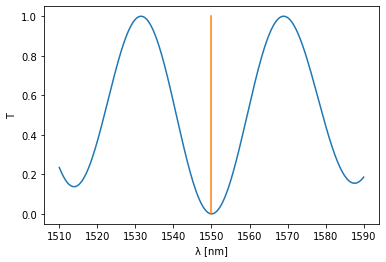

In [29]:
S = mzi(wl=wl, top={"length": 15.0 + delta_length}, btm={"length": 15.0})
plt.plot(wl * 1e3, abs(S["o1", "o4"]) ** 2)
plt.xlabel("λ [nm]")
plt.ylabel("T")
plt.ylim(-0.05, 1.05)
plt.plot([1550, 1550], [0, 1])
plt.show()

The minimum of the MZI is perfectly located at 1550nm.

## Model fit

You can fit a sax model to Sparameter FDTD simulation data.

In [30]:
import tqdm
import jax
import jax.numpy as jnp
import jax.example_libraries.optimizers as opt
import matplotlib.pyplot as plt

import gdsfactory as gf
import gdsfactory.simulation.modes as gm
import gdsfactory.simulation.sax as gs

In [31]:
gf.config.sparameters_path

PosixPath('/home/runner/work/gdsfactory/gdsfactory/gdslib/sp')

In [32]:
sd = gs.read.sdict_from_csv(gf.config.sparameters_path / 'coupler' / 'coupler_G224n_L20_S220.csv', xkey='wavelength_nm', prefix='S', xunits=1e-3)

In [33]:
coupler_fdtd = gf.partial(gs.read.sdict_from_csv, filepath=gf.config.sparameters_path / 'coupler' / 'coupler_G224n_L20_S220.csv', xkey='wavelength_nm', prefix='S', xunits=1e-3)

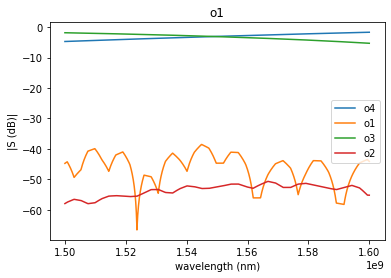

<AxesSubplot:title={'center':'o1'}, xlabel='wavelength (nm)', ylabel='|S (dB)|'>

In [34]:
gs.plot_model(coupler_fdtd)

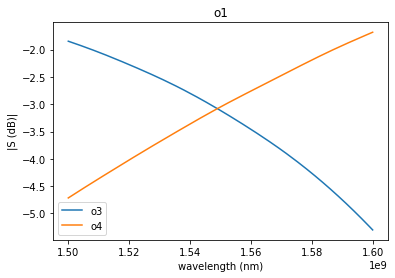

<AxesSubplot:title={'center':'o1'}, xlabel='wavelength (nm)', ylabel='|S (dB)|'>

In [35]:
gs.plot_model(coupler_fdtd, ports2=('o3', 'o4'))

In [36]:
modes = gm.find_modes_coupler(gap=0.224)
modes

{1: Mode1, 2: Mode2, 3: Mode3, 4: Mode4}

In [37]:
dn = modes[1].neff - modes[2].neff
dn

0.01660599375543148

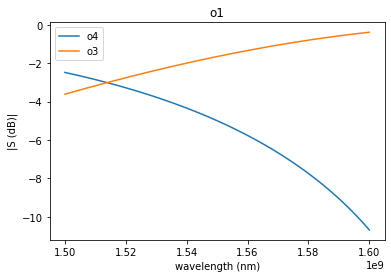

<AxesSubplot:title={'center':'o1'}, xlabel='wavelength (nm)', ylabel='|S (dB)|'>

In [38]:
coupler = gf.partial(gf.simulation.sax.models.coupler, dn=dn, length=20, coupling0=0.3)
gs.plot_model(coupler)

In [39]:
coupler_fdtd = gs.read.sdict_from_csv(filepath=gf.config.sparameters_path / 'coupler' / 'coupler_G224n_L20_S220.csv', xkey='wavelength_nm', prefix='S', xunits=1e-3)
S = coupler_fdtd
T_fdtd = abs(S['o1', 'o3'])**2
K_fdtd = abs(S['o1', 'o4'])**2

@jax.jit
def loss(coupling0, dn, dn1, dn2, dk1, dk2):
    """Returns fit least squares error from a coupler model spectrum
    to the FDTD Sparameter spectrum that we want to fit.
    
    Args:
        coupling0: coupling from the bend raegion
        dn: effective index difference between even and odd mode solver simulations.
        dn1: first derivative of effective index difference vs wavelength.
        dn2: second derivative of effective index difference vs wavelength.
        dk1: first derivative of coupling0 vs wavelength.
        dk2: second derivative of coupling vs wavelength.

    .. code::

          coupling0/2        coupling        coupling0/2
        <-------------><--------------------><---------->
         o2 ________                           _______o3
                    \                         /
                     \        length         /
                      ======================= gap
                     /                       \
            ________/                         \________
         o1                                           o4

                      ------------------------> K (coupled power)
                     /
                    / K
           -----------------------------------> T = 1 - K (transmitted power)

    T: o1 -> o4
    K: o1 -> o3
    """
    S = gf.simulation.sax.models.coupler(dn=dn, length=20, coupling0=coupling0, dn1=dn1, dn2=dn2, dk1=dk1, dk2=dk2)
    T_model = abs(S['o1', 'o4'])**2
    K_model = abs(S['o1', 'o3'])**2
    return jnp.abs(T_fdtd-T_model).mean() + jnp.abs(K_fdtd-K_model).mean()


loss(coupling0=0.3, dn=0.016, dk1 = 1.2435, dk2 = 5.3022, dn1 = 0.1169, dn2 = 0.4821)

0.31112

In [40]:
grad = jax.jit(
    jax.grad(
        loss,
        argnums=0,  # JAX gradient function for the first positional argument, jitted
    )
)

In [41]:
def train_step(step, optim_state, dn, dn1, dn2, dk1, dk2):
    settings = optim_params(optim_state)
    lossvalue = loss(settings, dn, dn1, dn2, dk1, dk2)
    gradvalue = grad(settings, dn, dn1, dn2, dk1, dk2)
    optim_state = optim_update(step, gradvalue, optim_state)
    return lossvalue, optim_state


coupling0 = 0.3
optim_init, optim_update, optim_params = opt.adam(step_size=0.1)
optim_state = optim_init(coupling0)

dn = 0.0166
dn1 = 0.11
dn2 = 0.48
dk1 = 1.2
dk2 = 5

range_ = tqdm.trange(300)
for step in range_:
    lossvalue, optim_state = train_step(step, optim_state, dn, dn1, dn2, dk1, dk2)
    range_.set_postfix(loss=f"{lossvalue:.6f}")

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s, loss=0.351761]

  0%|          | 1/300 [00:00<01:09,  4.33it/s, loss=0.351761]

  0%|          | 1/300 [00:00<01:09,  4.33it/s, loss=0.216963]

  1%|          | 2/300 [00:00<01:08,  4.35it/s, loss=0.216963]

  1%|          | 2/300 [00:00<01:08,  4.35it/s, loss=0.178975]

  1%|          | 2/300 [00:00<01:08,  4.35it/s, loss=0.212982]

  1%|          | 2/300 [00:00<01:08,  4.35it/s, loss=0.242301]

  1%|          | 2/300 [00:00<01:08,  4.35it/s, loss=0.235206]

  1%|          | 2/300 [00:00<01:08,  4.35it/s, loss=0.208810]

  1%|          | 2/300 [00:00<01:08,  4.35it/s, loss=0.185850]

  1%|          | 2/300 [00:00<01:08,  4.35it/s, loss=0.178526]

  1%|          | 2/300 [00:00<01:08,  4.35it/s, loss=0.186215]

  1%|          | 2/300 [00:00<01:08,  4.35it/s, loss=0.198756]

  1%|          | 2/300 [00:00<01:08,  4.35it/s, loss=0.205603]

  1%|          | 2/300 [00:00<01:08,  4.35it/s, loss=0.203065]

  1%|          | 2/300 [00:00<01:08,  4.35it/s, loss=0.193898]

  1%|          | 2/300 [00:00<01:08,  4.35it/s, loss=0.184057]

  1%|          | 2/300 [00:00<01:08,  4.35it/s, loss=0.178765]

  1%|          | 2/300 [00:00<01:08,  4.35it/s, loss=0.179949]

  1%|          | 2/300 [00:00<01:08,  4.35it/s, loss=0.185224]

  1%|          | 2/300 [00:00<01:08,  4.35it/s, loss=0.190039]

  1%|          | 2/300 [00:00<01:08,  4.35it/s, loss=0.190962]

  1%|          | 2/300 [00:00<01:08,  4.35it/s, loss=0.187685]

  1%|          | 2/300 [00:00<01:08,  4.35it/s, loss=0.182754]

  1%|          | 2/300 [00:00<01:08,  4.35it/s, loss=0.179180]

  1%|          | 2/300 [00:00<01:08,  4.35it/s, loss=0.178655]

  1%|          | 2/300 [00:00<01:08,  4.35it/s, loss=0.180717]

  1%|          | 2/300 [00:00<01:08,  4.35it/s, loss=0.183382]

  1%|          | 2/300 [00:00<01:08,  4.35it/s, loss=0.184607]

  1%|          | 2/300 [00:00<01:08,  4.35it/s, loss=0.183702]

  1%|          | 2/300 [00:00<01:08,  4.35it/s, loss=0.181374]

  1%|          | 2/300 [00:00<01:08,  4.35it/s, loss=0.179228]

  1%|          | 2/300 [00:00<01:08,  4.35it/s, loss=0.178476]

  1%|          | 2/300 [00:00<01:08,  4.35it/s, loss=0.179254]

  1%|          | 2/300 [00:00<01:08,  4.35it/s, loss=0.180684]

  1%|          | 2/300 [00:00<01:08,  4.35it/s, loss=0.181561]

  1%|          | 2/300 [00:00<01:08,  4.35it/s, loss=0.181224]

  1%|          | 2/300 [00:00<01:08,  4.35it/s, loss=0.180025]

  1%|          | 2/300 [00:00<01:08,  4.35it/s, loss=0.178864]

  1%|          | 2/300 [00:00<01:08,  4.35it/s, loss=0.178476]

  1%|          | 2/300 [00:00<01:08,  4.35it/s, loss=0.178954]

  1%|          | 2/300 [00:00<01:08,  4.35it/s, loss=0.179767]

  1%|          | 2/300 [00:00<01:08,  4.35it/s, loss=0.180180]

  1%|          | 2/300 [00:00<01:08,  4.35it/s, loss=0.179913]

  1%|          | 2/300 [00:00<01:08,  4.35it/s, loss=0.179186]

  1%|          | 2/300 [00:00<01:08,  4.35it/s, loss=0.178587]

  1%|          | 2/300 [00:00<01:08,  4.35it/s, loss=0.178518]

  1%|          | 2/300 [00:00<01:08,  4.35it/s, loss=0.178905]

  1%|          | 2/300 [00:00<01:08,  4.35it/s, loss=0.179340]

  1%|          | 2/300 [00:00<01:08,  4.35it/s, loss=0.179419]

  1%|          | 2/300 [00:00<01:08,  4.35it/s, loss=0.179117]

  1%|          | 2/300 [00:00<01:08,  4.35it/s, loss=0.178686]

  1%|          | 2/300 [00:00<01:08,  4.35it/s, loss=0.178476]

  1%|          | 2/300 [00:00<01:08,  4.35it/s, loss=0.178564]

  1%|          | 2/300 [00:00<01:08,  4.35it/s, loss=0.178805]

  1%|          | 2/300 [00:00<01:08,  4.35it/s, loss=0.178921]

  1%|          | 2/300 [00:00<01:08,  4.35it/s, loss=0.178842]

 18%|█▊        | 55/300 [00:00<00:01, 144.85it/s, loss=0.178842]

 18%|█▊        | 55/300 [00:00<00:01, 144.85it/s, loss=0.178635]

 18%|█▊        | 55/300 [00:00<00:01, 144.85it/s, loss=0.178481]

 18%|█▊        | 55/300 [00:00<00:01, 144.85it/s, loss=0.178504]

 18%|█▊        | 55/300 [00:00<00:01, 144.85it/s, loss=0.178619]

 18%|█▊        | 55/300 [00:00<00:01, 144.85it/s, loss=0.178692]

 18%|█▊        | 55/300 [00:00<00:01, 144.85it/s, loss=0.178671]

 18%|█▊        | 55/300 [00:00<00:01, 144.85it/s, loss=0.178571]

 18%|█▊        | 55/300 [00:00<00:01, 144.85it/s, loss=0.178484]

 18%|█▊        | 55/300 [00:00<00:01, 144.85it/s, loss=0.178476]

 18%|█▊        | 55/300 [00:00<00:01, 144.85it/s, loss=0.178543]

 18%|█▊        | 55/300 [00:00<00:01, 144.85it/s, loss=0.178615]

 18%|█▊        | 55/300 [00:00<00:01, 144.85it/s, loss=0.178610]

 18%|█▊        | 55/300 [00:00<00:01, 144.85it/s, loss=0.178539]

 18%|█▊        | 55/300 [00:00<00:01, 144.85it/s, loss=0.178477]

 18%|█▊        | 55/300 [00:00<00:01, 144.85it/s, loss=0.178476]

 18%|█▊        | 55/300 [00:00<00:01, 144.85it/s, loss=0.178529]

 18%|█▊        | 55/300 [00:00<00:01, 144.85it/s, loss=0.178572]

 18%|█▊        | 55/300 [00:00<00:01, 144.85it/s, loss=0.178567]

 18%|█▊        | 55/300 [00:00<00:01, 144.85it/s, loss=0.178523]

 18%|█▊        | 55/300 [00:00<00:01, 144.85it/s, loss=0.178476]

 18%|█▊        | 55/300 [00:00<00:01, 144.85it/s, loss=0.178476]

 18%|█▊        | 55/300 [00:00<00:01, 144.85it/s, loss=0.178503]

 18%|█▊        | 55/300 [00:00<00:01, 144.85it/s, loss=0.178522]

 18%|█▊        | 55/300 [00:00<00:01, 144.85it/s, loss=0.178515]

 18%|█▊        | 55/300 [00:00<00:01, 144.85it/s, loss=0.178484]

 18%|█▊        | 55/300 [00:00<00:01, 144.85it/s, loss=0.178476]

 18%|█▊        | 55/300 [00:00<00:01, 144.85it/s, loss=0.178484]

 18%|█▊        | 55/300 [00:00<00:01, 144.85it/s, loss=0.178513]

 18%|█▊        | 55/300 [00:00<00:01, 144.85it/s, loss=0.178516]

 18%|█▊        | 55/300 [00:00<00:01, 144.85it/s, loss=0.178493]

 18%|█▊        | 55/300 [00:00<00:01, 144.85it/s, loss=0.178476]

 18%|█▊        | 55/300 [00:00<00:01, 144.85it/s, loss=0.178476]

 18%|█▊        | 55/300 [00:00<00:01, 144.85it/s, loss=0.178500]

 18%|█▊        | 55/300 [00:00<00:01, 144.85it/s, loss=0.178508]

 18%|█▊        | 55/300 [00:00<00:01, 144.85it/s, loss=0.178490]

 18%|█▊        | 55/300 [00:00<00:01, 144.85it/s, loss=0.178476]

 18%|█▊        | 55/300 [00:00<00:01, 144.85it/s, loss=0.178476]

 18%|█▊        | 55/300 [00:00<00:01, 144.85it/s, loss=0.178494]

 18%|█▊        | 55/300 [00:00<00:01, 144.85it/s, loss=0.178499]

 18%|█▊        | 55/300 [00:00<00:01, 144.85it/s, loss=0.178481]

 18%|█▊        | 55/300 [00:00<00:01, 144.85it/s, loss=0.178476]

 18%|█▊        | 55/300 [00:00<00:01, 144.85it/s, loss=0.178476]

 18%|█▊        | 55/300 [00:00<00:01, 144.85it/s, loss=0.178481]

 18%|█▊        | 55/300 [00:00<00:01, 144.85it/s, loss=0.178492]

 18%|█▊        | 55/300 [00:00<00:01, 144.85it/s, loss=0.178478]

 18%|█▊        | 55/300 [00:00<00:01, 144.85it/s, loss=0.178476]

 18%|█▊        | 55/300 [00:00<00:01, 144.85it/s, loss=0.178476]

 18%|█▊        | 55/300 [00:00<00:01, 144.85it/s, loss=0.178479]

 18%|█▊        | 55/300 [00:00<00:01, 144.85it/s, loss=0.178483]

 18%|█▊        | 55/300 [00:00<00:01, 144.85it/s, loss=0.178479]

 18%|█▊        | 55/300 [00:00<00:01, 144.85it/s, loss=0.178476]

 18%|█▊        | 55/300 [00:00<00:01, 144.85it/s, loss=0.178476]

 36%|███▌      | 107/300 [00:00<00:00, 248.05it/s, loss=0.178476]

 36%|███▌      | 107/300 [00:00<00:00, 248.05it/s, loss=0.178476]

 36%|███▌      | 107/300 [00:00<00:00, 248.05it/s, loss=0.178476]

 36%|███▌      | 107/300 [00:00<00:00, 248.05it/s, loss=0.178480]

 36%|███▌      | 107/300 [00:00<00:00, 248.05it/s, loss=0.178478]

 36%|███▌      | 107/300 [00:00<00:00, 248.05it/s, loss=0.178476]

 36%|███▌      | 107/300 [00:00<00:00, 248.05it/s, loss=0.178476]

 36%|███▌      | 107/300 [00:00<00:00, 248.05it/s, loss=0.178476]

 36%|███▌      | 107/300 [00:00<00:00, 248.05it/s, loss=0.178476]

 36%|███▌      | 107/300 [00:00<00:00, 248.05it/s, loss=0.178476]

 36%|███▌      | 107/300 [00:00<00:00, 248.05it/s, loss=0.178477]

 36%|███▌      | 107/300 [00:00<00:00, 248.05it/s, loss=0.178476]

 36%|███▌      | 107/300 [00:00<00:00, 248.05it/s, loss=0.178476]

 36%|███▌      | 107/300 [00:00<00:00, 248.05it/s, loss=0.178476]

 36%|███▌      | 107/300 [00:00<00:00, 248.05it/s, loss=0.178476]

 36%|███▌      | 107/300 [00:00<00:00, 248.05it/s, loss=0.178476]

 36%|███▌      | 107/300 [00:00<00:00, 248.05it/s, loss=0.178476]

 36%|███▌      | 107/300 [00:00<00:00, 248.05it/s, loss=0.178476]

 36%|███▌      | 107/300 [00:00<00:00, 248.05it/s, loss=0.178476]

 36%|███▌      | 107/300 [00:00<00:00, 248.05it/s, loss=0.178476]

 36%|███▌      | 107/300 [00:00<00:00, 248.05it/s, loss=0.178476]

 36%|███▌      | 107/300 [00:00<00:00, 248.05it/s, loss=0.178476]

 36%|███▌      | 107/300 [00:00<00:00, 248.05it/s, loss=0.178476]

 36%|███▌      | 107/300 [00:00<00:00, 248.05it/s, loss=0.178476]

 36%|███▌      | 107/300 [00:00<00:00, 248.05it/s, loss=0.178476]

 36%|███▌      | 107/300 [00:00<00:00, 248.05it/s, loss=0.178476]

 36%|███▌      | 107/300 [00:00<00:00, 248.05it/s, loss=0.178476]

 36%|███▌      | 107/300 [00:00<00:00, 248.05it/s, loss=0.178476]

 36%|███▌      | 107/300 [00:00<00:00, 248.05it/s, loss=0.178476]

 36%|███▌      | 107/300 [00:00<00:00, 248.05it/s, loss=0.178476]

 36%|███▌      | 107/300 [00:00<00:00, 248.05it/s, loss=0.178476]

 36%|███▌      | 107/300 [00:00<00:00, 248.05it/s, loss=0.178476]

 36%|███▌      | 107/300 [00:00<00:00, 248.05it/s, loss=0.178476]

 36%|███▌      | 107/300 [00:00<00:00, 248.05it/s, loss=0.178476]

 36%|███▌      | 107/300 [00:00<00:00, 248.05it/s, loss=0.178476]

 36%|███▌      | 107/300 [00:00<00:00, 248.05it/s, loss=0.178476]

 36%|███▌      | 107/300 [00:00<00:00, 248.05it/s, loss=0.178476]

 36%|███▌      | 107/300 [00:00<00:00, 248.05it/s, loss=0.178476]

 36%|███▌      | 107/300 [00:00<00:00, 248.05it/s, loss=0.178476]

 36%|███▌      | 107/300 [00:00<00:00, 248.05it/s, loss=0.178476]

 36%|███▌      | 107/300 [00:00<00:00, 248.05it/s, loss=0.178476]

 36%|███▌      | 107/300 [00:00<00:00, 248.05it/s, loss=0.178476]

 36%|███▌      | 107/300 [00:00<00:00, 248.05it/s, loss=0.178476]

 36%|███▌      | 107/300 [00:00<00:00, 248.05it/s, loss=0.178476]

 36%|███▌      | 107/300 [00:00<00:00, 248.05it/s, loss=0.178476]

 36%|███▌      | 107/300 [00:00<00:00, 248.05it/s, loss=0.178476]

 36%|███▌      | 107/300 [00:00<00:00, 248.05it/s, loss=0.178476]

 36%|███▌      | 107/300 [00:00<00:00, 248.05it/s, loss=0.178476]

 36%|███▌      | 107/300 [00:00<00:00, 248.05it/s, loss=0.178476]

 36%|███▌      | 107/300 [00:00<00:00, 248.05it/s, loss=0.178476]

 36%|███▌      | 107/300 [00:00<00:00, 248.05it/s, loss=0.178476]

 36%|███▌      | 107/300 [00:00<00:00, 248.05it/s, loss=0.178476]

 36%|███▌      | 107/300 [00:00<00:00, 248.05it/s, loss=0.178476]

 36%|███▌      | 107/300 [00:00<00:00, 248.05it/s, loss=0.178476]

 53%|█████▎    | 160/300 [00:00<00:00, 326.48it/s, loss=0.178476]

 53%|█████▎    | 160/300 [00:00<00:00, 326.48it/s, loss=0.178476]

 53%|█████▎    | 160/300 [00:00<00:00, 326.48it/s, loss=0.178476]

 53%|█████▎    | 160/300 [00:00<00:00, 326.48it/s, loss=0.178476]

 53%|█████▎    | 160/300 [00:00<00:00, 326.48it/s, loss=0.178476]

 53%|█████▎    | 160/300 [00:00<00:00, 326.48it/s, loss=0.178476]

 53%|█████▎    | 160/300 [00:00<00:00, 326.48it/s, loss=0.178476]

 53%|█████▎    | 160/300 [00:00<00:00, 326.48it/s, loss=0.178476]

 53%|█████▎    | 160/300 [00:00<00:00, 326.48it/s, loss=0.178476]

 53%|█████▎    | 160/300 [00:00<00:00, 326.48it/s, loss=0.178476]

 53%|█████▎    | 160/300 [00:00<00:00, 326.48it/s, loss=0.178476]

 53%|█████▎    | 160/300 [00:00<00:00, 326.48it/s, loss=0.178476]

 53%|█████▎    | 160/300 [00:00<00:00, 326.48it/s, loss=0.178476]

 53%|█████▎    | 160/300 [00:00<00:00, 326.48it/s, loss=0.178476]

 53%|█████▎    | 160/300 [00:00<00:00, 326.48it/s, loss=0.178476]

 53%|█████▎    | 160/300 [00:00<00:00, 326.48it/s, loss=0.178476]

 53%|█████▎    | 160/300 [00:00<00:00, 326.48it/s, loss=0.178476]

 53%|█████▎    | 160/300 [00:00<00:00, 326.48it/s, loss=0.178476]

 53%|█████▎    | 160/300 [00:00<00:00, 326.48it/s, loss=0.178476]

 53%|█████▎    | 160/300 [00:00<00:00, 326.48it/s, loss=0.178476]

 53%|█████▎    | 160/300 [00:00<00:00, 326.48it/s, loss=0.178476]

 53%|█████▎    | 160/300 [00:00<00:00, 326.48it/s, loss=0.178476]

 53%|█████▎    | 160/300 [00:00<00:00, 326.48it/s, loss=0.178476]

 53%|█████▎    | 160/300 [00:00<00:00, 326.48it/s, loss=0.178476]

 53%|█████▎    | 160/300 [00:00<00:00, 326.48it/s, loss=0.178476]

 53%|█████▎    | 160/300 [00:00<00:00, 326.48it/s, loss=0.178476]

 53%|█████▎    | 160/300 [00:00<00:00, 326.48it/s, loss=0.178476]

 53%|█████▎    | 160/300 [00:00<00:00, 326.48it/s, loss=0.178476]

 53%|█████▎    | 160/300 [00:00<00:00, 326.48it/s, loss=0.178476]

 53%|█████▎    | 160/300 [00:00<00:00, 326.48it/s, loss=0.178476]

 53%|█████▎    | 160/300 [00:00<00:00, 326.48it/s, loss=0.178476]

 53%|█████▎    | 160/300 [00:00<00:00, 326.48it/s, loss=0.178476]

 53%|█████▎    | 160/300 [00:00<00:00, 326.48it/s, loss=0.178476]

 53%|█████▎    | 160/300 [00:00<00:00, 326.48it/s, loss=0.178476]

 53%|█████▎    | 160/300 [00:00<00:00, 326.48it/s, loss=0.178476]

 53%|█████▎    | 160/300 [00:00<00:00, 326.48it/s, loss=0.178476]

 53%|█████▎    | 160/300 [00:00<00:00, 326.48it/s, loss=0.178476]

 53%|█████▎    | 160/300 [00:00<00:00, 326.48it/s, loss=0.178476]

 53%|█████▎    | 160/300 [00:00<00:00, 326.48it/s, loss=0.178476]

 53%|█████▎    | 160/300 [00:00<00:00, 326.48it/s, loss=0.178476]

 53%|█████▎    | 160/300 [00:00<00:00, 326.48it/s, loss=0.178476]

 53%|█████▎    | 160/300 [00:00<00:00, 326.48it/s, loss=0.178476]

 53%|█████▎    | 160/300 [00:00<00:00, 326.48it/s, loss=0.178476]

 53%|█████▎    | 160/300 [00:00<00:00, 326.48it/s, loss=0.178476]

 53%|█████▎    | 160/300 [00:00<00:00, 326.48it/s, loss=0.178476]

 53%|█████▎    | 160/300 [00:00<00:00, 326.48it/s, loss=0.178476]

 53%|█████▎    | 160/300 [00:00<00:00, 326.48it/s, loss=0.178476]

 53%|█████▎    | 160/300 [00:00<00:00, 326.48it/s, loss=0.178476]

 53%|█████▎    | 160/300 [00:00<00:00, 326.48it/s, loss=0.178476]

 53%|█████▎    | 160/300 [00:00<00:00, 326.48it/s, loss=0.178476]

 53%|█████▎    | 160/300 [00:00<00:00, 326.48it/s, loss=0.178476]

 53%|█████▎    | 160/300 [00:00<00:00, 326.48it/s, loss=0.178476]

 53%|█████▎    | 160/300 [00:00<00:00, 326.48it/s, loss=0.178476]

 71%|███████   | 212/300 [00:00<00:00, 379.49it/s, loss=0.178476]

 71%|███████   | 212/300 [00:00<00:00, 379.49it/s, loss=0.178476]

 71%|███████   | 212/300 [00:00<00:00, 379.49it/s, loss=0.178476]

 71%|███████   | 212/300 [00:00<00:00, 379.49it/s, loss=0.178476]

 71%|███████   | 212/300 [00:00<00:00, 379.49it/s, loss=0.178476]

 71%|███████   | 212/300 [00:00<00:00, 379.49it/s, loss=0.178476]

 71%|███████   | 212/300 [00:00<00:00, 379.49it/s, loss=0.178476]

 71%|███████   | 212/300 [00:00<00:00, 379.49it/s, loss=0.178476]

 71%|███████   | 212/300 [00:00<00:00, 379.49it/s, loss=0.178476]

 71%|███████   | 212/300 [00:00<00:00, 379.49it/s, loss=0.178476]

 71%|███████   | 212/300 [00:00<00:00, 379.49it/s, loss=0.178476]

 71%|███████   | 212/300 [00:00<00:00, 379.49it/s, loss=0.178476]

 71%|███████   | 212/300 [00:00<00:00, 379.49it/s, loss=0.178476]

 71%|███████   | 212/300 [00:00<00:00, 379.49it/s, loss=0.178476]

 71%|███████   | 212/300 [00:00<00:00, 379.49it/s, loss=0.178476]

 71%|███████   | 212/300 [00:00<00:00, 379.49it/s, loss=0.178476]

 71%|███████   | 212/300 [00:00<00:00, 379.49it/s, loss=0.178476]

 71%|███████   | 212/300 [00:00<00:00, 379.49it/s, loss=0.178476]

 71%|███████   | 212/300 [00:00<00:00, 379.49it/s, loss=0.178476]

 71%|███████   | 212/300 [00:00<00:00, 379.49it/s, loss=0.178476]

 71%|███████   | 212/300 [00:00<00:00, 379.49it/s, loss=0.178476]

 71%|███████   | 212/300 [00:00<00:00, 379.49it/s, loss=0.178476]

 71%|███████   | 212/300 [00:00<00:00, 379.49it/s, loss=0.178476]

 71%|███████   | 212/300 [00:00<00:00, 379.49it/s, loss=0.178476]

 71%|███████   | 212/300 [00:00<00:00, 379.49it/s, loss=0.178476]

 71%|███████   | 212/300 [00:00<00:00, 379.49it/s, loss=0.178476]

 71%|███████   | 212/300 [00:00<00:00, 379.49it/s, loss=0.178476]

 71%|███████   | 212/300 [00:00<00:00, 379.49it/s, loss=0.178476]

 71%|███████   | 212/300 [00:00<00:00, 379.49it/s, loss=0.178476]

 71%|███████   | 212/300 [00:00<00:00, 379.49it/s, loss=0.178476]

 71%|███████   | 212/300 [00:00<00:00, 379.49it/s, loss=0.178476]

 71%|███████   | 212/300 [00:00<00:00, 379.49it/s, loss=0.178476]

 71%|███████   | 212/300 [00:00<00:00, 379.49it/s, loss=0.178476]

 71%|███████   | 212/300 [00:00<00:00, 379.49it/s, loss=0.178476]

 71%|███████   | 212/300 [00:00<00:00, 379.49it/s, loss=0.178476]

 71%|███████   | 212/300 [00:00<00:00, 379.49it/s, loss=0.178476]

 71%|███████   | 212/300 [00:00<00:00, 379.49it/s, loss=0.178476]

 71%|███████   | 212/300 [00:00<00:00, 379.49it/s, loss=0.178476]

 71%|███████   | 212/300 [00:00<00:00, 379.49it/s, loss=0.178476]

 71%|███████   | 212/300 [00:00<00:00, 379.49it/s, loss=0.178476]

 71%|███████   | 212/300 [00:00<00:00, 379.49it/s, loss=0.178476]

 71%|███████   | 212/300 [00:00<00:00, 379.49it/s, loss=0.178476]

 71%|███████   | 212/300 [00:00<00:00, 379.49it/s, loss=0.178476]

 71%|███████   | 212/300 [00:00<00:00, 379.49it/s, loss=0.178476]

 71%|███████   | 212/300 [00:00<00:00, 379.49it/s, loss=0.178476]

 71%|███████   | 212/300 [00:00<00:00, 379.49it/s, loss=0.178476]

 71%|███████   | 212/300 [00:00<00:00, 379.49it/s, loss=0.178476]

 71%|███████   | 212/300 [00:00<00:00, 379.49it/s, loss=0.178476]

 71%|███████   | 212/300 [00:00<00:00, 379.49it/s, loss=0.178476]

 87%|████████▋ | 260/300 [00:00<00:00, 407.70it/s, loss=0.178476]

 87%|████████▋ | 260/300 [00:00<00:00, 407.70it/s, loss=0.178476]

 87%|████████▋ | 260/300 [00:00<00:00, 407.70it/s, loss=0.178476]

 87%|████████▋ | 260/300 [00:00<00:00, 407.70it/s, loss=0.178476]

 87%|████████▋ | 260/300 [00:00<00:00, 407.70it/s, loss=0.178476]

 87%|████████▋ | 260/300 [00:00<00:00, 407.70it/s, loss=0.178476]

 87%|████████▋ | 260/300 [00:00<00:00, 407.70it/s, loss=0.178476]

 87%|████████▋ | 260/300 [00:00<00:00, 407.70it/s, loss=0.178476]

 87%|████████▋ | 260/300 [00:00<00:00, 407.70it/s, loss=0.178476]

 87%|████████▋ | 260/300 [00:00<00:00, 407.70it/s, loss=0.178476]

 87%|████████▋ | 260/300 [00:00<00:00, 407.70it/s, loss=0.178476]

 87%|████████▋ | 260/300 [00:00<00:00, 407.70it/s, loss=0.178476]

 87%|████████▋ | 260/300 [00:00<00:00, 407.70it/s, loss=0.178476]

 87%|████████▋ | 260/300 [00:00<00:00, 407.70it/s, loss=0.178476]

 87%|████████▋ | 260/300 [00:00<00:00, 407.70it/s, loss=0.178476]

 87%|████████▋ | 260/300 [00:00<00:00, 407.70it/s, loss=0.178476]

 87%|████████▋ | 260/300 [00:00<00:00, 407.70it/s, loss=0.178476]

 87%|████████▋ | 260/300 [00:00<00:00, 407.70it/s, loss=0.178476]

 87%|████████▋ | 260/300 [00:00<00:00, 407.70it/s, loss=0.178476]

 87%|████████▋ | 260/300 [00:01<00:00, 407.70it/s, loss=0.178476]

 87%|████████▋ | 260/300 [00:01<00:00, 407.70it/s, loss=0.178476]

 87%|████████▋ | 260/300 [00:01<00:00, 407.70it/s, loss=0.178476]

 87%|████████▋ | 260/300 [00:01<00:00, 407.70it/s, loss=0.178476]

 87%|████████▋ | 260/300 [00:01<00:00, 407.70it/s, loss=0.178476]

 87%|████████▋ | 260/300 [00:01<00:00, 407.70it/s, loss=0.178476]

 87%|████████▋ | 260/300 [00:01<00:00, 407.70it/s, loss=0.178476]

 87%|████████▋ | 260/300 [00:01<00:00, 407.70it/s, loss=0.178476]

 87%|████████▋ | 260/300 [00:01<00:00, 407.70it/s, loss=0.178476]

 87%|████████▋ | 260/300 [00:01<00:00, 407.70it/s, loss=0.178476]

 87%|████████▋ | 260/300 [00:01<00:00, 407.70it/s, loss=0.178476]

 87%|████████▋ | 260/300 [00:01<00:00, 407.70it/s, loss=0.178476]

 87%|████████▋ | 260/300 [00:01<00:00, 407.70it/s, loss=0.178476]

 87%|████████▋ | 260/300 [00:01<00:00, 407.70it/s, loss=0.178476]

 87%|████████▋ | 260/300 [00:01<00:00, 407.70it/s, loss=0.178476]

 87%|████████▋ | 260/300 [00:01<00:00, 407.70it/s, loss=0.178476]

 87%|████████▋ | 260/300 [00:01<00:00, 407.70it/s, loss=0.178476]

 87%|████████▋ | 260/300 [00:01<00:00, 407.70it/s, loss=0.178476]

 87%|████████▋ | 260/300 [00:01<00:00, 407.70it/s, loss=0.178476]

 87%|████████▋ | 260/300 [00:01<00:00, 407.70it/s, loss=0.178476]

 87%|████████▋ | 260/300 [00:01<00:00, 407.70it/s, loss=0.178476]

 87%|████████▋ | 260/300 [00:01<00:00, 407.70it/s, loss=0.178476]

100%|██████████| 300/300 [00:01<00:00, 289.10it/s, loss=0.178476]

In [42]:
coupling0_fit = optim_params(optim_state)
coupling0_fit

0.11667

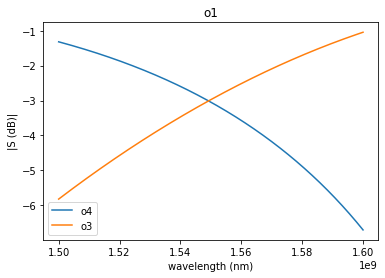

<AxesSubplot:title={'center':'o1'}, xlabel='wavelength (nm)', ylabel='|S (dB)|'>

In [43]:
coupler = gf.partial(gf.simulation.sax.models.coupler, dn=dn, length=20, coupling0=coupling0_fit)
gs.plot_model(coupler)

In [44]:
wl = jnp.linspace(1.50, 1.60, 1000)
S = gf.simulation.sax.models.coupler(dn=dn, length=20, coupling0=coupling0_fit, dn1=dn1, dn2=dn2, dk1=dk1, dk2=dk2, wl=wl)
T_model = abs(S['o1', 'o4'])**2
K_model = abs(S['o1', 'o3'])**2

In [45]:
coupler_fdtd = S = gs.read.sdict_from_csv(filepath=gf.config.sparameters_path / 'coupler' / 'coupler_G224n_L20_S220.csv', xkey='wavelength_nm', prefix='S', xunits=1e-3, wl=wl)
T_fdtd = abs(S['o1', 'o3'])**2
K_fdtd = abs(S['o1', 'o4'])**2

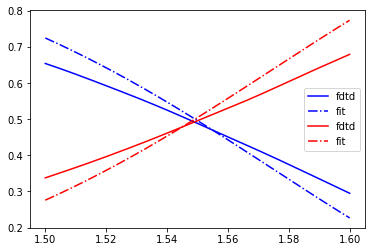

In [46]:
plt.plot(wl, T_fdtd, label='fdtd', c='b')
plt.plot(wl, T_model, label='fit', c='b', ls='-.')
plt.plot(wl, K_fdtd, label='fdtd', c='r')
plt.plot(wl, K_model, label='fit', c='r', ls='-.')
plt.legend()

### Multi-variable optimization

As you can see we need to fit more than 1 variable `coupling0` to get a good fit.

In [47]:
grad = jax.jit(
    jax.grad(
        loss,
        #argnums=0,  # JAX gradient function for the first positional argument, jitted
        argnums=[0, 1, 2, 3, 4, 5],  # JAX gradient function for all positional arguments, jitted
    )
)

In [48]:
def train_step(step, optim_state):
    coupling0, dn, dn1, dn2, dk1, dk2 = optim_params(optim_state)
    lossvalue = loss(coupling0, dn, dn1, dn2, dk1, dk2)
    gradvalue = grad(coupling0, dn, dn1, dn2, dk1, dk2)
    optim_state = optim_update(step, gradvalue, optim_state)
    return lossvalue, optim_state

In [49]:
coupling0 = 0.3
dn = 0.0166
dn1 = 0.11
dn2 = 0.48
dk1 = 1.2
dk2 = 5.0
optim_init, optim_update, optim_params = opt.adam(step_size=0.01)
optim_state = optim_init((coupling0, dn, dn1, dn2, dk1, dk2))

In [50]:
range_ = tqdm.trange(1000)
for step in range_:
    lossvalue, optim_state = train_step(step, optim_state)
    range_.set_postfix(loss=f"{lossvalue:.6f}")

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s, loss=0.351744]

  0%|          | 1/1000 [00:00<04:18,  3.87it/s, loss=0.351744]

  0%|          | 1/1000 [00:00<04:18,  3.87it/s, loss=0.455868]

  0%|          | 2/1000 [00:00<04:18,  3.87it/s, loss=0.455868]

  0%|          | 2/1000 [00:00<04:18,  3.87it/s, loss=0.408208]

  0%|          | 2/1000 [00:00<04:18,  3.87it/s, loss=0.182992]

  0%|          | 2/1000 [00:00<04:18,  3.87it/s, loss=0.276236]

  0%|          | 2/1000 [00:00<04:18,  3.87it/s, loss=0.335642]

  0%|          | 2/1000 [00:00<04:18,  3.87it/s, loss=0.239862]

  0%|          | 2/1000 [00:00<04:18,  3.87it/s, loss=0.177655]

  0%|          | 2/1000 [00:00<04:18,  3.87it/s, loss=0.240594]

  0%|          | 2/1000 [00:00<04:18,  3.87it/s, loss=0.272126]

  0%|          | 2/1000 [00:00<04:18,  3.87it/s, loss=0.214315]

  0%|          | 2/1000 [00:00<04:18,  3.87it/s, loss=0.177319]

  0%|          | 2/1000 [00:00<04:18,  3.87it/s, loss=0.208923]

  0%|          | 2/1000 [00:00<04:18,  3.87it/s, loss=0.237348]

  0%|          | 2/1000 [00:00<04:18,  3.87it/s, loss=0.216135]

  0%|          | 2/1000 [00:00<04:18,  3.87it/s, loss=0.181517]

  0%|          | 2/1000 [00:00<04:18,  3.87it/s, loss=0.184931]

  0%|          | 2/1000 [00:00<04:18,  3.87it/s, loss=0.211244]

  0%|          | 2/1000 [00:00<04:18,  3.87it/s, loss=0.210202]

  0%|          | 2/1000 [00:00<04:18,  3.87it/s, loss=0.185683]

  0%|          | 2/1000 [00:00<04:18,  3.87it/s, loss=0.178353]

  0%|          | 2/1000 [00:00<04:18,  3.87it/s, loss=0.193983]

  0%|          | 2/1000 [00:00<04:18,  3.87it/s, loss=0.201489]

  0%|          | 2/1000 [00:00<04:18,  3.87it/s, loss=0.188822]

  0%|          | 2/1000 [00:00<04:18,  3.87it/s, loss=0.177430]

  2%|▎         | 25/1000 [00:00<00:16, 59.16it/s, loss=0.177430]

  2%|▎         | 25/1000 [00:00<00:16, 59.16it/s, loss=0.183944]

  2%|▎         | 25/1000 [00:00<00:16, 59.16it/s, loss=0.193208]

  2%|▎         | 25/1000 [00:00<00:16, 59.16it/s, loss=0.187861]

  2%|▎         | 25/1000 [00:00<00:16, 59.16it/s, loss=0.178169]

  2%|▎         | 25/1000 [00:00<00:16, 59.16it/s, loss=0.179964]

  2%|▎         | 25/1000 [00:00<00:16, 59.16it/s, loss=0.187078]

  2%|▎         | 25/1000 [00:00<00:16, 59.16it/s, loss=0.185649]

  2%|▎         | 25/1000 [00:00<00:16, 59.16it/s, loss=0.178687]

  2%|▎         | 25/1000 [00:00<00:16, 59.16it/s, loss=0.178290]

  2%|▎         | 25/1000 [00:00<00:16, 59.16it/s, loss=0.183323]

  2%|▎         | 25/1000 [00:00<00:16, 59.16it/s, loss=0.183278]

  2%|▎         | 25/1000 [00:00<00:16, 59.16it/s, loss=0.178503]

  2%|▎         | 25/1000 [00:00<00:16, 59.16it/s, loss=0.177822]

  2%|▎         | 25/1000 [00:00<00:16, 59.16it/s, loss=0.181261]

  2%|▎         | 25/1000 [00:00<00:16, 59.16it/s, loss=0.181431]

  2%|▎         | 25/1000 [00:00<00:16, 59.16it/s, loss=0.178149]

  2%|▎         | 25/1000 [00:00<00:16, 59.16it/s, loss=0.177662]

  2%|▎         | 25/1000 [00:00<00:16, 59.16it/s, loss=0.180030]

  2%|▎         | 25/1000 [00:00<00:16, 59.16it/s, loss=0.179965]

  2%|▎         | 25/1000 [00:00<00:16, 59.16it/s, loss=0.177717]

  2%|▎         | 25/1000 [00:00<00:16, 59.16it/s, loss=0.177682]

  2%|▎         | 25/1000 [00:00<00:16, 59.16it/s, loss=0.179285]

  5%|▍         | 47/1000 [00:00<00:09, 99.98it/s, loss=0.179285]

  5%|▍         | 47/1000 [00:00<00:09, 99.98it/s, loss=0.178895]

  5%|▍         | 47/1000 [00:00<00:09, 99.98it/s, loss=0.177422]

  5%|▍         | 47/1000 [00:00<00:09, 99.98it/s, loss=0.177751]

  5%|▍         | 47/1000 [00:00<00:09, 99.98it/s, loss=0.178736]

  5%|▍         | 47/1000 [00:00<00:09, 99.98it/s, loss=0.178116]

  5%|▍         | 47/1000 [00:00<00:09, 99.98it/s, loss=0.177292]

  5%|▍         | 47/1000 [00:00<00:09, 99.98it/s, loss=0.177836]

  5%|▍         | 47/1000 [00:00<00:09, 99.98it/s, loss=0.178254]

  5%|▍         | 47/1000 [00:00<00:09, 99.98it/s, loss=0.177608]

  5%|▍         | 47/1000 [00:00<00:09, 99.98it/s, loss=0.177323]

  5%|▍         | 47/1000 [00:00<00:09, 99.98it/s, loss=0.177839]

  5%|▍         | 47/1000 [00:00<00:09, 99.98it/s, loss=0.177842]

  5%|▍         | 47/1000 [00:00<00:09, 99.98it/s, loss=0.177345]

  5%|▍         | 47/1000 [00:00<00:09, 99.98it/s, loss=0.177437]

  5%|▍         | 47/1000 [00:00<00:09, 99.98it/s, loss=0.177756]

  5%|▍         | 47/1000 [00:00<00:09, 99.98it/s, loss=0.177511]

  5%|▍         | 47/1000 [00:00<00:09, 99.98it/s, loss=0.177291]

  5%|▍         | 47/1000 [00:00<00:09, 99.98it/s, loss=0.177521]

  5%|▍         | 47/1000 [00:00<00:09, 99.98it/s, loss=0.177573]

  5%|▍         | 47/1000 [00:00<00:09, 99.98it/s, loss=0.177327]

  5%|▍         | 47/1000 [00:00<00:09, 99.98it/s, loss=0.177353]

  5%|▍         | 47/1000 [00:00<00:09, 99.98it/s, loss=0.177517]

  7%|▋         | 69/1000 [00:00<00:07, 131.80it/s, loss=0.177517]

  7%|▋         | 69/1000 [00:00<00:07, 131.80it/s, loss=0.177396]

  7%|▋         | 69/1000 [00:00<00:07, 131.80it/s, loss=0.177291]

  7%|▋         | 69/1000 [00:00<00:07, 131.80it/s, loss=0.177420]

  7%|▋         | 69/1000 [00:00<00:07, 131.80it/s, loss=0.177426]

  7%|▋         | 69/1000 [00:00<00:07, 131.80it/s, loss=0.177300]

  7%|▋         | 69/1000 [00:00<00:07, 131.80it/s, loss=0.177335]

  7%|▋         | 69/1000 [00:00<00:07, 131.80it/s, loss=0.177406]

  7%|▋         | 69/1000 [00:00<00:07, 131.80it/s, loss=0.177329]

  7%|▋         | 69/1000 [00:00<00:07, 131.80it/s, loss=0.177295]

  7%|▋         | 69/1000 [00:00<00:07, 131.80it/s, loss=0.177365]

  7%|▋         | 69/1000 [00:00<00:07, 131.80it/s, loss=0.177343]

  7%|▋         | 69/1000 [00:00<00:07, 131.80it/s, loss=0.177288]

  7%|▋         | 69/1000 [00:00<00:07, 131.80it/s, loss=0.177327]

  7%|▋         | 69/1000 [00:00<00:07, 131.80it/s, loss=0.177340]

  7%|▋         | 69/1000 [00:00<00:07, 131.80it/s, loss=0.177293]

  7%|▋         | 69/1000 [00:00<00:07, 131.80it/s, loss=0.177307]

  7%|▋         | 69/1000 [00:00<00:07, 131.80it/s, loss=0.177335]

  7%|▋         | 69/1000 [00:00<00:07, 131.80it/s, loss=0.177301]

  7%|▋         | 69/1000 [00:00<00:07, 131.80it/s, loss=0.177294]

  7%|▋         | 69/1000 [00:00<00:07, 131.80it/s, loss=0.177318]

  7%|▋         | 69/1000 [00:00<00:07, 131.80it/s, loss=0.177302]

  9%|▉         | 90/1000 [00:00<00:05, 152.47it/s, loss=0.177302]

  9%|▉         | 90/1000 [00:00<00:05, 152.47it/s, loss=0.177290]

  9%|▉         | 90/1000 [00:00<00:05, 152.47it/s, loss=0.177311]

  9%|▉         | 90/1000 [00:00<00:05, 152.47it/s, loss=0.177305]

  9%|▉         | 90/1000 [00:00<00:05, 152.47it/s, loss=0.177288]

  9%|▉         | 90/1000 [00:00<00:05, 152.47it/s, loss=0.177305]

  9%|▉         | 90/1000 [00:00<00:05, 152.47it/s, loss=0.177303]

  9%|▉         | 90/1000 [00:00<00:05, 152.47it/s, loss=0.177288]

  9%|▉         | 90/1000 [00:00<00:05, 152.47it/s, loss=0.177296]

  9%|▉         | 90/1000 [00:00<00:05, 152.47it/s, loss=0.177300]

  9%|▉         | 90/1000 [00:00<00:05, 152.47it/s, loss=0.177289]

  9%|▉         | 90/1000 [00:00<00:05, 152.47it/s, loss=0.177292]

  9%|▉         | 90/1000 [00:00<00:05, 152.47it/s, loss=0.177298]

  9%|▉         | 90/1000 [00:00<00:05, 152.47it/s, loss=0.177290]

  9%|▉         | 90/1000 [00:00<00:05, 152.47it/s, loss=0.177290]

  9%|▉         | 90/1000 [00:00<00:05, 152.47it/s, loss=0.177293]

  9%|▉         | 90/1000 [00:00<00:05, 152.47it/s, loss=0.177289]

  9%|▉         | 90/1000 [00:00<00:05, 152.47it/s, loss=0.177289]

  9%|▉         | 90/1000 [00:01<00:05, 152.47it/s, loss=0.177292]

  9%|▉         | 90/1000 [00:01<00:05, 152.47it/s, loss=0.177290]

  9%|▉         | 90/1000 [00:01<00:05, 152.47it/s, loss=0.177288]

  9%|▉         | 90/1000 [00:01<00:05, 152.47it/s, loss=0.177291]

  9%|▉         | 90/1000 [00:01<00:05, 152.47it/s, loss=0.177290]

  9%|▉         | 90/1000 [00:01<00:05, 152.47it/s, loss=0.177288]

 11%|█▏        | 113/1000 [00:01<00:05, 174.14it/s, loss=0.177288]

 11%|█▏        | 113/1000 [00:01<00:05, 174.14it/s, loss=0.177291]

 11%|█▏        | 113/1000 [00:01<00:05, 174.14it/s, loss=0.177290]

 11%|█▏        | 113/1000 [00:01<00:05, 174.14it/s, loss=0.177289]

 11%|█▏        | 113/1000 [00:01<00:05, 174.14it/s, loss=0.177291]

 11%|█▏        | 113/1000 [00:01<00:05, 174.14it/s, loss=0.177289]

 11%|█▏        | 113/1000 [00:01<00:05, 174.14it/s, loss=0.177289]

 11%|█▏        | 113/1000 [00:01<00:05, 174.14it/s, loss=0.177290]

 11%|█▏        | 113/1000 [00:01<00:05, 174.14it/s, loss=0.177288]

 11%|█▏        | 113/1000 [00:01<00:05, 174.14it/s, loss=0.177289]

 11%|█▏        | 113/1000 [00:01<00:05, 174.14it/s, loss=0.177289]

 11%|█▏        | 113/1000 [00:01<00:05, 174.14it/s, loss=0.177288]

 11%|█▏        | 113/1000 [00:01<00:05, 174.14it/s, loss=0.177289]

 11%|█▏        | 113/1000 [00:01<00:05, 174.14it/s, loss=0.177288]

 11%|█▏        | 113/1000 [00:01<00:05, 174.14it/s, loss=0.177288]

 11%|█▏        | 113/1000 [00:01<00:05, 174.14it/s, loss=0.177288]

 11%|█▏        | 113/1000 [00:01<00:05, 174.14it/s, loss=0.177288]

 11%|█▏        | 113/1000 [00:01<00:05, 174.14it/s, loss=0.177288]

 11%|█▏        | 113/1000 [00:01<00:05, 174.14it/s, loss=0.177288]

 11%|█▏        | 113/1000 [00:01<00:05, 174.14it/s, loss=0.177288]

 11%|█▏        | 113/1000 [00:01<00:05, 174.14it/s, loss=0.177288]

 11%|█▏        | 113/1000 [00:01<00:05, 174.14it/s, loss=0.177289]

 11%|█▏        | 113/1000 [00:01<00:05, 174.14it/s, loss=0.177288]

 14%|█▎        | 135/1000 [00:01<00:04, 185.55it/s, loss=0.177288]

 14%|█▎        | 135/1000 [00:01<00:04, 185.55it/s, loss=0.177289]

 14%|█▎        | 135/1000 [00:01<00:04, 185.55it/s, loss=0.177288]

 14%|█▎        | 135/1000 [00:01<00:04, 185.55it/s, loss=0.177288]

 14%|█▎        | 135/1000 [00:01<00:04, 185.55it/s, loss=0.177288]

 14%|█▎        | 135/1000 [00:01<00:04, 185.55it/s, loss=0.177288]

 14%|█▎        | 135/1000 [00:01<00:04, 185.55it/s, loss=0.177288]

 14%|█▎        | 135/1000 [00:01<00:04, 185.55it/s, loss=0.177289]

 14%|█▎        | 135/1000 [00:01<00:04, 185.55it/s, loss=0.177289]

 14%|█▎        | 135/1000 [00:01<00:04, 185.55it/s, loss=0.177289]

 14%|█▎        | 135/1000 [00:01<00:04, 185.55it/s, loss=0.177289]

 14%|█▎        | 135/1000 [00:01<00:04, 185.55it/s, loss=0.177288]

 14%|█▎        | 135/1000 [00:01<00:04, 185.55it/s, loss=0.177289]

 14%|█▎        | 135/1000 [00:01<00:04, 185.55it/s, loss=0.177288]

 14%|█▎        | 135/1000 [00:01<00:04, 185.55it/s, loss=0.177288]

 14%|█▎        | 135/1000 [00:01<00:04, 185.55it/s, loss=0.177288]

 14%|█▎        | 135/1000 [00:01<00:04, 185.55it/s, loss=0.177289]

 14%|█▎        | 135/1000 [00:01<00:04, 185.55it/s, loss=0.177288]

 14%|█▎        | 135/1000 [00:01<00:04, 185.55it/s, loss=0.177289]

 14%|█▎        | 135/1000 [00:01<00:04, 185.55it/s, loss=0.177288]

 14%|█▎        | 135/1000 [00:01<00:04, 185.55it/s, loss=0.177288]

 14%|█▎        | 135/1000 [00:01<00:04, 185.55it/s, loss=0.177290]

 14%|█▎        | 135/1000 [00:01<00:04, 185.55it/s, loss=0.177289]

 16%|█▌        | 157/1000 [00:01<00:04, 193.90it/s, loss=0.177289]

 16%|█▌        | 157/1000 [00:01<00:04, 193.90it/s, loss=0.177288]

 16%|█▌        | 157/1000 [00:01<00:04, 193.90it/s, loss=0.177290]

 16%|█▌        | 157/1000 [00:01<00:04, 193.90it/s, loss=0.177289]

 16%|█▌        | 157/1000 [00:01<00:04, 193.90it/s, loss=0.177289]

 16%|█▌        | 157/1000 [00:01<00:04, 193.90it/s, loss=0.177289]

 16%|█▌        | 157/1000 [00:01<00:04, 193.90it/s, loss=0.177288]

 16%|█▌        | 157/1000 [00:01<00:04, 193.90it/s, loss=0.177289]

 16%|█▌        | 157/1000 [00:01<00:04, 193.90it/s, loss=0.177288]

 16%|█▌        | 157/1000 [00:01<00:04, 193.90it/s, loss=0.177288]

 16%|█▌        | 157/1000 [00:01<00:04, 193.90it/s, loss=0.177288]

 16%|█▌        | 157/1000 [00:01<00:04, 193.90it/s, loss=0.177289]

 16%|█▌        | 157/1000 [00:01<00:04, 193.90it/s, loss=0.177288]

 16%|█▌        | 157/1000 [00:01<00:04, 193.90it/s, loss=0.177289]

 16%|█▌        | 157/1000 [00:01<00:04, 193.90it/s, loss=0.177289]

 16%|█▌        | 157/1000 [00:01<00:04, 193.90it/s, loss=0.177289]

 16%|█▌        | 157/1000 [00:01<00:04, 193.90it/s, loss=0.177290]

 16%|█▌        | 157/1000 [00:01<00:04, 193.90it/s, loss=0.177288]

 16%|█▌        | 157/1000 [00:01<00:04, 193.90it/s, loss=0.177289]

 16%|█▌        | 157/1000 [00:01<00:04, 193.90it/s, loss=0.177288]

 16%|█▌        | 157/1000 [00:01<00:04, 193.90it/s, loss=0.177288]

 16%|█▌        | 157/1000 [00:01<00:04, 193.90it/s, loss=0.177288]

 16%|█▌        | 157/1000 [00:01<00:04, 193.90it/s, loss=0.177288]

 18%|█▊        | 179/1000 [00:01<00:04, 199.57it/s, loss=0.177288]

 18%|█▊        | 179/1000 [00:01<00:04, 199.57it/s, loss=0.177289]

 18%|█▊        | 179/1000 [00:01<00:04, 199.57it/s, loss=0.177289]

 18%|█▊        | 179/1000 [00:01<00:04, 199.57it/s, loss=0.177289]

 18%|█▊        | 179/1000 [00:01<00:04, 199.57it/s, loss=0.177289]

 18%|█▊        | 179/1000 [00:01<00:04, 199.57it/s, loss=0.177288]

 18%|█▊        | 179/1000 [00:01<00:04, 199.57it/s, loss=0.177289]

 18%|█▊        | 179/1000 [00:01<00:04, 199.57it/s, loss=0.177288]

 18%|█▊        | 179/1000 [00:01<00:04, 199.57it/s, loss=0.177288]

 18%|█▊        | 179/1000 [00:01<00:04, 199.57it/s, loss=0.177288]

 18%|█▊        | 179/1000 [00:01<00:04, 199.57it/s, loss=0.177289]

 18%|█▊        | 179/1000 [00:01<00:04, 199.57it/s, loss=0.177288]

 18%|█▊        | 179/1000 [00:01<00:04, 199.57it/s, loss=0.177289]

 18%|█▊        | 179/1000 [00:01<00:04, 199.57it/s, loss=0.177289]

 18%|█▊        | 179/1000 [00:01<00:04, 199.57it/s, loss=0.177289]

 18%|█▊        | 179/1000 [00:01<00:04, 199.57it/s, loss=0.177290]

 18%|█▊        | 179/1000 [00:01<00:04, 199.57it/s, loss=0.177288]

 18%|█▊        | 179/1000 [00:01<00:04, 199.57it/s, loss=0.177289]

 18%|█▊        | 179/1000 [00:01<00:04, 199.57it/s, loss=0.177288]

 18%|█▊        | 179/1000 [00:01<00:04, 199.57it/s, loss=0.177288]

 18%|█▊        | 179/1000 [00:01<00:04, 199.57it/s, loss=0.177289]

 18%|█▊        | 179/1000 [00:01<00:04, 199.57it/s, loss=0.177288]

 18%|█▊        | 179/1000 [00:01<00:04, 199.57it/s, loss=0.177290]

 18%|█▊        | 179/1000 [00:01<00:04, 199.57it/s, loss=0.177289]

 20%|██        | 202/1000 [00:01<00:03, 208.11it/s, loss=0.177289]

 20%|██        | 202/1000 [00:01<00:03, 208.11it/s, loss=0.177289]

 20%|██        | 202/1000 [00:01<00:03, 208.11it/s, loss=0.177290]

 20%|██        | 202/1000 [00:01<00:03, 208.11it/s, loss=0.177288]

 20%|██        | 202/1000 [00:01<00:03, 208.11it/s, loss=0.177289]

 20%|██        | 202/1000 [00:01<00:03, 208.11it/s, loss=0.177288]

 20%|██        | 202/1000 [00:01<00:03, 208.11it/s, loss=0.177288]

 20%|██        | 202/1000 [00:01<00:03, 208.11it/s, loss=0.177288]

 20%|██        | 202/1000 [00:01<00:03, 208.11it/s, loss=0.177288]

 20%|██        | 202/1000 [00:01<00:03, 208.11it/s, loss=0.177289]

 20%|██        | 202/1000 [00:01<00:03, 208.11it/s, loss=0.177288]

 20%|██        | 202/1000 [00:01<00:03, 208.11it/s, loss=0.177290]

 20%|██        | 202/1000 [00:01<00:03, 208.11it/s, loss=0.177289]

 20%|██        | 202/1000 [00:01<00:03, 208.11it/s, loss=0.177289]

 20%|██        | 202/1000 [00:01<00:03, 208.11it/s, loss=0.177289]

 20%|██        | 202/1000 [00:01<00:03, 208.11it/s, loss=0.177288]

 20%|██        | 202/1000 [00:01<00:03, 208.11it/s, loss=0.177290]

 20%|██        | 202/1000 [00:01<00:03, 208.11it/s, loss=0.177289]

 20%|██        | 202/1000 [00:01<00:03, 208.11it/s, loss=0.177289]

 20%|██        | 202/1000 [00:01<00:03, 208.11it/s, loss=0.177289]

 20%|██        | 202/1000 [00:01<00:03, 208.11it/s, loss=0.177288]

 20%|██        | 202/1000 [00:01<00:03, 208.11it/s, loss=0.177289]

 20%|██        | 202/1000 [00:01<00:03, 208.11it/s, loss=0.177289]

 20%|██        | 202/1000 [00:01<00:03, 208.11it/s, loss=0.177289]

 22%|██▎       | 225/1000 [00:01<00:03, 212.70it/s, loss=0.177289]

 22%|██▎       | 225/1000 [00:01<00:03, 212.70it/s, loss=0.177289]

 22%|██▎       | 225/1000 [00:01<00:03, 212.70it/s, loss=0.177288]

 22%|██▎       | 225/1000 [00:01<00:03, 212.70it/s, loss=0.177289]

 22%|██▎       | 225/1000 [00:01<00:03, 212.70it/s, loss=0.177289]

 22%|██▎       | 225/1000 [00:01<00:03, 212.70it/s, loss=0.177289]

 22%|██▎       | 225/1000 [00:01<00:03, 212.70it/s, loss=0.177289]

 22%|██▎       | 225/1000 [00:01<00:03, 212.70it/s, loss=0.177288]

 22%|██▎       | 225/1000 [00:01<00:03, 212.70it/s, loss=0.177289]

 22%|██▎       | 225/1000 [00:01<00:03, 212.70it/s, loss=0.177289]

 22%|██▎       | 225/1000 [00:01<00:03, 212.70it/s, loss=0.177289]

 22%|██▎       | 225/1000 [00:01<00:03, 212.70it/s, loss=0.177289]

 22%|██▎       | 225/1000 [00:01<00:03, 212.70it/s, loss=0.177288]

 22%|██▎       | 225/1000 [00:01<00:03, 212.70it/s, loss=0.177289]

 22%|██▎       | 225/1000 [00:01<00:03, 212.70it/s, loss=0.177289]

 22%|██▎       | 225/1000 [00:01<00:03, 212.70it/s, loss=0.177289]

 22%|██▎       | 225/1000 [00:01<00:03, 212.70it/s, loss=0.177290]

 22%|██▎       | 225/1000 [00:01<00:03, 212.70it/s, loss=0.177288]

 22%|██▎       | 225/1000 [00:01<00:03, 212.70it/s, loss=0.177289]

 22%|██▎       | 225/1000 [00:01<00:03, 212.70it/s, loss=0.177289]

 22%|██▎       | 225/1000 [00:01<00:03, 212.70it/s, loss=0.177289]

 22%|██▎       | 225/1000 [00:01<00:03, 212.70it/s, loss=0.177290]

 22%|██▎       | 225/1000 [00:01<00:03, 212.70it/s, loss=0.177288]

 22%|██▎       | 225/1000 [00:01<00:03, 212.70it/s, loss=0.177289]

 22%|██▎       | 225/1000 [00:01<00:03, 212.70it/s, loss=0.177289]

 25%|██▍       | 249/1000 [00:01<00:03, 220.55it/s, loss=0.177289]

 25%|██▍       | 249/1000 [00:01<00:03, 220.55it/s, loss=0.177289]

 25%|██▍       | 249/1000 [00:01<00:03, 220.55it/s, loss=0.177290]

 25%|██▍       | 249/1000 [00:01<00:03, 220.55it/s, loss=0.177288]

 25%|██▍       | 249/1000 [00:01<00:03, 220.55it/s, loss=0.177289]

 25%|██▍       | 249/1000 [00:01<00:03, 220.55it/s, loss=0.177289]

 25%|██▍       | 249/1000 [00:01<00:03, 220.55it/s, loss=0.177289]

 25%|██▍       | 249/1000 [00:01<00:03, 220.55it/s, loss=0.177290]

 25%|██▍       | 249/1000 [00:01<00:03, 220.55it/s, loss=0.177288]

 25%|██▍       | 249/1000 [00:01<00:03, 220.55it/s, loss=0.177289]

 25%|██▍       | 249/1000 [00:01<00:03, 220.55it/s, loss=0.177289]

 25%|██▍       | 249/1000 [00:01<00:03, 220.55it/s, loss=0.177289]

 25%|██▍       | 249/1000 [00:01<00:03, 220.55it/s, loss=0.177290]

 25%|██▍       | 249/1000 [00:01<00:03, 220.55it/s, loss=0.177288]

 25%|██▍       | 249/1000 [00:01<00:03, 220.55it/s, loss=0.177289]

 25%|██▍       | 249/1000 [00:01<00:03, 220.55it/s, loss=0.177289]

 25%|██▍       | 249/1000 [00:01<00:03, 220.55it/s, loss=0.177289]

 25%|██▍       | 249/1000 [00:01<00:03, 220.55it/s, loss=0.177290]

 25%|██▍       | 249/1000 [00:01<00:03, 220.55it/s, loss=0.177288]

 25%|██▍       | 249/1000 [00:01<00:03, 220.55it/s, loss=0.177289]

 25%|██▍       | 249/1000 [00:01<00:03, 220.55it/s, loss=0.177289]

 25%|██▍       | 249/1000 [00:01<00:03, 220.55it/s, loss=0.177289]

 25%|██▍       | 249/1000 [00:01<00:03, 220.55it/s, loss=0.177290]

 25%|██▍       | 249/1000 [00:01<00:03, 220.55it/s, loss=0.177288]

 25%|██▍       | 249/1000 [00:01<00:03, 220.55it/s, loss=0.177289]

 27%|██▋       | 273/1000 [00:01<00:03, 224.66it/s, loss=0.177289]

 27%|██▋       | 273/1000 [00:01<00:03, 224.66it/s, loss=0.177289]

 27%|██▋       | 273/1000 [00:01<00:03, 224.66it/s, loss=0.177289]

 27%|██▋       | 273/1000 [00:01<00:03, 224.66it/s, loss=0.177290]

 27%|██▋       | 273/1000 [00:01<00:03, 224.66it/s, loss=0.177288]

 27%|██▋       | 273/1000 [00:01<00:03, 224.66it/s, loss=0.177289]

 27%|██▋       | 273/1000 [00:01<00:03, 224.66it/s, loss=0.177289]

 27%|██▋       | 273/1000 [00:01<00:03, 224.66it/s, loss=0.177289]

 27%|██▋       | 273/1000 [00:01<00:03, 224.66it/s, loss=0.177290]

 27%|██▋       | 273/1000 [00:01<00:03, 224.66it/s, loss=0.177288]

 27%|██▋       | 273/1000 [00:01<00:03, 224.66it/s, loss=0.177289]

 27%|██▋       | 273/1000 [00:01<00:03, 224.66it/s, loss=0.177289]

 27%|██▋       | 273/1000 [00:01<00:03, 224.66it/s, loss=0.177289]

 27%|██▋       | 273/1000 [00:01<00:03, 224.66it/s, loss=0.177290]

 27%|██▋       | 273/1000 [00:01<00:03, 224.66it/s, loss=0.177288]

 27%|██▋       | 273/1000 [00:01<00:03, 224.66it/s, loss=0.177290]

 27%|██▋       | 273/1000 [00:01<00:03, 224.66it/s, loss=0.177289]

 27%|██▋       | 273/1000 [00:01<00:03, 224.66it/s, loss=0.177289]

 27%|██▋       | 273/1000 [00:01<00:03, 224.66it/s, loss=0.177290]

 27%|██▋       | 273/1000 [00:01<00:03, 224.66it/s, loss=0.177289]

 27%|██▋       | 273/1000 [00:01<00:03, 224.66it/s, loss=0.177289]

 27%|██▋       | 273/1000 [00:01<00:03, 224.66it/s, loss=0.177288]

 27%|██▋       | 273/1000 [00:01<00:03, 224.66it/s, loss=0.177289]

 27%|██▋       | 273/1000 [00:01<00:03, 224.66it/s, loss=0.177289]

 27%|██▋       | 273/1000 [00:01<00:03, 224.66it/s, loss=0.177290]

 30%|██▉       | 297/1000 [00:01<00:03, 228.06it/s, loss=0.177290]

 30%|██▉       | 297/1000 [00:01<00:03, 228.06it/s, loss=0.177289]

 30%|██▉       | 297/1000 [00:01<00:03, 228.06it/s, loss=0.177289]

 30%|██▉       | 297/1000 [00:01<00:03, 228.06it/s, loss=0.177290]

 30%|██▉       | 297/1000 [00:01<00:03, 228.06it/s, loss=0.177288]

 30%|██▉       | 297/1000 [00:01<00:03, 228.06it/s, loss=0.177290]

 30%|██▉       | 297/1000 [00:01<00:03, 228.06it/s, loss=0.177289]

 30%|██▉       | 297/1000 [00:01<00:03, 228.06it/s, loss=0.177289]

 30%|██▉       | 297/1000 [00:01<00:03, 228.06it/s, loss=0.177290]

 30%|██▉       | 297/1000 [00:01<00:03, 228.06it/s, loss=0.177288]

 30%|██▉       | 297/1000 [00:02<00:03, 228.06it/s, loss=0.177290]

 30%|██▉       | 297/1000 [00:02<00:03, 228.06it/s, loss=0.177289]

 30%|██▉       | 297/1000 [00:02<00:03, 228.06it/s, loss=0.177289]

 30%|██▉       | 297/1000 [00:02<00:03, 228.06it/s, loss=0.177290]

 30%|██▉       | 297/1000 [00:02<00:03, 228.06it/s, loss=0.177288]

 30%|██▉       | 297/1000 [00:02<00:03, 228.06it/s, loss=0.177290]

 30%|██▉       | 297/1000 [00:02<00:03, 228.06it/s, loss=0.177289]

 30%|██▉       | 297/1000 [00:02<00:03, 228.06it/s, loss=0.177289]

 30%|██▉       | 297/1000 [00:02<00:03, 228.06it/s, loss=0.177290]

 30%|██▉       | 297/1000 [00:02<00:03, 228.06it/s, loss=0.177289]

 30%|██▉       | 297/1000 [00:02<00:03, 228.06it/s, loss=0.177290]

 30%|██▉       | 297/1000 [00:02<00:03, 228.06it/s, loss=0.177288]

 30%|██▉       | 297/1000 [00:02<00:03, 228.06it/s, loss=0.177289]

 30%|██▉       | 297/1000 [00:02<00:03, 228.06it/s, loss=0.177289]

 32%|███▏      | 320/1000 [00:02<00:06, 112.00it/s, loss=0.177289]

 32%|███▏      | 320/1000 [00:02<00:06, 112.00it/s, loss=0.177290]

 32%|███▏      | 320/1000 [00:02<00:06, 112.00it/s, loss=0.177288]

 32%|███▏      | 320/1000 [00:02<00:06, 112.00it/s, loss=0.177289]

 32%|███▏      | 320/1000 [00:02<00:06, 112.00it/s, loss=0.177288]

 32%|███▏      | 320/1000 [00:02<00:06, 112.00it/s, loss=0.177288]

 32%|███▏      | 320/1000 [00:02<00:06, 112.00it/s, loss=0.177289]

 32%|███▏      | 320/1000 [00:02<00:06, 112.00it/s, loss=0.177289]

 32%|███▏      | 320/1000 [00:02<00:06, 112.00it/s, loss=0.177288]

 32%|███▏      | 320/1000 [00:02<00:06, 112.00it/s, loss=0.177288]

 32%|███▏      | 320/1000 [00:02<00:06, 112.00it/s, loss=0.177289]

 32%|███▏      | 320/1000 [00:02<00:06, 112.00it/s, loss=0.177288]

 32%|███▏      | 320/1000 [00:02<00:06, 112.00it/s, loss=0.177290]

 32%|███▏      | 320/1000 [00:02<00:06, 112.00it/s, loss=0.177288]

 32%|███▏      | 320/1000 [00:02<00:06, 112.00it/s, loss=0.177290]

 32%|███▏      | 320/1000 [00:02<00:06, 112.00it/s, loss=0.177289]

 32%|███▏      | 320/1000 [00:02<00:06, 112.00it/s, loss=0.177290]

 32%|███▏      | 320/1000 [00:02<00:06, 112.00it/s, loss=0.177290]

 32%|███▏      | 320/1000 [00:02<00:06, 112.00it/s, loss=0.177289]

 34%|███▍      | 338/1000 [00:02<00:07, 83.23it/s, loss=0.177289] 

 34%|███▍      | 338/1000 [00:02<00:07, 83.23it/s, loss=0.177290]

 34%|███▍      | 338/1000 [00:02<00:07, 83.23it/s, loss=0.177288]

 34%|███▍      | 338/1000 [00:02<00:07, 83.23it/s, loss=0.177290]

 34%|███▍      | 338/1000 [00:02<00:07, 83.23it/s, loss=0.177289]

 34%|███▍      | 338/1000 [00:02<00:07, 83.23it/s, loss=0.177290]

 34%|███▍      | 338/1000 [00:02<00:07, 83.23it/s, loss=0.177288]

 34%|███▍      | 338/1000 [00:02<00:07, 83.23it/s, loss=0.177289]

 34%|███▍      | 338/1000 [00:02<00:07, 83.23it/s, loss=0.177288]

 34%|███▍      | 338/1000 [00:02<00:07, 83.23it/s, loss=0.177288]

 34%|███▍      | 338/1000 [00:02<00:07, 83.23it/s, loss=0.177289]

 34%|███▍      | 338/1000 [00:02<00:07, 83.23it/s, loss=0.177289]

 34%|███▍      | 338/1000 [00:02<00:07, 83.23it/s, loss=0.177288]

 34%|███▍      | 338/1000 [00:02<00:07, 83.23it/s, loss=0.177288]

 34%|███▍      | 338/1000 [00:02<00:07, 83.23it/s, loss=0.177289]

 35%|███▌      | 352/1000 [00:02<00:09, 70.89it/s, loss=0.177289]

 35%|███▌      | 352/1000 [00:03<00:09, 70.89it/s, loss=0.177288]

 35%|███▌      | 352/1000 [00:03<00:09, 70.89it/s, loss=0.177290]

 35%|███▌      | 352/1000 [00:03<00:09, 70.89it/s, loss=0.177289]

 35%|███▌      | 352/1000 [00:03<00:09, 70.89it/s, loss=0.177290]

 35%|███▌      | 352/1000 [00:03<00:09, 70.89it/s, loss=0.177288]

 35%|███▌      | 352/1000 [00:03<00:09, 70.89it/s, loss=0.177290]

 35%|███▌      | 352/1000 [00:03<00:09, 70.89it/s, loss=0.177289]

 35%|███▌      | 352/1000 [00:03<00:09, 70.89it/s, loss=0.177290]

 35%|███▌      | 352/1000 [00:03<00:09, 70.89it/s, loss=0.177288]

 35%|███▌      | 352/1000 [00:03<00:09, 70.89it/s, loss=0.177289]

 35%|███▌      | 352/1000 [00:03<00:09, 70.89it/s, loss=0.177288]

 36%|███▋      | 363/1000 [00:03<00:09, 64.51it/s, loss=0.177288]

 36%|███▋      | 363/1000 [00:03<00:09, 64.51it/s, loss=0.177288]

 36%|███▋      | 363/1000 [00:03<00:09, 64.51it/s, loss=0.177289]

 36%|███▋      | 363/1000 [00:03<00:09, 64.51it/s, loss=0.177289]

 36%|███▋      | 363/1000 [00:03<00:09, 64.51it/s, loss=0.177288]

 36%|███▋      | 363/1000 [00:03<00:09, 64.51it/s, loss=0.177288]

 36%|███▋      | 363/1000 [00:03<00:09, 64.51it/s, loss=0.177289]

 36%|███▋      | 363/1000 [00:03<00:09, 64.51it/s, loss=0.177288]

 36%|███▋      | 363/1000 [00:03<00:09, 64.51it/s, loss=0.177290]

 36%|███▋      | 363/1000 [00:03<00:09, 64.51it/s, loss=0.177289]

 36%|███▋      | 363/1000 [00:03<00:09, 64.51it/s, loss=0.177290]

 37%|███▋      | 373/1000 [00:03<00:10, 59.22it/s, loss=0.177290]

 37%|███▋      | 373/1000 [00:03<00:10, 59.22it/s, loss=0.177288]

 37%|███▋      | 373/1000 [00:03<00:10, 59.22it/s, loss=0.177290]

 37%|███▋      | 373/1000 [00:03<00:10, 59.22it/s, loss=0.177288]

 37%|███▋      | 373/1000 [00:03<00:10, 59.22it/s, loss=0.177290]

 37%|███▋      | 373/1000 [00:03<00:10, 59.22it/s, loss=0.177289]

 37%|███▋      | 373/1000 [00:03<00:10, 59.22it/s, loss=0.177289]

 37%|███▋      | 373/1000 [00:03<00:10, 59.22it/s, loss=0.177288]

 37%|███▋      | 373/1000 [00:03<00:10, 59.22it/s, loss=0.177288]

 38%|███▊      | 381/1000 [00:03<00:11, 55.97it/s, loss=0.177288]

 38%|███▊      | 381/1000 [00:03<00:11, 55.97it/s, loss=0.177288]

 38%|███▊      | 381/1000 [00:03<00:11, 55.97it/s, loss=0.177289]

 38%|███▊      | 381/1000 [00:03<00:11, 55.97it/s, loss=0.177289]

 38%|███▊      | 381/1000 [00:03<00:11, 55.97it/s, loss=0.177288]

 38%|███▊      | 381/1000 [00:03<00:11, 55.97it/s, loss=0.177288]

 38%|███▊      | 381/1000 [00:03<00:11, 55.97it/s, loss=0.177288]

 38%|███▊      | 381/1000 [00:03<00:11, 55.97it/s, loss=0.177289]

 39%|███▉      | 388/1000 [00:03<00:11, 53.88it/s, loss=0.177289]

 39%|███▉      | 388/1000 [00:03<00:11, 53.88it/s, loss=0.177289]

 39%|███▉      | 388/1000 [00:03<00:11, 53.88it/s, loss=0.177288]

 39%|███▉      | 388/1000 [00:03<00:11, 53.88it/s, loss=0.177288]

 39%|███▉      | 388/1000 [00:03<00:11, 53.88it/s, loss=0.177288]

 39%|███▉      | 388/1000 [00:03<00:11, 53.88it/s, loss=0.177288]

 39%|███▉      | 388/1000 [00:03<00:11, 53.88it/s, loss=0.177289]

 39%|███▉      | 388/1000 [00:03<00:11, 53.88it/s, loss=0.177289]

 40%|███▉      | 395/1000 [00:03<00:11, 51.78it/s, loss=0.177289]

 40%|███▉      | 395/1000 [00:03<00:11, 51.78it/s, loss=0.177288]

 40%|███▉      | 395/1000 [00:03<00:11, 51.78it/s, loss=0.177288]

 40%|███▉      | 395/1000 [00:03<00:11, 51.78it/s, loss=0.177289]

 40%|███▉      | 395/1000 [00:04<00:11, 51.78it/s, loss=0.177288]

 40%|███▉      | 395/1000 [00:04<00:11, 51.78it/s, loss=0.177289]

 40%|███▉      | 395/1000 [00:04<00:11, 51.78it/s, loss=0.177289]

 40%|████      | 401/1000 [00:04<00:11, 50.46it/s, loss=0.177289]

 40%|████      | 401/1000 [00:04<00:11, 50.46it/s, loss=0.177288]

 40%|████      | 401/1000 [00:04<00:11, 50.46it/s, loss=0.177288]

 40%|████      | 401/1000 [00:04<00:11, 50.46it/s, loss=0.177288]

 40%|████      | 401/1000 [00:04<00:11, 50.46it/s, loss=0.177288]

 40%|████      | 401/1000 [00:04<00:11, 50.46it/s, loss=0.177289]

 40%|████      | 401/1000 [00:04<00:11, 50.46it/s, loss=0.177289]

 41%|████      | 407/1000 [00:04<00:11, 49.56it/s, loss=0.177289]

 41%|████      | 407/1000 [00:04<00:11, 49.56it/s, loss=0.177288]

 41%|████      | 407/1000 [00:04<00:11, 49.56it/s, loss=0.177288]

 41%|████      | 407/1000 [00:04<00:11, 49.56it/s, loss=0.177289]

 41%|████      | 407/1000 [00:04<00:11, 49.56it/s, loss=0.177288]

 41%|████      | 407/1000 [00:04<00:11, 49.56it/s, loss=0.177289]

 41%|████      | 407/1000 [00:04<00:11, 49.56it/s, loss=0.177289]

 41%|████▏     | 413/1000 [00:04<00:12, 48.71it/s, loss=0.177289]

 41%|████▏     | 413/1000 [00:04<00:12, 48.71it/s, loss=0.177288]

 41%|████▏     | 413/1000 [00:04<00:12, 48.71it/s, loss=0.177288]

 41%|████▏     | 413/1000 [00:04<00:12, 48.71it/s, loss=0.177288]

 41%|████▏     | 413/1000 [00:04<00:12, 48.71it/s, loss=0.177288]

 41%|████▏     | 413/1000 [00:04<00:12, 48.71it/s, loss=0.177289]

 42%|████▏     | 418/1000 [00:04<00:12, 48.10it/s, loss=0.177289]

 42%|████▏     | 418/1000 [00:04<00:12, 48.10it/s, loss=0.177289]

 42%|████▏     | 418/1000 [00:04<00:12, 48.10it/s, loss=0.177288]

 42%|████▏     | 418/1000 [00:04<00:12, 48.10it/s, loss=0.177288]

 42%|████▏     | 418/1000 [00:04<00:12, 48.10it/s, loss=0.177289]

 42%|████▏     | 418/1000 [00:04<00:12, 48.10it/s, loss=0.177288]

 42%|████▏     | 423/1000 [00:04<00:12, 47.85it/s, loss=0.177288]

 42%|████▏     | 423/1000 [00:04<00:12, 47.85it/s, loss=0.177289]

 42%|████▏     | 423/1000 [00:04<00:12, 47.85it/s, loss=0.177289]

 42%|████▏     | 423/1000 [00:04<00:12, 47.85it/s, loss=0.177288]

 42%|████▏     | 423/1000 [00:04<00:12, 47.85it/s, loss=0.177288]

 42%|████▏     | 423/1000 [00:04<00:12, 47.85it/s, loss=0.177288]

 43%|████▎     | 428/1000 [00:04<00:12, 46.92it/s, loss=0.177288]

 43%|████▎     | 428/1000 [00:04<00:12, 46.92it/s, loss=0.177288]

 43%|████▎     | 428/1000 [00:04<00:12, 46.92it/s, loss=0.177289]

 43%|████▎     | 428/1000 [00:04<00:12, 46.92it/s, loss=0.177289]

 43%|████▎     | 428/1000 [00:04<00:12, 46.92it/s, loss=0.177288]

 43%|████▎     | 428/1000 [00:04<00:12, 46.92it/s, loss=0.177288]

 43%|████▎     | 433/1000 [00:04<00:12, 46.56it/s, loss=0.177288]

 43%|████▎     | 433/1000 [00:04<00:12, 46.56it/s, loss=0.177289]

 43%|████▎     | 433/1000 [00:04<00:12, 46.56it/s, loss=0.177288]

 43%|████▎     | 433/1000 [00:04<00:12, 46.56it/s, loss=0.177289]

 43%|████▎     | 433/1000 [00:04<00:12, 46.56it/s, loss=0.177289]

 43%|████▎     | 433/1000 [00:04<00:12, 46.56it/s, loss=0.177288]

 44%|████▍     | 438/1000 [00:04<00:12, 46.57it/s, loss=0.177288]

 44%|████▍     | 438/1000 [00:04<00:12, 46.57it/s, loss=0.177288]

 44%|████▍     | 438/1000 [00:04<00:12, 46.57it/s, loss=0.177288]

 44%|████▍     | 438/1000 [00:04<00:12, 46.57it/s, loss=0.177288]

 44%|████▍     | 438/1000 [00:04<00:12, 46.57it/s, loss=0.177289]

 44%|████▍     | 438/1000 [00:04<00:12, 46.57it/s, loss=0.177289]

 44%|████▍     | 443/1000 [00:04<00:11, 46.58it/s, loss=0.177289]

 44%|████▍     | 443/1000 [00:04<00:11, 46.58it/s, loss=0.177288]

 44%|████▍     | 443/1000 [00:05<00:11, 46.58it/s, loss=0.177288]

 44%|████▍     | 443/1000 [00:05<00:11, 46.58it/s, loss=0.177289]

 44%|████▍     | 443/1000 [00:05<00:11, 46.58it/s, loss=0.177288]

 44%|████▍     | 443/1000 [00:05<00:11, 46.58it/s, loss=0.177289]

 45%|████▍     | 448/1000 [00:05<00:11, 46.04it/s, loss=0.177289]

 45%|████▍     | 448/1000 [00:05<00:11, 46.04it/s, loss=0.177289]

 45%|████▍     | 448/1000 [00:05<00:11, 46.04it/s, loss=0.177288]

 45%|████▍     | 448/1000 [00:05<00:11, 46.04it/s, loss=0.177288]

 45%|████▍     | 448/1000 [00:05<00:11, 46.04it/s, loss=0.177289]

 45%|████▍     | 448/1000 [00:05<00:11, 46.04it/s, loss=0.177289]

 45%|████▌     | 453/1000 [00:05<00:11, 46.32it/s, loss=0.177289]

 45%|████▌     | 453/1000 [00:05<00:11, 46.32it/s, loss=0.177289]

 45%|████▌     | 453/1000 [00:05<00:11, 46.32it/s, loss=0.177291]

 45%|████▌     | 453/1000 [00:05<00:11, 46.32it/s, loss=0.177288]

 45%|████▌     | 453/1000 [00:05<00:11, 46.32it/s, loss=0.177290]

 45%|████▌     | 453/1000 [00:05<00:11, 46.32it/s, loss=0.177289]

 46%|████▌     | 458/1000 [00:05<00:11, 46.21it/s, loss=0.177289]

 46%|████▌     | 458/1000 [00:05<00:11, 46.21it/s, loss=0.177290]

 46%|████▌     | 458/1000 [00:05<00:11, 46.21it/s, loss=0.177290]

 46%|████▌     | 458/1000 [00:05<00:11, 46.21it/s, loss=0.177291]

 46%|████▌     | 458/1000 [00:05<00:11, 46.21it/s, loss=0.177291]

 46%|████▌     | 458/1000 [00:05<00:11, 46.21it/s, loss=0.177289]

 46%|████▋     | 463/1000 [00:05<00:11, 45.61it/s, loss=0.177289]

 46%|████▋     | 463/1000 [00:05<00:11, 45.61it/s, loss=0.177291]

 46%|████▋     | 463/1000 [00:05<00:11, 45.61it/s, loss=0.177288]

 46%|████▋     | 463/1000 [00:05<00:11, 45.61it/s, loss=0.177290]

 46%|████▋     | 463/1000 [00:05<00:11, 45.61it/s, loss=0.177288]

 46%|████▋     | 463/1000 [00:05<00:11, 45.61it/s, loss=0.177291]

 47%|████▋     | 468/1000 [00:05<00:11, 44.58it/s, loss=0.177291]

 47%|████▋     | 468/1000 [00:05<00:11, 44.58it/s, loss=0.177289]

 47%|████▋     | 468/1000 [00:05<00:11, 44.58it/s, loss=0.177289]

 47%|████▋     | 468/1000 [00:05<00:11, 44.58it/s, loss=0.177289]

 47%|████▋     | 468/1000 [00:05<00:11, 44.58it/s, loss=0.177288]

 47%|████▋     | 468/1000 [00:05<00:11, 44.58it/s, loss=0.177288]

 47%|████▋     | 473/1000 [00:05<00:12, 43.65it/s, loss=0.177288]

 47%|████▋     | 473/1000 [00:05<00:12, 43.65it/s, loss=0.177289]

 47%|████▋     | 473/1000 [00:05<00:12, 43.65it/s, loss=0.177289]

 47%|████▋     | 473/1000 [00:05<00:12, 43.65it/s, loss=0.177288]

 47%|████▋     | 473/1000 [00:05<00:12, 43.65it/s, loss=0.177292]

 47%|████▋     | 473/1000 [00:05<00:12, 43.65it/s, loss=0.177288]

 48%|████▊     | 478/1000 [00:05<00:11, 43.72it/s, loss=0.177288]

 48%|████▊     | 478/1000 [00:05<00:11, 43.72it/s, loss=0.177290]

 48%|████▊     | 478/1000 [00:05<00:11, 43.72it/s, loss=0.177288]

 48%|████▊     | 478/1000 [00:05<00:11, 43.72it/s, loss=0.177290]

 48%|████▊     | 478/1000 [00:05<00:11, 43.72it/s, loss=0.177290]

 48%|████▊     | 478/1000 [00:05<00:11, 43.72it/s, loss=0.177291]

 48%|████▊     | 483/1000 [00:05<00:11, 43.69it/s, loss=0.177291]

 48%|████▊     | 483/1000 [00:05<00:11, 43.69it/s, loss=0.177291]

 48%|████▊     | 483/1000 [00:05<00:11, 43.69it/s, loss=0.177289]

 48%|████▊     | 483/1000 [00:05<00:11, 43.69it/s, loss=0.177290]

 48%|████▊     | 483/1000 [00:05<00:11, 43.69it/s, loss=0.177288]

 48%|████▊     | 483/1000 [00:05<00:11, 43.69it/s, loss=0.177290]

 49%|████▉     | 488/1000 [00:05<00:11, 43.69it/s, loss=0.177290]

 49%|████▉     | 488/1000 [00:06<00:11, 43.69it/s, loss=0.177288]

 49%|████▉     | 488/1000 [00:06<00:11, 43.69it/s, loss=0.177291]

 49%|████▉     | 488/1000 [00:06<00:11, 43.69it/s, loss=0.177289]

 49%|████▉     | 488/1000 [00:06<00:11, 43.69it/s, loss=0.177289]

 49%|████▉     | 488/1000 [00:06<00:11, 43.69it/s, loss=0.177289]

 49%|████▉     | 493/1000 [00:06<00:11, 43.92it/s, loss=0.177289]

 49%|████▉     | 493/1000 [00:06<00:11, 43.92it/s, loss=0.177288]

 49%|████▉     | 493/1000 [00:06<00:11, 43.92it/s, loss=0.177288]

 49%|████▉     | 493/1000 [00:06<00:11, 43.92it/s, loss=0.177289]

 49%|████▉     | 493/1000 [00:06<00:11, 43.92it/s, loss=0.177289]

 49%|████▉     | 493/1000 [00:06<00:11, 43.92it/s, loss=0.177288]

 50%|████▉     | 498/1000 [00:06<00:11, 44.21it/s, loss=0.177288]

 50%|████▉     | 498/1000 [00:06<00:11, 44.21it/s, loss=0.177292]

 50%|████▉     | 498/1000 [00:06<00:11, 44.21it/s, loss=0.177288]

 50%|████▉     | 498/1000 [00:06<00:11, 44.21it/s, loss=0.177290]

 50%|████▉     | 498/1000 [00:06<00:11, 44.21it/s, loss=0.177290]

 50%|████▉     | 498/1000 [00:06<00:11, 44.21it/s, loss=0.177290]

 50%|█████     | 503/1000 [00:06<00:11, 43.81it/s, loss=0.177290]

 50%|█████     | 503/1000 [00:06<00:11, 43.81it/s, loss=0.177293]

 50%|█████     | 503/1000 [00:06<00:11, 43.81it/s, loss=0.177289]

 50%|█████     | 503/1000 [00:06<00:11, 43.81it/s, loss=0.177295]

 50%|█████     | 503/1000 [00:06<00:11, 43.81it/s, loss=0.177288]

 50%|█████     | 503/1000 [00:06<00:11, 43.81it/s, loss=0.177295]

 51%|█████     | 508/1000 [00:06<00:11, 43.86it/s, loss=0.177295]

 51%|█████     | 508/1000 [00:06<00:11, 43.86it/s, loss=0.177289]

 51%|█████     | 508/1000 [00:06<00:11, 43.86it/s, loss=0.177293]

 51%|█████     | 508/1000 [00:06<00:11, 43.86it/s, loss=0.177290]

 51%|█████     | 508/1000 [00:06<00:11, 43.86it/s, loss=0.177289]

 51%|█████     | 508/1000 [00:06<00:11, 43.86it/s, loss=0.177291]

 51%|█████▏    | 513/1000 [00:06<00:10, 44.33it/s, loss=0.177291]

 51%|█████▏    | 513/1000 [00:06<00:10, 44.33it/s, loss=0.177288]

 51%|█████▏    | 513/1000 [00:06<00:10, 44.33it/s, loss=0.177291]

 51%|█████▏    | 513/1000 [00:06<00:10, 44.33it/s, loss=0.177289]

 51%|█████▏    | 513/1000 [00:06<00:10, 44.33it/s, loss=0.177290]

 51%|█████▏    | 513/1000 [00:06<00:10, 44.33it/s, loss=0.177289]

 52%|█████▏    | 518/1000 [00:06<00:10, 45.24it/s, loss=0.177289]

 52%|█████▏    | 518/1000 [00:06<00:10, 45.24it/s, loss=0.177288]

 52%|█████▏    | 518/1000 [00:06<00:10, 45.24it/s, loss=0.177288]

 52%|█████▏    | 518/1000 [00:06<00:10, 45.24it/s, loss=0.177289]

 52%|█████▏    | 518/1000 [00:06<00:10, 45.24it/s, loss=0.177289]

 52%|█████▏    | 518/1000 [00:06<00:10, 45.24it/s, loss=0.177288]

 52%|█████▏    | 523/1000 [00:06<00:10, 45.42it/s, loss=0.177288]

 52%|█████▏    | 523/1000 [00:06<00:10, 45.42it/s, loss=0.177288]

 52%|█████▏    | 523/1000 [00:06<00:10, 45.42it/s, loss=0.177288]

 52%|█████▏    | 523/1000 [00:06<00:10, 45.42it/s, loss=0.177288]

 52%|█████▏    | 523/1000 [00:06<00:10, 45.42it/s, loss=0.177289]

 52%|█████▏    | 523/1000 [00:06<00:10, 45.42it/s, loss=0.177289]

 53%|█████▎    | 528/1000 [00:06<00:10, 45.58it/s, loss=0.177289]

 53%|█████▎    | 528/1000 [00:06<00:10, 45.58it/s, loss=0.177288]

 53%|█████▎    | 528/1000 [00:06<00:10, 45.58it/s, loss=0.177289]

 53%|█████▎    | 528/1000 [00:06<00:10, 45.58it/s, loss=0.177289]

 53%|█████▎    | 528/1000 [00:06<00:10, 45.58it/s, loss=0.177288]

 53%|█████▎    | 528/1000 [00:06<00:10, 45.58it/s, loss=0.177288]

 53%|█████▎    | 533/1000 [00:06<00:10, 46.01it/s, loss=0.177288]

 53%|█████▎    | 533/1000 [00:06<00:10, 46.01it/s, loss=0.177289]

 53%|█████▎    | 533/1000 [00:07<00:10, 46.01it/s, loss=0.177289]

 53%|█████▎    | 533/1000 [00:07<00:10, 46.01it/s, loss=0.177288]

 53%|█████▎    | 533/1000 [00:07<00:10, 46.01it/s, loss=0.177289]

 53%|█████▎    | 533/1000 [00:07<00:10, 46.01it/s, loss=0.177289]

 54%|█████▍    | 538/1000 [00:07<00:10, 45.98it/s, loss=0.177289]

 54%|█████▍    | 538/1000 [00:07<00:10, 45.98it/s, loss=0.177288]

 54%|█████▍    | 538/1000 [00:07<00:10, 45.98it/s, loss=0.177288]

 54%|█████▍    | 538/1000 [00:07<00:10, 45.98it/s, loss=0.177289]

 54%|█████▍    | 538/1000 [00:07<00:10, 45.98it/s, loss=0.177288]

 54%|█████▍    | 538/1000 [00:07<00:10, 45.98it/s, loss=0.177288]

 54%|█████▍    | 543/1000 [00:07<00:10, 45.49it/s, loss=0.177288]

 54%|█████▍    | 543/1000 [00:07<00:10, 45.49it/s, loss=0.177289]

 54%|█████▍    | 543/1000 [00:07<00:10, 45.49it/s, loss=0.177289]

 54%|█████▍    | 543/1000 [00:07<00:10, 45.49it/s, loss=0.177288]

 54%|█████▍    | 543/1000 [00:07<00:10, 45.49it/s, loss=0.177289]

 54%|█████▍    | 543/1000 [00:07<00:10, 45.49it/s, loss=0.177289]

 55%|█████▍    | 548/1000 [00:07<00:09, 45.62it/s, loss=0.177289]

 55%|█████▍    | 548/1000 [00:07<00:09, 45.62it/s, loss=0.177288]

 55%|█████▍    | 548/1000 [00:07<00:09, 45.62it/s, loss=0.177288]

 55%|█████▍    | 548/1000 [00:07<00:09, 45.62it/s, loss=0.177289]

 55%|█████▍    | 548/1000 [00:07<00:09, 45.62it/s, loss=0.177289]

 55%|█████▍    | 548/1000 [00:07<00:09, 45.62it/s, loss=0.177288]

 55%|█████▌    | 553/1000 [00:07<00:09, 45.83it/s, loss=0.177288]

 55%|█████▌    | 553/1000 [00:07<00:09, 45.83it/s, loss=0.177289]

 55%|█████▌    | 553/1000 [00:07<00:09, 45.83it/s, loss=0.177289]

 55%|█████▌    | 553/1000 [00:07<00:09, 45.83it/s, loss=0.177288]

 55%|█████▌    | 553/1000 [00:07<00:09, 45.83it/s, loss=0.177288]

 55%|█████▌    | 553/1000 [00:07<00:09, 45.83it/s, loss=0.177289]

 56%|█████▌    | 558/1000 [00:07<00:09, 45.78it/s, loss=0.177289]

 56%|█████▌    | 558/1000 [00:07<00:09, 45.78it/s, loss=0.177288]

 56%|█████▌    | 558/1000 [00:07<00:09, 45.78it/s, loss=0.177288]

 56%|█████▌    | 558/1000 [00:07<00:09, 45.78it/s, loss=0.177289]

 56%|█████▌    | 558/1000 [00:07<00:09, 45.78it/s, loss=0.177289]

 56%|█████▌    | 558/1000 [00:07<00:09, 45.78it/s, loss=0.177288]

 56%|█████▋    | 563/1000 [00:07<00:09, 45.25it/s, loss=0.177288]

 56%|█████▋    | 563/1000 [00:07<00:09, 45.25it/s, loss=0.177289]

 56%|█████▋    | 563/1000 [00:07<00:09, 45.25it/s, loss=0.177289]

 56%|█████▋    | 563/1000 [00:07<00:09, 45.25it/s, loss=0.177288]

 56%|█████▋    | 563/1000 [00:07<00:09, 45.25it/s, loss=0.177288]

 56%|█████▋    | 563/1000 [00:07<00:09, 45.25it/s, loss=0.177288]

 57%|█████▋    | 568/1000 [00:07<00:09, 45.16it/s, loss=0.177288]

 57%|█████▋    | 568/1000 [00:07<00:09, 45.16it/s, loss=0.177288]

 57%|█████▋    | 568/1000 [00:07<00:09, 45.16it/s, loss=0.177288]

 57%|█████▋    | 568/1000 [00:07<00:09, 45.16it/s, loss=0.177289]

 57%|█████▋    | 568/1000 [00:07<00:09, 45.16it/s, loss=0.177289]

 57%|█████▋    | 568/1000 [00:07<00:09, 45.16it/s, loss=0.177288]

 57%|█████▋    | 573/1000 [00:07<00:09, 45.15it/s, loss=0.177288]

 57%|█████▋    | 573/1000 [00:07<00:09, 45.15it/s, loss=0.177289]

 57%|█████▋    | 573/1000 [00:07<00:09, 45.15it/s, loss=0.177289]

 57%|█████▋    | 573/1000 [00:07<00:09, 45.15it/s, loss=0.177288]

 57%|█████▋    | 573/1000 [00:07<00:09, 45.15it/s, loss=0.177288]

 57%|█████▋    | 573/1000 [00:07<00:09, 45.15it/s, loss=0.177289]

 58%|█████▊    | 578/1000 [00:07<00:09, 45.43it/s, loss=0.177289]

 58%|█████▊    | 578/1000 [00:07<00:09, 45.43it/s, loss=0.177289]

 58%|█████▊    | 578/1000 [00:08<00:09, 45.43it/s, loss=0.177288]

 58%|█████▊    | 578/1000 [00:08<00:09, 45.43it/s, loss=0.177289]

 58%|█████▊    | 578/1000 [00:08<00:09, 45.43it/s, loss=0.177289]

 58%|█████▊    | 578/1000 [00:08<00:09, 45.43it/s, loss=0.177288]

 58%|█████▊    | 583/1000 [00:08<00:09, 45.72it/s, loss=0.177288]

 58%|█████▊    | 583/1000 [00:08<00:09, 45.72it/s, loss=0.177288]

 58%|█████▊    | 583/1000 [00:08<00:09, 45.72it/s, loss=0.177289]

 58%|█████▊    | 583/1000 [00:08<00:09, 45.72it/s, loss=0.177288]

 58%|█████▊    | 583/1000 [00:08<00:09, 45.72it/s, loss=0.177288]

 58%|█████▊    | 583/1000 [00:08<00:09, 45.72it/s, loss=0.177289]

 59%|█████▉    | 588/1000 [00:08<00:09, 45.66it/s, loss=0.177289]

 59%|█████▉    | 588/1000 [00:08<00:09, 45.66it/s, loss=0.177289]

 59%|█████▉    | 588/1000 [00:08<00:09, 45.66it/s, loss=0.177288]

 59%|█████▉    | 588/1000 [00:08<00:09, 45.66it/s, loss=0.177289]

 59%|█████▉    | 588/1000 [00:08<00:09, 45.66it/s, loss=0.177289]

 59%|█████▉    | 588/1000 [00:08<00:09, 45.66it/s, loss=0.177288]

 59%|█████▉    | 593/1000 [00:08<00:09, 45.22it/s, loss=0.177288]

 59%|█████▉    | 593/1000 [00:08<00:09, 45.22it/s, loss=0.177288]

 59%|█████▉    | 593/1000 [00:08<00:09, 45.22it/s, loss=0.177290]

 59%|█████▉    | 593/1000 [00:08<00:09, 45.22it/s, loss=0.177288]

 59%|█████▉    | 593/1000 [00:08<00:09, 45.22it/s, loss=0.177288]

 59%|█████▉    | 593/1000 [00:08<00:09, 45.22it/s, loss=0.177289]

 60%|█████▉    | 598/1000 [00:08<00:08, 44.73it/s, loss=0.177289]

 60%|█████▉    | 598/1000 [00:08<00:08, 44.73it/s, loss=0.177289]

 60%|█████▉    | 598/1000 [00:08<00:08, 44.73it/s, loss=0.177288]

 60%|█████▉    | 598/1000 [00:08<00:08, 44.73it/s, loss=0.177289]

 60%|█████▉    | 598/1000 [00:08<00:08, 44.73it/s, loss=0.177289]

 60%|█████▉    | 598/1000 [00:08<00:08, 44.73it/s, loss=0.177288]

 60%|██████    | 603/1000 [00:08<00:08, 44.20it/s, loss=0.177288]

 60%|██████    | 603/1000 [00:08<00:08, 44.20it/s, loss=0.177288]

 60%|██████    | 603/1000 [00:08<00:08, 44.20it/s, loss=0.177288]

 60%|██████    | 603/1000 [00:08<00:08, 44.20it/s, loss=0.177289]

 60%|██████    | 603/1000 [00:08<00:08, 44.20it/s, loss=0.177290]

 60%|██████    | 603/1000 [00:08<00:08, 44.20it/s, loss=0.177288]

 61%|██████    | 608/1000 [00:08<00:09, 42.79it/s, loss=0.177288]

 61%|██████    | 608/1000 [00:08<00:09, 42.79it/s, loss=0.177292]

 61%|██████    | 608/1000 [00:08<00:09, 42.79it/s, loss=0.177290]

 61%|██████    | 608/1000 [00:08<00:09, 42.79it/s, loss=0.177291]

 61%|██████    | 608/1000 [00:08<00:09, 42.79it/s, loss=0.177293]

 61%|██████    | 608/1000 [00:08<00:09, 42.79it/s, loss=0.177288]

 61%|██████▏   | 613/1000 [00:08<00:08, 43.10it/s, loss=0.177288]

 61%|██████▏   | 613/1000 [00:08<00:08, 43.10it/s, loss=0.177290]

 61%|██████▏   | 613/1000 [00:08<00:08, 43.10it/s, loss=0.177290]

 61%|██████▏   | 613/1000 [00:08<00:08, 43.10it/s, loss=0.177289]

 61%|██████▏   | 613/1000 [00:08<00:08, 43.10it/s, loss=0.177294]

 61%|██████▏   | 613/1000 [00:08<00:08, 43.10it/s, loss=0.177291]

 62%|██████▏   | 618/1000 [00:08<00:08, 42.89it/s, loss=0.177291]

 62%|██████▏   | 618/1000 [00:08<00:08, 42.89it/s, loss=0.177289]

 62%|██████▏   | 618/1000 [00:08<00:08, 42.89it/s, loss=0.177293]

 62%|██████▏   | 618/1000 [00:08<00:08, 42.89it/s, loss=0.177289]

 62%|██████▏   | 618/1000 [00:08<00:08, 42.89it/s, loss=0.177290]

 62%|██████▏   | 618/1000 [00:09<00:08, 42.89it/s, loss=0.177289]

 62%|██████▏   | 623/1000 [00:09<00:08, 42.61it/s, loss=0.177289]

 62%|██████▏   | 623/1000 [00:09<00:08, 42.61it/s, loss=0.177288]

 62%|██████▏   | 623/1000 [00:09<00:08, 42.61it/s, loss=0.177288]

 62%|██████▏   | 623/1000 [00:09<00:08, 42.61it/s, loss=0.177289]

 62%|██████▏   | 623/1000 [00:09<00:08, 42.61it/s, loss=0.177290]

 62%|██████▏   | 623/1000 [00:09<00:08, 42.61it/s, loss=0.177289]

 63%|██████▎   | 628/1000 [00:09<00:08, 42.15it/s, loss=0.177289]

 63%|██████▎   | 628/1000 [00:09<00:08, 42.15it/s, loss=0.177293]

 63%|██████▎   | 628/1000 [00:09<00:08, 42.15it/s, loss=0.177289]

 63%|██████▎   | 628/1000 [00:09<00:08, 42.15it/s, loss=0.177290]

 63%|██████▎   | 628/1000 [00:09<00:08, 42.15it/s, loss=0.177294]

 63%|██████▎   | 628/1000 [00:09<00:08, 42.15it/s, loss=0.177289]

 63%|██████▎   | 633/1000 [00:09<00:08, 42.34it/s, loss=0.177289]

 63%|██████▎   | 633/1000 [00:09<00:08, 42.34it/s, loss=0.177290]

 63%|██████▎   | 633/1000 [00:09<00:08, 42.34it/s, loss=0.177291]

 63%|██████▎   | 633/1000 [00:09<00:08, 42.34it/s, loss=0.177288]

 63%|██████▎   | 633/1000 [00:09<00:08, 42.34it/s, loss=0.177293]

 63%|██████▎   | 633/1000 [00:09<00:08, 42.34it/s, loss=0.177292]

 64%|██████▍   | 638/1000 [00:09<00:08, 42.51it/s, loss=0.177292]

 64%|██████▍   | 638/1000 [00:09<00:08, 42.51it/s, loss=0.177289]

 64%|██████▍   | 638/1000 [00:09<00:08, 42.51it/s, loss=0.177292]

 64%|██████▍   | 638/1000 [00:09<00:08, 42.51it/s, loss=0.177288]

 64%|██████▍   | 638/1000 [00:09<00:08, 42.51it/s, loss=0.177290]

 64%|██████▍   | 638/1000 [00:09<00:08, 42.51it/s, loss=0.177291]

 64%|██████▍   | 643/1000 [00:09<00:08, 43.26it/s, loss=0.177291]

 64%|██████▍   | 643/1000 [00:09<00:08, 43.26it/s, loss=0.177288]

 64%|██████▍   | 643/1000 [00:09<00:08, 43.26it/s, loss=0.177291]

 64%|██████▍   | 643/1000 [00:09<00:08, 43.26it/s, loss=0.177290]

 64%|██████▍   | 643/1000 [00:09<00:08, 43.26it/s, loss=0.177288]

 64%|██████▍   | 643/1000 [00:09<00:08, 43.26it/s, loss=0.177292]

 65%|██████▍   | 648/1000 [00:09<00:08, 43.80it/s, loss=0.177292]

 65%|██████▍   | 648/1000 [00:09<00:08, 43.80it/s, loss=0.177290]

 65%|██████▍   | 648/1000 [00:09<00:08, 43.80it/s, loss=0.177291]

 65%|██████▍   | 648/1000 [00:09<00:08, 43.80it/s, loss=0.177293]

 65%|██████▍   | 648/1000 [00:09<00:08, 43.80it/s, loss=0.177288]

 65%|██████▍   | 648/1000 [00:09<00:08, 43.80it/s, loss=0.177291]

 65%|██████▌   | 653/1000 [00:09<00:07, 44.26it/s, loss=0.177291]

 65%|██████▌   | 653/1000 [00:09<00:07, 44.26it/s, loss=0.177290]

 65%|██████▌   | 653/1000 [00:09<00:07, 44.26it/s, loss=0.177289]

 65%|██████▌   | 653/1000 [00:09<00:07, 44.26it/s, loss=0.177294]

 65%|██████▌   | 653/1000 [00:09<00:07, 44.26it/s, loss=0.177291]

 65%|██████▌   | 653/1000 [00:09<00:07, 44.26it/s, loss=0.177289]

 66%|██████▌   | 658/1000 [00:09<00:07, 44.14it/s, loss=0.177289]

 66%|██████▌   | 658/1000 [00:09<00:07, 44.14it/s, loss=0.177293]

 66%|██████▌   | 658/1000 [00:09<00:07, 44.14it/s, loss=0.177289]

 66%|██████▌   | 658/1000 [00:09<00:07, 44.14it/s, loss=0.177290]

 66%|██████▌   | 658/1000 [00:09<00:07, 44.14it/s, loss=0.177289]

 66%|██████▌   | 658/1000 [00:09<00:07, 44.14it/s, loss=0.177288]

 66%|██████▋   | 663/1000 [00:09<00:07, 44.53it/s, loss=0.177288]

 66%|██████▋   | 663/1000 [00:09<00:07, 44.53it/s, loss=0.177288]

 66%|██████▋   | 663/1000 [00:09<00:07, 44.53it/s, loss=0.177289]

 66%|██████▋   | 663/1000 [00:09<00:07, 44.53it/s, loss=0.177290]

 66%|██████▋   | 663/1000 [00:10<00:07, 44.53it/s, loss=0.177289]

 66%|██████▋   | 663/1000 [00:10<00:07, 44.53it/s, loss=0.177293]

 67%|██████▋   | 668/1000 [00:10<00:07, 44.89it/s, loss=0.177293]

 67%|██████▋   | 668/1000 [00:10<00:07, 44.89it/s, loss=0.177289]

 67%|██████▋   | 668/1000 [00:10<00:07, 44.89it/s, loss=0.177291]

 67%|██████▋   | 668/1000 [00:10<00:07, 44.89it/s, loss=0.177295]

 67%|██████▋   | 668/1000 [00:10<00:07, 44.89it/s, loss=0.177289]

 67%|██████▋   | 668/1000 [00:10<00:07, 44.89it/s, loss=0.177290]

 67%|██████▋   | 673/1000 [00:10<00:07, 45.07it/s, loss=0.177290]

 67%|██████▋   | 673/1000 [00:10<00:07, 45.07it/s, loss=0.177291]

 67%|██████▋   | 673/1000 [00:10<00:07, 45.07it/s, loss=0.177288]

 67%|██████▋   | 673/1000 [00:10<00:07, 45.07it/s, loss=0.177293]

 67%|██████▋   | 673/1000 [00:10<00:07, 45.07it/s, loss=0.177292]

 67%|██████▋   | 673/1000 [00:10<00:07, 45.07it/s, loss=0.177290]

 68%|██████▊   | 678/1000 [00:10<00:07, 45.51it/s, loss=0.177290]

 68%|██████▊   | 678/1000 [00:10<00:07, 45.51it/s, loss=0.177292]

 68%|██████▊   | 678/1000 [00:10<00:07, 45.51it/s, loss=0.177288]

 68%|██████▊   | 678/1000 [00:10<00:07, 45.51it/s, loss=0.177290]

 68%|██████▊   | 678/1000 [00:10<00:07, 45.51it/s, loss=0.177291]

 68%|██████▊   | 678/1000 [00:10<00:07, 45.51it/s, loss=0.177288]

 68%|██████▊   | 683/1000 [00:10<00:06, 45.57it/s, loss=0.177288]

 68%|██████▊   | 683/1000 [00:10<00:06, 45.57it/s, loss=0.177291]

 68%|██████▊   | 683/1000 [00:10<00:06, 45.57it/s, loss=0.177290]

 68%|██████▊   | 683/1000 [00:10<00:06, 45.57it/s, loss=0.177288]

 68%|██████▊   | 683/1000 [00:10<00:06, 45.57it/s, loss=0.177292]

 68%|██████▊   | 683/1000 [00:10<00:06, 45.57it/s, loss=0.177290]

 69%|██████▉   | 688/1000 [00:10<00:06, 45.64it/s, loss=0.177290]

 69%|██████▉   | 688/1000 [00:10<00:06, 45.64it/s, loss=0.177289]

 69%|██████▉   | 688/1000 [00:10<00:06, 45.64it/s, loss=0.177293]

 69%|██████▉   | 688/1000 [00:10<00:06, 45.64it/s, loss=0.177289]

 69%|██████▉   | 688/1000 [00:10<00:06, 45.64it/s, loss=0.177291]

 69%|██████▉   | 688/1000 [00:10<00:06, 45.64it/s, loss=0.177295]

 69%|██████▉   | 693/1000 [00:10<00:06, 45.32it/s, loss=0.177295]

 69%|██████▉   | 693/1000 [00:10<00:06, 45.32it/s, loss=0.177289]

 69%|██████▉   | 693/1000 [00:10<00:06, 45.32it/s, loss=0.177290]

 69%|██████▉   | 693/1000 [00:10<00:06, 45.32it/s, loss=0.177296]

 69%|██████▉   | 693/1000 [00:10<00:06, 45.32it/s, loss=0.177289]

 69%|██████▉   | 693/1000 [00:10<00:06, 45.32it/s, loss=0.177290]

 70%|██████▉   | 698/1000 [00:10<00:06, 45.16it/s, loss=0.177290]

 70%|██████▉   | 698/1000 [00:10<00:06, 45.16it/s, loss=0.177289]

 70%|██████▉   | 698/1000 [00:10<00:06, 45.16it/s, loss=0.177288]

 70%|██████▉   | 698/1000 [00:10<00:06, 45.16it/s, loss=0.177289]

 70%|██████▉   | 698/1000 [00:10<00:06, 45.16it/s, loss=0.177289]

 70%|██████▉   | 698/1000 [00:10<00:06, 45.16it/s, loss=0.177288]

 70%|███████   | 703/1000 [00:10<00:06, 44.78it/s, loss=0.177288]

 70%|███████   | 703/1000 [00:10<00:06, 44.78it/s, loss=0.177289]

 70%|███████   | 703/1000 [00:10<00:06, 44.78it/s, loss=0.177290]

 70%|███████   | 703/1000 [00:10<00:06, 44.78it/s, loss=0.177288]

 70%|███████   | 703/1000 [00:10<00:06, 44.78it/s, loss=0.177288]

 70%|███████   | 703/1000 [00:10<00:06, 44.78it/s, loss=0.177290]

 71%|███████   | 708/1000 [00:10<00:06, 44.97it/s, loss=0.177290]

 71%|███████   | 708/1000 [00:10<00:06, 44.97it/s, loss=0.177289]

 71%|███████   | 708/1000 [00:10<00:06, 44.97it/s, loss=0.177288]

 71%|███████   | 708/1000 [00:10<00:06, 44.97it/s, loss=0.177289]

 71%|███████   | 708/1000 [00:10<00:06, 44.97it/s, loss=0.177289]

 71%|███████   | 708/1000 [00:11<00:06, 44.97it/s, loss=0.177288]

 71%|███████▏  | 713/1000 [00:11<00:06, 45.46it/s, loss=0.177288]

 71%|███████▏  | 713/1000 [00:11<00:06, 45.46it/s, loss=0.177289]

 71%|███████▏  | 713/1000 [00:11<00:06, 45.46it/s, loss=0.177290]

 71%|███████▏  | 713/1000 [00:11<00:06, 45.46it/s, loss=0.177288]

 71%|███████▏  | 713/1000 [00:11<00:06, 45.46it/s, loss=0.177288]

 71%|███████▏  | 713/1000 [00:11<00:06, 45.46it/s, loss=0.177289]

 72%|███████▏  | 718/1000 [00:11<00:06, 45.67it/s, loss=0.177289]

 72%|███████▏  | 718/1000 [00:11<00:06, 45.67it/s, loss=0.177289]

 72%|███████▏  | 718/1000 [00:11<00:06, 45.67it/s, loss=0.177288]

 72%|███████▏  | 718/1000 [00:11<00:06, 45.67it/s, loss=0.177289]

 72%|███████▏  | 718/1000 [00:11<00:06, 45.67it/s, loss=0.177289]

 72%|███████▏  | 718/1000 [00:11<00:06, 45.67it/s, loss=0.177288]

 72%|███████▏  | 723/1000 [00:11<00:06, 45.65it/s, loss=0.177288]

 72%|███████▏  | 723/1000 [00:11<00:06, 45.65it/s, loss=0.177289]

 72%|███████▏  | 723/1000 [00:11<00:06, 45.65it/s, loss=0.177290]

 72%|███████▏  | 723/1000 [00:11<00:06, 45.65it/s, loss=0.177289]

 72%|███████▏  | 723/1000 [00:11<00:06, 45.65it/s, loss=0.177288]

 72%|███████▏  | 723/1000 [00:11<00:06, 45.65it/s, loss=0.177288]

 73%|███████▎  | 728/1000 [00:11<00:06, 45.27it/s, loss=0.177288]

 73%|███████▎  | 728/1000 [00:11<00:06, 45.27it/s, loss=0.177289]

 73%|███████▎  | 728/1000 [00:11<00:06, 45.27it/s, loss=0.177290]

 73%|███████▎  | 728/1000 [00:11<00:06, 45.27it/s, loss=0.177289]

 73%|███████▎  | 728/1000 [00:11<00:06, 45.27it/s, loss=0.177288]

 73%|███████▎  | 728/1000 [00:11<00:06, 45.27it/s, loss=0.177289]

 73%|███████▎  | 733/1000 [00:11<00:05, 44.92it/s, loss=0.177289]

 73%|███████▎  | 733/1000 [00:11<00:05, 44.92it/s, loss=0.177289]

 73%|███████▎  | 733/1000 [00:11<00:05, 44.92it/s, loss=0.177288]

 73%|███████▎  | 733/1000 [00:11<00:05, 44.92it/s, loss=0.177289]

 73%|███████▎  | 733/1000 [00:11<00:05, 44.92it/s, loss=0.177290]

 73%|███████▎  | 733/1000 [00:11<00:05, 44.92it/s, loss=0.177288]

 74%|███████▍  | 738/1000 [00:11<00:05, 44.52it/s, loss=0.177288]

 74%|███████▍  | 738/1000 [00:11<00:05, 44.52it/s, loss=0.177288]

 74%|███████▍  | 738/1000 [00:11<00:05, 44.52it/s, loss=0.177290]

 74%|███████▍  | 738/1000 [00:11<00:05, 44.52it/s, loss=0.177289]

 74%|███████▍  | 738/1000 [00:11<00:05, 44.52it/s, loss=0.177288]

 74%|███████▍  | 738/1000 [00:11<00:05, 44.52it/s, loss=0.177288]

 74%|███████▍  | 743/1000 [00:11<00:05, 43.67it/s, loss=0.177288]

 74%|███████▍  | 743/1000 [00:11<00:05, 43.67it/s, loss=0.177289]

 74%|███████▍  | 743/1000 [00:11<00:05, 43.67it/s, loss=0.177290]

 74%|███████▍  | 743/1000 [00:11<00:05, 43.67it/s, loss=0.177289]

 74%|███████▍  | 743/1000 [00:11<00:05, 43.67it/s, loss=0.177294]

 74%|███████▍  | 743/1000 [00:11<00:05, 43.67it/s, loss=0.177293]

 75%|███████▍  | 748/1000 [00:11<00:05, 43.12it/s, loss=0.177293]

 75%|███████▍  | 748/1000 [00:11<00:05, 43.12it/s, loss=0.177289]

 75%|███████▍  | 748/1000 [00:11<00:05, 43.12it/s, loss=0.177290]

 75%|███████▍  | 748/1000 [00:11<00:05, 43.12it/s, loss=0.177292]

 75%|███████▍  | 748/1000 [00:11<00:05, 43.12it/s, loss=0.177288]

 75%|███████▍  | 748/1000 [00:11<00:05, 43.12it/s, loss=0.177291]

 75%|███████▌  | 753/1000 [00:11<00:05, 43.46it/s, loss=0.177291]

 75%|███████▌  | 753/1000 [00:11<00:05, 43.46it/s, loss=0.177291]

 75%|███████▌  | 753/1000 [00:11<00:05, 43.46it/s, loss=0.177288]

 75%|███████▌  | 753/1000 [00:11<00:05, 43.46it/s, loss=0.177292]

 75%|███████▌  | 753/1000 [00:12<00:05, 43.46it/s, loss=0.177290]

 75%|███████▌  | 753/1000 [00:12<00:05, 43.46it/s, loss=0.177288]

 76%|███████▌  | 758/1000 [00:12<00:05, 42.93it/s, loss=0.177288]

 76%|███████▌  | 758/1000 [00:12<00:05, 42.93it/s, loss=0.177289]

 76%|███████▌  | 758/1000 [00:12<00:05, 42.93it/s, loss=0.177290]

 76%|███████▌  | 758/1000 [00:12<00:05, 42.93it/s, loss=0.177289]

 76%|███████▌  | 758/1000 [00:12<00:05, 42.93it/s, loss=0.177295]

 76%|███████▌  | 758/1000 [00:12<00:05, 42.93it/s, loss=0.177293]

 76%|███████▋  | 763/1000 [00:12<00:05, 43.14it/s, loss=0.177293]

 76%|███████▋  | 763/1000 [00:12<00:05, 43.14it/s, loss=0.177289]

 76%|███████▋  | 763/1000 [00:12<00:05, 43.14it/s, loss=0.177290]

 76%|███████▋  | 763/1000 [00:12<00:05, 43.14it/s, loss=0.177299]

 76%|███████▋  | 763/1000 [00:12<00:05, 43.14it/s, loss=0.177295]

 76%|███████▋  | 763/1000 [00:12<00:05, 43.14it/s, loss=0.177288]

 77%|███████▋  | 768/1000 [00:12<00:05, 43.52it/s, loss=0.177288]

 77%|███████▋  | 768/1000 [00:12<00:05, 43.52it/s, loss=0.177291]

 77%|███████▋  | 768/1000 [00:12<00:05, 43.52it/s, loss=0.177291]

 77%|███████▋  | 768/1000 [00:12<00:05, 43.52it/s, loss=0.177289]

 77%|███████▋  | 768/1000 [00:12<00:05, 43.52it/s, loss=0.177288]

 77%|███████▋  | 768/1000 [00:12<00:05, 43.52it/s, loss=0.177288]

 77%|███████▋  | 773/1000 [00:12<00:05, 44.34it/s, loss=0.177288]

 77%|███████▋  | 773/1000 [00:12<00:05, 44.34it/s, loss=0.177288]

 77%|███████▋  | 773/1000 [00:12<00:05, 44.34it/s, loss=0.177289]

 77%|███████▋  | 773/1000 [00:12<00:05, 44.34it/s, loss=0.177289]

 77%|███████▋  | 773/1000 [00:12<00:05, 44.34it/s, loss=0.177288]

 77%|███████▋  | 773/1000 [00:12<00:05, 44.34it/s, loss=0.177289]

 78%|███████▊  | 778/1000 [00:12<00:04, 44.96it/s, loss=0.177289]

 78%|███████▊  | 778/1000 [00:12<00:04, 44.96it/s, loss=0.177290]

 78%|███████▊  | 778/1000 [00:12<00:04, 44.96it/s, loss=0.177288]

 78%|███████▊  | 778/1000 [00:12<00:04, 44.96it/s, loss=0.177289]

 78%|███████▊  | 778/1000 [00:12<00:04, 44.96it/s, loss=0.177290]

 78%|███████▊  | 778/1000 [00:12<00:04, 44.96it/s, loss=0.177289]

 78%|███████▊  | 783/1000 [00:12<00:04, 45.14it/s, loss=0.177289]

 78%|███████▊  | 783/1000 [00:12<00:04, 45.14it/s, loss=0.177288]

 78%|███████▊  | 783/1000 [00:12<00:04, 45.14it/s, loss=0.177288]

 78%|███████▊  | 783/1000 [00:12<00:04, 45.14it/s, loss=0.177289]

 78%|███████▊  | 783/1000 [00:12<00:04, 45.14it/s, loss=0.177290]

 78%|███████▊  | 783/1000 [00:12<00:04, 45.14it/s, loss=0.177292]

 79%|███████▉  | 788/1000 [00:12<00:04, 44.12it/s, loss=0.177292]

 79%|███████▉  | 788/1000 [00:12<00:04, 44.12it/s, loss=0.177288]

 79%|███████▉  | 788/1000 [00:12<00:04, 44.12it/s, loss=0.177294]

 79%|███████▉  | 788/1000 [00:12<00:04, 44.12it/s, loss=0.177301]

 79%|███████▉  | 788/1000 [00:12<00:04, 44.12it/s, loss=0.177290]

 79%|███████▉  | 788/1000 [00:12<00:04, 44.12it/s, loss=0.177289]

 79%|███████▉  | 793/1000 [00:12<00:04, 43.42it/s, loss=0.177289]

 79%|███████▉  | 793/1000 [00:12<00:04, 43.42it/s, loss=0.177294]

 79%|███████▉  | 793/1000 [00:12<00:04, 43.42it/s, loss=0.177294]

 79%|███████▉  | 793/1000 [00:12<00:04, 43.42it/s, loss=0.177289]

 79%|███████▉  | 793/1000 [00:12<00:04, 43.42it/s, loss=0.177290]

 79%|███████▉  | 793/1000 [00:12<00:04, 43.42it/s, loss=0.177293]

 80%|███████▉  | 798/1000 [00:12<00:04, 43.55it/s, loss=0.177293]

 80%|███████▉  | 798/1000 [00:12<00:04, 43.55it/s, loss=0.177290]

 80%|███████▉  | 798/1000 [00:12<00:04, 43.55it/s, loss=0.177291]

 80%|███████▉  | 798/1000 [00:13<00:04, 43.55it/s, loss=0.177299]

 80%|███████▉  | 798/1000 [00:13<00:04, 43.55it/s, loss=0.177296]

 80%|███████▉  | 798/1000 [00:13<00:04, 43.55it/s, loss=0.177288]

 80%|████████  | 803/1000 [00:13<00:04, 44.08it/s, loss=0.177288]

 80%|████████  | 803/1000 [00:13<00:04, 44.08it/s, loss=0.177297]

 80%|████████  | 803/1000 [00:13<00:04, 44.08it/s, loss=0.177298]

 80%|████████  | 803/1000 [00:13<00:04, 44.08it/s, loss=0.177289]

 80%|████████  | 803/1000 [00:13<00:04, 44.08it/s, loss=0.177290]

 80%|████████  | 803/1000 [00:13<00:04, 44.08it/s, loss=0.177299]

 81%|████████  | 808/1000 [00:13<00:04, 44.20it/s, loss=0.177299]

 81%|████████  | 808/1000 [00:13<00:04, 44.20it/s, loss=0.177298]

 81%|████████  | 808/1000 [00:13<00:04, 44.20it/s, loss=0.177288]

 81%|████████  | 808/1000 [00:13<00:04, 44.20it/s, loss=0.177300]

 81%|████████  | 808/1000 [00:13<00:04, 44.20it/s, loss=0.177306]

 81%|████████  | 808/1000 [00:13<00:04, 44.20it/s, loss=0.177292]

 81%|████████▏ | 813/1000 [00:13<00:04, 44.41it/s, loss=0.177292]

 81%|████████▏ | 813/1000 [00:13<00:04, 44.41it/s, loss=0.177294]

 81%|████████▏ | 813/1000 [00:13<00:04, 44.41it/s, loss=0.177315]

 81%|████████▏ | 813/1000 [00:13<00:04, 44.41it/s, loss=0.177302]

 81%|████████▏ | 813/1000 [00:13<00:04, 44.41it/s, loss=0.177288]

 81%|████████▏ | 813/1000 [00:13<00:04, 44.41it/s, loss=0.177300]

 82%|████████▏ | 818/1000 [00:13<00:04, 44.21it/s, loss=0.177300]

 82%|████████▏ | 818/1000 [00:13<00:04, 44.21it/s, loss=0.177304]

 82%|████████▏ | 818/1000 [00:13<00:04, 44.21it/s, loss=0.177290]

 82%|████████▏ | 818/1000 [00:13<00:04, 44.21it/s, loss=0.177298]

 82%|████████▏ | 818/1000 [00:13<00:04, 44.21it/s, loss=0.177319]

 82%|████████▏ | 818/1000 [00:13<00:04, 44.21it/s, loss=0.177301]

 82%|████████▏ | 823/1000 [00:13<00:04, 43.75it/s, loss=0.177301]

 82%|████████▏ | 823/1000 [00:13<00:04, 43.75it/s, loss=0.177290]

 82%|████████▏ | 823/1000 [00:13<00:04, 43.75it/s, loss=0.177322]

 82%|████████▏ | 823/1000 [00:13<00:04, 43.75it/s, loss=0.177325]

 82%|████████▏ | 823/1000 [00:13<00:04, 43.75it/s, loss=0.177291]

 82%|████████▏ | 823/1000 [00:13<00:04, 43.75it/s, loss=0.177299]

 83%|████████▎ | 828/1000 [00:13<00:03, 43.51it/s, loss=0.177299]

 83%|████████▎ | 828/1000 [00:13<00:03, 43.51it/s, loss=0.177321]

 83%|████████▎ | 828/1000 [00:13<00:03, 43.51it/s, loss=0.177299]

 83%|████████▎ | 828/1000 [00:13<00:03, 43.51it/s, loss=0.177289]

 83%|████████▎ | 828/1000 [00:13<00:03, 43.51it/s, loss=0.177304]

 83%|████████▎ | 828/1000 [00:13<00:03, 43.51it/s, loss=0.177312]

 83%|████████▎ | 833/1000 [00:13<00:03, 43.74it/s, loss=0.177312]

 83%|████████▎ | 833/1000 [00:13<00:03, 43.74it/s, loss=0.177297]

 83%|████████▎ | 833/1000 [00:13<00:03, 43.74it/s, loss=0.177289]

 83%|████████▎ | 833/1000 [00:13<00:03, 43.74it/s, loss=0.177302]

 83%|████████▎ | 833/1000 [00:13<00:03, 43.74it/s, loss=0.177305]

 83%|████████▎ | 833/1000 [00:13<00:03, 43.74it/s, loss=0.177293]

 84%|████████▍ | 838/1000 [00:13<00:03, 43.06it/s, loss=0.177293]

 84%|████████▍ | 838/1000 [00:13<00:03, 43.06it/s, loss=0.177290]

 84%|████████▍ | 838/1000 [00:13<00:03, 43.06it/s, loss=0.177294]

 84%|████████▍ | 838/1000 [00:13<00:03, 43.06it/s, loss=0.177294]

 84%|████████▍ | 838/1000 [00:13<00:03, 43.06it/s, loss=0.177290]

 84%|████████▍ | 838/1000 [00:13<00:03, 43.06it/s, loss=0.177289]

 84%|████████▍ | 843/1000 [00:13<00:03, 42.53it/s, loss=0.177289]

 84%|████████▍ | 843/1000 [00:14<00:03, 42.53it/s, loss=0.177288]

 84%|████████▍ | 843/1000 [00:14<00:03, 42.53it/s, loss=0.177289]

 84%|████████▍ | 843/1000 [00:14<00:03, 42.53it/s, loss=0.177289]

 84%|████████▍ | 843/1000 [00:14<00:03, 42.53it/s, loss=0.177288]

 84%|████████▍ | 843/1000 [00:14<00:03, 42.53it/s, loss=0.177289]

 85%|████████▍ | 848/1000 [00:14<00:03, 42.98it/s, loss=0.177289]

 85%|████████▍ | 848/1000 [00:14<00:03, 42.98it/s, loss=0.177290]

 85%|████████▍ | 848/1000 [00:14<00:03, 42.98it/s, loss=0.177289]

 85%|████████▍ | 848/1000 [00:14<00:03, 42.98it/s, loss=0.177288]

 85%|████████▍ | 848/1000 [00:14<00:03, 42.98it/s, loss=0.177288]

 85%|████████▍ | 848/1000 [00:14<00:03, 42.98it/s, loss=0.177289]

 85%|████████▌ | 853/1000 [00:14<00:03, 43.72it/s, loss=0.177289]

 85%|████████▌ | 853/1000 [00:14<00:03, 43.72it/s, loss=0.177291]

 85%|████████▌ | 853/1000 [00:14<00:03, 43.72it/s, loss=0.177292]

 85%|████████▌ | 853/1000 [00:14<00:03, 43.72it/s, loss=0.177289]

 85%|████████▌ | 853/1000 [00:14<00:03, 43.72it/s, loss=0.177288]

 85%|████████▌ | 853/1000 [00:14<00:03, 43.72it/s, loss=0.177289]

 86%|████████▌ | 858/1000 [00:14<00:03, 44.07it/s, loss=0.177289]

 86%|████████▌ | 858/1000 [00:14<00:03, 44.07it/s, loss=0.177291]

 86%|████████▌ | 858/1000 [00:14<00:03, 44.07it/s, loss=0.177292]

 86%|████████▌ | 858/1000 [00:14<00:03, 44.07it/s, loss=0.177289]

 86%|████████▌ | 858/1000 [00:14<00:03, 44.07it/s, loss=0.177288]

 86%|████████▌ | 858/1000 [00:14<00:03, 44.07it/s, loss=0.177289]

 86%|████████▋ | 863/1000 [00:14<00:03, 43.72it/s, loss=0.177289]

 86%|████████▋ | 863/1000 [00:14<00:03, 43.72it/s, loss=0.177291]

 86%|████████▋ | 863/1000 [00:14<00:03, 43.72it/s, loss=0.177292]

 86%|████████▋ | 863/1000 [00:14<00:03, 43.72it/s, loss=0.177289]

 86%|████████▋ | 863/1000 [00:14<00:03, 43.72it/s, loss=0.177288]

 86%|████████▋ | 863/1000 [00:14<00:03, 43.72it/s, loss=0.177289]

 87%|████████▋ | 868/1000 [00:14<00:02, 44.09it/s, loss=0.177289]

 87%|████████▋ | 868/1000 [00:14<00:02, 44.09it/s, loss=0.177291]

 87%|████████▋ | 868/1000 [00:14<00:02, 44.09it/s, loss=0.177292]

 87%|████████▋ | 868/1000 [00:14<00:02, 44.09it/s, loss=0.177289]

 87%|████████▋ | 868/1000 [00:14<00:02, 44.09it/s, loss=0.177288]

 87%|████████▋ | 868/1000 [00:14<00:02, 44.09it/s, loss=0.177289]

 87%|████████▋ | 873/1000 [00:14<00:02, 44.02it/s, loss=0.177289]

 87%|████████▋ | 873/1000 [00:14<00:02, 44.02it/s, loss=0.177291]

 87%|████████▋ | 873/1000 [00:14<00:02, 44.02it/s, loss=0.177292]

 87%|████████▋ | 873/1000 [00:14<00:02, 44.02it/s, loss=0.177289]

 87%|████████▋ | 873/1000 [00:14<00:02, 44.02it/s, loss=0.177288]

 87%|████████▋ | 873/1000 [00:14<00:02, 44.02it/s, loss=0.177289]

 88%|████████▊ | 878/1000 [00:14<00:02, 43.60it/s, loss=0.177289]

 88%|████████▊ | 878/1000 [00:14<00:02, 43.60it/s, loss=0.177291]

 88%|████████▊ | 878/1000 [00:14<00:02, 43.60it/s, loss=0.177292]

 88%|████████▊ | 878/1000 [00:14<00:02, 43.60it/s, loss=0.177289]

 88%|████████▊ | 878/1000 [00:14<00:02, 43.60it/s, loss=0.177288]

 88%|████████▊ | 878/1000 [00:14<00:02, 43.60it/s, loss=0.177289]

 88%|████████▊ | 883/1000 [00:14<00:02, 42.44it/s, loss=0.177289]

 88%|████████▊ | 883/1000 [00:14<00:02, 42.44it/s, loss=0.177291]

 88%|████████▊ | 883/1000 [00:14<00:02, 42.44it/s, loss=0.177292]

 88%|████████▊ | 883/1000 [00:14<00:02, 42.44it/s, loss=0.177289]

 88%|████████▊ | 883/1000 [00:14<00:02, 42.44it/s, loss=0.177288]

 88%|████████▊ | 883/1000 [00:15<00:02, 42.44it/s, loss=0.177289]

 89%|████████▉ | 888/1000 [00:15<00:02, 42.60it/s, loss=0.177289]

 89%|████████▉ | 888/1000 [00:15<00:02, 42.60it/s, loss=0.177291]

 89%|████████▉ | 888/1000 [00:15<00:02, 42.60it/s, loss=0.177292]

 89%|████████▉ | 888/1000 [00:15<00:02, 42.60it/s, loss=0.177289]

 89%|████████▉ | 888/1000 [00:15<00:02, 42.60it/s, loss=0.177288]

 89%|████████▉ | 888/1000 [00:15<00:02, 42.60it/s, loss=0.177289]

 89%|████████▉ | 893/1000 [00:15<00:02, 43.04it/s, loss=0.177289]

 89%|████████▉ | 893/1000 [00:15<00:02, 43.04it/s, loss=0.177291]

 89%|████████▉ | 893/1000 [00:15<00:02, 43.04it/s, loss=0.177292]

 89%|████████▉ | 893/1000 [00:15<00:02, 43.04it/s, loss=0.177289]

 89%|████████▉ | 893/1000 [00:15<00:02, 43.04it/s, loss=0.177288]

 89%|████████▉ | 893/1000 [00:15<00:02, 43.04it/s, loss=0.177289]

 90%|████████▉ | 898/1000 [00:15<00:02, 43.61it/s, loss=0.177289]

 90%|████████▉ | 898/1000 [00:15<00:02, 43.61it/s, loss=0.177291]

 90%|████████▉ | 898/1000 [00:15<00:02, 43.61it/s, loss=0.177292]

 90%|████████▉ | 898/1000 [00:15<00:02, 43.61it/s, loss=0.177289]

 90%|████████▉ | 898/1000 [00:15<00:02, 43.61it/s, loss=0.177288]

 90%|████████▉ | 898/1000 [00:15<00:02, 43.61it/s, loss=0.177289]

 90%|█████████ | 903/1000 [00:15<00:02, 44.15it/s, loss=0.177289]

 90%|█████████ | 903/1000 [00:15<00:02, 44.15it/s, loss=0.177291]

 90%|█████████ | 903/1000 [00:15<00:02, 44.15it/s, loss=0.177292]

 90%|█████████ | 903/1000 [00:15<00:02, 44.15it/s, loss=0.177289]

 90%|█████████ | 903/1000 [00:15<00:02, 44.15it/s, loss=0.177288]

 90%|█████████ | 903/1000 [00:15<00:02, 44.15it/s, loss=0.177289]

 91%|█████████ | 908/1000 [00:15<00:02, 44.60it/s, loss=0.177289]

 91%|█████████ | 908/1000 [00:15<00:02, 44.60it/s, loss=0.177292]

 91%|█████████ | 908/1000 [00:15<00:02, 44.60it/s, loss=0.177292]

 91%|█████████ | 908/1000 [00:15<00:02, 44.60it/s, loss=0.177289]

 91%|█████████ | 908/1000 [00:15<00:02, 44.60it/s, loss=0.177288]

 91%|█████████ | 908/1000 [00:15<00:02, 44.60it/s, loss=0.177289]

 91%|█████████▏| 913/1000 [00:15<00:01, 44.72it/s, loss=0.177289]

 91%|█████████▏| 913/1000 [00:15<00:01, 44.72it/s, loss=0.177292]

 91%|█████████▏| 913/1000 [00:15<00:01, 44.72it/s, loss=0.177292]

 91%|█████████▏| 913/1000 [00:15<00:01, 44.72it/s, loss=0.177289]

 91%|█████████▏| 913/1000 [00:15<00:01, 44.72it/s, loss=0.177288]

 91%|█████████▏| 913/1000 [00:15<00:01, 44.72it/s, loss=0.177289]

 92%|█████████▏| 918/1000 [00:15<00:01, 44.63it/s, loss=0.177289]

 92%|█████████▏| 918/1000 [00:15<00:01, 44.63it/s, loss=0.177292]

 92%|█████████▏| 918/1000 [00:15<00:01, 44.63it/s, loss=0.177292]

 92%|█████████▏| 918/1000 [00:15<00:01, 44.63it/s, loss=0.177289]

 92%|█████████▏| 918/1000 [00:15<00:01, 44.63it/s, loss=0.177288]

 92%|█████████▏| 918/1000 [00:15<00:01, 44.63it/s, loss=0.177289]

 92%|█████████▏| 923/1000 [00:15<00:01, 44.47it/s, loss=0.177289]

 92%|█████████▏| 923/1000 [00:15<00:01, 44.47it/s, loss=0.177292]

 92%|█████████▏| 923/1000 [00:15<00:01, 44.47it/s, loss=0.177292]

 92%|█████████▏| 923/1000 [00:15<00:01, 44.47it/s, loss=0.177289]

 92%|█████████▏| 923/1000 [00:15<00:01, 44.47it/s, loss=0.177288]

 92%|█████████▏| 923/1000 [00:15<00:01, 44.47it/s, loss=0.177289]

 93%|█████████▎| 928/1000 [00:15<00:01, 44.02it/s, loss=0.177289]

 93%|█████████▎| 928/1000 [00:15<00:01, 44.02it/s, loss=0.177292]

 93%|█████████▎| 928/1000 [00:15<00:01, 44.02it/s, loss=0.177292]

 93%|█████████▎| 928/1000 [00:15<00:01, 44.02it/s, loss=0.177289]

 93%|█████████▎| 928/1000 [00:16<00:01, 44.02it/s, loss=0.177288]

 93%|█████████▎| 928/1000 [00:16<00:01, 44.02it/s, loss=0.177289]

 93%|█████████▎| 933/1000 [00:16<00:01, 44.16it/s, loss=0.177289]

 93%|█████████▎| 933/1000 [00:16<00:01, 44.16it/s, loss=0.177292]

 93%|█████████▎| 933/1000 [00:16<00:01, 44.16it/s, loss=0.177292]

 93%|█████████▎| 933/1000 [00:16<00:01, 44.16it/s, loss=0.177289]

 93%|█████████▎| 933/1000 [00:16<00:01, 44.16it/s, loss=0.177288]

 93%|█████████▎| 933/1000 [00:16<00:01, 44.16it/s, loss=0.177289]

 94%|█████████▍| 938/1000 [00:16<00:01, 43.77it/s, loss=0.177289]

 94%|█████████▍| 938/1000 [00:16<00:01, 43.77it/s, loss=0.177292]

 94%|█████████▍| 938/1000 [00:16<00:01, 43.77it/s, loss=0.177292]

 94%|█████████▍| 938/1000 [00:16<00:01, 43.77it/s, loss=0.177289]

 94%|█████████▍| 938/1000 [00:16<00:01, 43.77it/s, loss=0.177288]

 94%|█████████▍| 938/1000 [00:16<00:01, 43.77it/s, loss=0.177289]

 94%|█████████▍| 943/1000 [00:16<00:01, 43.70it/s, loss=0.177289]

 94%|█████████▍| 943/1000 [00:16<00:01, 43.70it/s, loss=0.177292]

 94%|█████████▍| 943/1000 [00:16<00:01, 43.70it/s, loss=0.177292]

 94%|█████████▍| 943/1000 [00:16<00:01, 43.70it/s, loss=0.177289]

 94%|█████████▍| 943/1000 [00:16<00:01, 43.70it/s, loss=0.177288]

 94%|█████████▍| 943/1000 [00:16<00:01, 43.70it/s, loss=0.177289]

 95%|█████████▍| 948/1000 [00:16<00:01, 43.72it/s, loss=0.177289]

 95%|█████████▍| 948/1000 [00:16<00:01, 43.72it/s, loss=0.177292]

 95%|█████████▍| 948/1000 [00:16<00:01, 43.72it/s, loss=0.177292]

 95%|█████████▍| 948/1000 [00:16<00:01, 43.72it/s, loss=0.177289]

 95%|█████████▍| 948/1000 [00:16<00:01, 43.72it/s, loss=0.177288]

 95%|█████████▍| 948/1000 [00:16<00:01, 43.72it/s, loss=0.177289]

 95%|█████████▌| 953/1000 [00:16<00:01, 43.80it/s, loss=0.177289]

 95%|█████████▌| 953/1000 [00:16<00:01, 43.80it/s, loss=0.177292]

 95%|█████████▌| 953/1000 [00:16<00:01, 43.80it/s, loss=0.177292]

 95%|█████████▌| 953/1000 [00:16<00:01, 43.80it/s, loss=0.177289]

 95%|█████████▌| 953/1000 [00:16<00:01, 43.80it/s, loss=0.177288]

 95%|█████████▌| 953/1000 [00:16<00:01, 43.80it/s, loss=0.177289]

 96%|█████████▌| 958/1000 [00:16<00:00, 43.59it/s, loss=0.177289]

 96%|█████████▌| 958/1000 [00:16<00:00, 43.59it/s, loss=0.177292]

 96%|█████████▌| 958/1000 [00:16<00:00, 43.59it/s, loss=0.177292]

 96%|█████████▌| 958/1000 [00:16<00:00, 43.59it/s, loss=0.177289]

 96%|█████████▌| 958/1000 [00:16<00:00, 43.59it/s, loss=0.177288]

 96%|█████████▌| 958/1000 [00:16<00:00, 43.59it/s, loss=0.177289]

 96%|█████████▋| 963/1000 [00:16<00:00, 43.13it/s, loss=0.177289]

 96%|█████████▋| 963/1000 [00:16<00:00, 43.13it/s, loss=0.177292]

 96%|█████████▋| 963/1000 [00:16<00:00, 43.13it/s, loss=0.177292]

 96%|█████████▋| 963/1000 [00:16<00:00, 43.13it/s, loss=0.177289]

 96%|█████████▋| 963/1000 [00:16<00:00, 43.13it/s, loss=0.177288]

 96%|█████████▋| 963/1000 [00:16<00:00, 43.13it/s, loss=0.177289]

 97%|█████████▋| 968/1000 [00:16<00:00, 42.96it/s, loss=0.177289]

 97%|█████████▋| 968/1000 [00:16<00:00, 42.96it/s, loss=0.177292]

 97%|█████████▋| 968/1000 [00:16<00:00, 42.96it/s, loss=0.177292]

 97%|█████████▋| 968/1000 [00:16<00:00, 42.96it/s, loss=0.177289]

 97%|█████████▋| 968/1000 [00:16<00:00, 42.96it/s, loss=0.177288]

 97%|█████████▋| 968/1000 [00:16<00:00, 42.96it/s, loss=0.177289]

 97%|█████████▋| 973/1000 [00:16<00:00, 42.86it/s, loss=0.177289]

 97%|█████████▋| 973/1000 [00:16<00:00, 42.86it/s, loss=0.177292]

 97%|█████████▋| 973/1000 [00:17<00:00, 42.86it/s, loss=0.177292]

 97%|█████████▋| 973/1000 [00:17<00:00, 42.86it/s, loss=0.177289]

 97%|█████████▋| 973/1000 [00:17<00:00, 42.86it/s, loss=0.177288]

 97%|█████████▋| 973/1000 [00:17<00:00, 42.86it/s, loss=0.177289]

 98%|█████████▊| 978/1000 [00:17<00:00, 42.56it/s, loss=0.177289]

 98%|█████████▊| 978/1000 [00:17<00:00, 42.56it/s, loss=0.177292]

 98%|█████████▊| 978/1000 [00:17<00:00, 42.56it/s, loss=0.177292]

 98%|█████████▊| 978/1000 [00:17<00:00, 42.56it/s, loss=0.177289]

 98%|█████████▊| 978/1000 [00:17<00:00, 42.56it/s, loss=0.177288]

 98%|█████████▊| 978/1000 [00:17<00:00, 42.56it/s, loss=0.177289]

 98%|█████████▊| 983/1000 [00:17<00:00, 42.70it/s, loss=0.177289]

 98%|█████████▊| 983/1000 [00:17<00:00, 42.70it/s, loss=0.177292]

 98%|█████████▊| 983/1000 [00:17<00:00, 42.70it/s, loss=0.177292]

 98%|█████████▊| 983/1000 [00:17<00:00, 42.70it/s, loss=0.177289]

 98%|█████████▊| 983/1000 [00:17<00:00, 42.70it/s, loss=0.177288]

 98%|█████████▊| 983/1000 [00:17<00:00, 42.70it/s, loss=0.177289]

 99%|█████████▉| 988/1000 [00:17<00:00, 42.17it/s, loss=0.177289]

 99%|█████████▉| 988/1000 [00:17<00:00, 42.17it/s, loss=0.177292]

 99%|█████████▉| 988/1000 [00:17<00:00, 42.17it/s, loss=0.177292]

 99%|█████████▉| 988/1000 [00:17<00:00, 42.17it/s, loss=0.177289]

 99%|█████████▉| 988/1000 [00:17<00:00, 42.17it/s, loss=0.177288]

 99%|█████████▉| 988/1000 [00:17<00:00, 42.17it/s, loss=0.177289]

 99%|█████████▉| 993/1000 [00:17<00:00, 41.77it/s, loss=0.177289]

 99%|█████████▉| 993/1000 [00:17<00:00, 41.77it/s, loss=0.177292]

 99%|█████████▉| 993/1000 [00:17<00:00, 41.77it/s, loss=0.177292]

 99%|█████████▉| 993/1000 [00:17<00:00, 41.77it/s, loss=0.177289]

 99%|█████████▉| 993/1000 [00:17<00:00, 41.77it/s, loss=0.177288]

 99%|█████████▉| 993/1000 [00:17<00:00, 41.77it/s, loss=0.177289]

100%|█████████▉| 998/1000 [00:17<00:00, 41.75it/s, loss=0.177289]

100%|█████████▉| 998/1000 [00:17<00:00, 41.75it/s, loss=0.177292]

100%|█████████▉| 998/1000 [00:17<00:00, 41.75it/s, loss=0.177292]

100%|██████████| 1000/1000 [00:17<00:00, 56.79it/s, loss=0.177292]

In [51]:
coupling0_fit, dn_fit, dn1_fit, dn2_fit, dk1_fit, dk2_fit = optim_params(optim_state)
coupling0_fit, dn_fit, dn1_fit, dn2_fit, dk1_fit, dk2_fit

(0.29557, 0.01217, 0.11, 0.48, 1.2, 5.0)

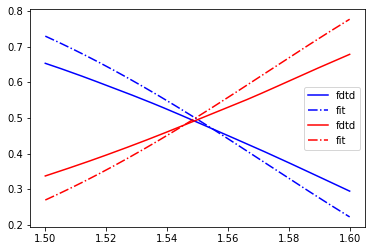

In [52]:
wl = jnp.linspace(1.5, 1.60, 1000)
coupler_fdtd = gs.read.sdict_from_csv(filepath=gf.config.sparameters_path / 'coupler' / 'coupler_G224n_L20_S220.csv',wl=wl, xkey='wavelength_nm', prefix='S', xunits=1e-3)
S = coupler_fdtd
T_fdtd = abs(S['o1', 'o3'])**2
S = gf.simulation.sax.models.coupler(dn=dn_fit,
                                     length=20,
                                     coupling0=coupling0_fit,
                                     dn1=dn1_fit,
                                     dn2=dn2_fit,
                                     dk1=dk1_fit,
                                     dk2=dk2_fit,
                                     wl=wl)
T_model = abs(S['o1', 'o4'])**2
K_model = abs(S['o1', 'o3'])**2

plt.plot(wl, T_fdtd, label='fdtd', c='b')
plt.plot(wl, T_model, label='fit', c='b', ls='-.')
plt.plot(wl, K_fdtd, label='fdtd', c='r')
plt.plot(wl, K_model, label='fit', c='r', ls='-.')
plt.legend()

As you can see trying to fit many parameters do not give you a better fit,

you have to make sure you fit the right parameters, in this case `dn1`

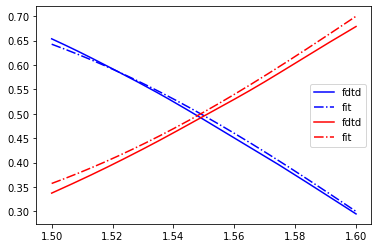

In [53]:
wl = jnp.linspace(1.50, 1.60, 1000)
S = gf.simulation.sax.models.coupler(dn=dn_fit,
                                     length=20,
                                     coupling0=coupling0_fit,
                                     dn1=dn1_fit-0.045,
                                     dn2=dn2_fit,
                                     dk1=dk1_fit,
                                     dk2=dk2_fit,
                                     wl=wl)
T_model = abs(S['o1', 'o4'])**2
K_model = abs(S['o1', 'o3'])**2

plt.plot(wl, T_fdtd, label='fdtd', c='b')
plt.plot(wl, T_model, label='fit', c='b', ls='-.')
plt.plot(wl, K_fdtd, label='fdtd', c='r')
plt.plot(wl, K_model, label='fit', c='r', ls='-.')
plt.legend()

In [54]:
dn = dn_fit
dn2 = dn2_fit
dk1 = dk1_fit
dk2 = dk2_fit

@jax.jit
def loss(dn1):
    """Returns fit least squares error from a coupler model spectrum
    to the FDTD Sparameter spectrum that we want to fit.
    
    """
    S = gf.simulation.sax.models.coupler(dn=dn, length=20, coupling0=coupling0, dn1=dn1, dn2=dn2, dk1=dk1, dk2=dk2)
    T_model = jnp.abs(S['o1', 'o4'])**2
    K_model = jnp.abs(S['o1', 'o3'])**2
    return jnp.abs(T_fdtd-T_model).mean() + jnp.abs(K_fdtd-K_model).mean()

grad = jax.jit(
    jax.grad(
        loss,
        argnums=0,  # JAX gradient function for the first positional argument, jitted
    )
)

dn1 = 0.11
optim_init, optim_update, optim_params = opt.adam(step_size=0.001)
optim_state = optim_init(dn1)


def train_step(step, optim_state):
    settings = optim_params(optim_state)
    lossvalue = loss(settings)
    gradvalue = grad(settings)
    optim_state = optim_update(step, gradvalue, optim_state)
    return lossvalue, optim_state

range_ = tqdm.trange(300)
for step in range_:
    lossvalue, optim_state = train_step(step, optim_state)
    range_.set_postfix(loss=f"{lossvalue:.6f}")

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s, loss=0.177414]

  0%|          | 1/300 [00:00<01:14,  4.03it/s, loss=0.177414]

  0%|          | 1/300 [00:00<01:14,  4.03it/s, loss=0.177414]

  1%|          | 2/300 [00:00<01:13,  4.08it/s, loss=0.177414]

  1%|          | 2/300 [00:00<01:13,  4.08it/s, loss=0.177414]

  1%|          | 2/300 [00:00<01:13,  4.08it/s, loss=0.177414]

  1%|          | 2/300 [00:00<01:13,  4.08it/s, loss=0.177414]

  1%|          | 2/300 [00:00<01:13,  4.08it/s, loss=0.177414]

  1%|          | 2/300 [00:00<01:13,  4.08it/s, loss=0.177414]

  1%|          | 2/300 [00:00<01:13,  4.08it/s, loss=0.177414]

  1%|          | 2/300 [00:00<01:13,  4.08it/s, loss=0.177414]

  1%|          | 2/300 [00:00<01:13,  4.08it/s, loss=0.177414]

  1%|          | 2/300 [00:00<01:13,  4.08it/s, loss=0.177414]

  1%|          | 2/300 [00:00<01:13,  4.08it/s, loss=0.177414]

  1%|          | 2/300 [00:00<01:13,  4.08it/s, loss=0.177414]

  1%|          | 2/300 [00:00<01:13,  4.08it/s, loss=0.177414]

  1%|          | 2/300 [00:00<01:13,  4.08it/s, loss=0.177414]

  1%|          | 2/300 [00:00<01:13,  4.08it/s, loss=0.177414]

  1%|          | 2/300 [00:00<01:13,  4.08it/s, loss=0.177414]

  1%|          | 2/300 [00:00<01:13,  4.08it/s, loss=0.177414]

  1%|          | 2/300 [00:00<01:13,  4.08it/s, loss=0.177414]

  1%|          | 2/300 [00:00<01:13,  4.08it/s, loss=0.177414]

  1%|          | 2/300 [00:00<01:13,  4.08it/s, loss=0.177414]

  1%|          | 2/300 [00:00<01:13,  4.08it/s, loss=0.177414]

  1%|          | 2/300 [00:00<01:13,  4.08it/s, loss=0.177414]

  1%|          | 2/300 [00:00<01:13,  4.08it/s, loss=0.177414]

  1%|          | 2/300 [00:00<01:13,  4.08it/s, loss=0.177414]

  1%|          | 2/300 [00:00<01:13,  4.08it/s, loss=0.177414]

  1%|          | 2/300 [00:00<01:13,  4.08it/s, loss=0.177414]

  1%|          | 2/300 [00:00<01:13,  4.08it/s, loss=0.177414]

  1%|          | 2/300 [00:00<01:13,  4.08it/s, loss=0.177414]

  1%|          | 2/300 [00:00<01:13,  4.08it/s, loss=0.177414]

  1%|          | 2/300 [00:00<01:13,  4.08it/s, loss=0.177414]

  1%|          | 2/300 [00:00<01:13,  4.08it/s, loss=0.177414]

  1%|          | 2/300 [00:00<01:13,  4.08it/s, loss=0.177414]

  1%|          | 2/300 [00:00<01:13,  4.08it/s, loss=0.177414]

  1%|          | 2/300 [00:00<01:13,  4.08it/s, loss=0.177414]

  1%|          | 2/300 [00:00<01:13,  4.08it/s, loss=0.177414]

  1%|          | 2/300 [00:00<01:13,  4.08it/s, loss=0.177414]

  1%|          | 2/300 [00:00<01:13,  4.08it/s, loss=0.177414]

  1%|          | 2/300 [00:00<01:13,  4.08it/s, loss=0.177414]

  1%|          | 2/300 [00:00<01:13,  4.08it/s, loss=0.177414]

  1%|          | 2/300 [00:00<01:13,  4.08it/s, loss=0.177414]

  1%|          | 2/300 [00:00<01:13,  4.08it/s, loss=0.177414]

  1%|          | 2/300 [00:00<01:13,  4.08it/s, loss=0.177414]

  1%|          | 2/300 [00:00<01:13,  4.08it/s, loss=0.177414]

  1%|          | 2/300 [00:00<01:13,  4.08it/s, loss=0.177414]

  1%|          | 2/300 [00:00<01:13,  4.08it/s, loss=0.177414]

  1%|          | 2/300 [00:00<01:13,  4.08it/s, loss=0.177414]

  1%|          | 2/300 [00:00<01:13,  4.08it/s, loss=0.177414]

  1%|          | 2/300 [00:00<01:13,  4.08it/s, loss=0.177414]

  1%|          | 2/300 [00:00<01:13,  4.08it/s, loss=0.177414]

  1%|          | 2/300 [00:00<01:13,  4.08it/s, loss=0.177414]

  1%|          | 2/300 [00:00<01:13,  4.08it/s, loss=0.177414]

  1%|          | 2/300 [00:00<01:13,  4.08it/s, loss=0.177414]

  1%|          | 2/300 [00:00<01:13,  4.08it/s, loss=0.177414]

  1%|          | 2/300 [00:00<01:13,  4.08it/s, loss=0.177414]

  1%|          | 2/300 [00:00<01:13,  4.08it/s, loss=0.177414]

  1%|          | 2/300 [00:00<01:13,  4.08it/s, loss=0.177414]

  1%|          | 2/300 [00:00<01:13,  4.08it/s, loss=0.177414]

 19%|█▉        | 58/300 [00:00<00:01, 145.89it/s, loss=0.177414]

 19%|█▉        | 58/300 [00:00<00:01, 145.89it/s, loss=0.177414]

 19%|█▉        | 58/300 [00:00<00:01, 145.89it/s, loss=0.177414]

 19%|█▉        | 58/300 [00:00<00:01, 145.89it/s, loss=0.177414]

 19%|█▉        | 58/300 [00:00<00:01, 145.89it/s, loss=0.177414]

 19%|█▉        | 58/300 [00:00<00:01, 145.89it/s, loss=0.177414]

 19%|█▉        | 58/300 [00:00<00:01, 145.89it/s, loss=0.177414]

 19%|█▉        | 58/300 [00:00<00:01, 145.89it/s, loss=0.177414]

 19%|█▉        | 58/300 [00:00<00:01, 145.89it/s, loss=0.177414]

 19%|█▉        | 58/300 [00:00<00:01, 145.89it/s, loss=0.177414]

 19%|█▉        | 58/300 [00:00<00:01, 145.89it/s, loss=0.177414]

 19%|█▉        | 58/300 [00:00<00:01, 145.89it/s, loss=0.177414]

 19%|█▉        | 58/300 [00:00<00:01, 145.89it/s, loss=0.177414]

 19%|█▉        | 58/300 [00:00<00:01, 145.89it/s, loss=0.177414]

 19%|█▉        | 58/300 [00:00<00:01, 145.89it/s, loss=0.177414]

 19%|█▉        | 58/300 [00:00<00:01, 145.89it/s, loss=0.177414]

 19%|█▉        | 58/300 [00:00<00:01, 145.89it/s, loss=0.177414]

 19%|█▉        | 58/300 [00:00<00:01, 145.89it/s, loss=0.177414]

 19%|█▉        | 58/300 [00:00<00:01, 145.89it/s, loss=0.177414]

 19%|█▉        | 58/300 [00:00<00:01, 145.89it/s, loss=0.177414]

 19%|█▉        | 58/300 [00:00<00:01, 145.89it/s, loss=0.177414]

 19%|█▉        | 58/300 [00:00<00:01, 145.89it/s, loss=0.177414]

 19%|█▉        | 58/300 [00:00<00:01, 145.89it/s, loss=0.177414]

 19%|█▉        | 58/300 [00:00<00:01, 145.89it/s, loss=0.177414]

 19%|█▉        | 58/300 [00:00<00:01, 145.89it/s, loss=0.177414]

 19%|█▉        | 58/300 [00:00<00:01, 145.89it/s, loss=0.177414]

 19%|█▉        | 58/300 [00:00<00:01, 145.89it/s, loss=0.177414]

 19%|█▉        | 58/300 [00:00<00:01, 145.89it/s, loss=0.177414]

 19%|█▉        | 58/300 [00:00<00:01, 145.89it/s, loss=0.177414]

 19%|█▉        | 58/300 [00:00<00:01, 145.89it/s, loss=0.177414]

 19%|█▉        | 58/300 [00:00<00:01, 145.89it/s, loss=0.177414]

 19%|█▉        | 58/300 [00:00<00:01, 145.89it/s, loss=0.177414]

 19%|█▉        | 58/300 [00:00<00:01, 145.89it/s, loss=0.177414]

 19%|█▉        | 58/300 [00:00<00:01, 145.89it/s, loss=0.177414]

 19%|█▉        | 58/300 [00:00<00:01, 145.89it/s, loss=0.177414]

 19%|█▉        | 58/300 [00:00<00:01, 145.89it/s, loss=0.177414]

 19%|█▉        | 58/300 [00:00<00:01, 145.89it/s, loss=0.177414]

 19%|█▉        | 58/300 [00:00<00:01, 145.89it/s, loss=0.177414]

 19%|█▉        | 58/300 [00:00<00:01, 145.89it/s, loss=0.177414]

 19%|█▉        | 58/300 [00:00<00:01, 145.89it/s, loss=0.177414]

 19%|█▉        | 58/300 [00:00<00:01, 145.89it/s, loss=0.177414]

 19%|█▉        | 58/300 [00:00<00:01, 145.89it/s, loss=0.177414]

 19%|█▉        | 58/300 [00:00<00:01, 145.89it/s, loss=0.177414]

 19%|█▉        | 58/300 [00:00<00:01, 145.89it/s, loss=0.177414]

 19%|█▉        | 58/300 [00:00<00:01, 145.89it/s, loss=0.177414]

 19%|█▉        | 58/300 [00:00<00:01, 145.89it/s, loss=0.177414]

 19%|█▉        | 58/300 [00:00<00:01, 145.89it/s, loss=0.177414]

 19%|█▉        | 58/300 [00:00<00:01, 145.89it/s, loss=0.177414]

 19%|█▉        | 58/300 [00:00<00:01, 145.89it/s, loss=0.177414]

 19%|█▉        | 58/300 [00:00<00:01, 145.89it/s, loss=0.177414]

 19%|█▉        | 58/300 [00:00<00:01, 145.89it/s, loss=0.177414]

 19%|█▉        | 58/300 [00:00<00:01, 145.89it/s, loss=0.177414]

 19%|█▉        | 58/300 [00:00<00:01, 145.89it/s, loss=0.177414]

 19%|█▉        | 58/300 [00:00<00:01, 145.89it/s, loss=0.177414]

 19%|█▉        | 58/300 [00:00<00:01, 145.89it/s, loss=0.177414]

 19%|█▉        | 58/300 [00:00<00:01, 145.89it/s, loss=0.177414]

 19%|█▉        | 58/300 [00:00<00:01, 145.89it/s, loss=0.177414]

 19%|█▉        | 58/300 [00:00<00:01, 145.89it/s, loss=0.177414]

 19%|█▉        | 58/300 [00:00<00:01, 145.89it/s, loss=0.177414]

 19%|█▉        | 58/300 [00:00<00:01, 145.89it/s, loss=0.177414]

 19%|█▉        | 58/300 [00:00<00:01, 145.89it/s, loss=0.177414]

 19%|█▉        | 58/300 [00:00<00:01, 145.89it/s, loss=0.177414]

 19%|█▉        | 58/300 [00:00<00:01, 145.89it/s, loss=0.177414]

 19%|█▉        | 58/300 [00:00<00:01, 145.89it/s, loss=0.177414]

 40%|████      | 121/300 [00:00<00:00, 274.01it/s, loss=0.177414]

 40%|████      | 121/300 [00:00<00:00, 274.01it/s, loss=0.177414]

 40%|████      | 121/300 [00:00<00:00, 274.01it/s, loss=0.177414]

 40%|████      | 121/300 [00:00<00:00, 274.01it/s, loss=0.177414]

 40%|████      | 121/300 [00:00<00:00, 274.01it/s, loss=0.177414]

 40%|████      | 121/300 [00:00<00:00, 274.01it/s, loss=0.177414]

 40%|████      | 121/300 [00:00<00:00, 274.01it/s, loss=0.177414]

 40%|████      | 121/300 [00:00<00:00, 274.01it/s, loss=0.177414]

 40%|████      | 121/300 [00:00<00:00, 274.01it/s, loss=0.177414]

 40%|████      | 121/300 [00:00<00:00, 274.01it/s, loss=0.177414]

 40%|████      | 121/300 [00:00<00:00, 274.01it/s, loss=0.177414]

 40%|████      | 121/300 [00:00<00:00, 274.01it/s, loss=0.177414]

 40%|████      | 121/300 [00:00<00:00, 274.01it/s, loss=0.177414]

 40%|████      | 121/300 [00:00<00:00, 274.01it/s, loss=0.177414]

 40%|████      | 121/300 [00:00<00:00, 274.01it/s, loss=0.177414]

 40%|████      | 121/300 [00:00<00:00, 274.01it/s, loss=0.177414]

 40%|████      | 121/300 [00:00<00:00, 274.01it/s, loss=0.177414]

 40%|████      | 121/300 [00:00<00:00, 274.01it/s, loss=0.177414]

 40%|████      | 121/300 [00:00<00:00, 274.01it/s, loss=0.177414]

 40%|████      | 121/300 [00:00<00:00, 274.01it/s, loss=0.177414]

 40%|████      | 121/300 [00:00<00:00, 274.01it/s, loss=0.177414]

 40%|████      | 121/300 [00:00<00:00, 274.01it/s, loss=0.177414]

 40%|████      | 121/300 [00:00<00:00, 274.01it/s, loss=0.177414]

 40%|████      | 121/300 [00:00<00:00, 274.01it/s, loss=0.177414]

 40%|████      | 121/300 [00:00<00:00, 274.01it/s, loss=0.177414]

 40%|████      | 121/300 [00:00<00:00, 274.01it/s, loss=0.177414]

 40%|████      | 121/300 [00:00<00:00, 274.01it/s, loss=0.177414]

 40%|████      | 121/300 [00:00<00:00, 274.01it/s, loss=0.177414]

 40%|████      | 121/300 [00:00<00:00, 274.01it/s, loss=0.177414]

 40%|████      | 121/300 [00:00<00:00, 274.01it/s, loss=0.177414]

 40%|████      | 121/300 [00:00<00:00, 274.01it/s, loss=0.177414]

 40%|████      | 121/300 [00:00<00:00, 274.01it/s, loss=0.177414]

 40%|████      | 121/300 [00:00<00:00, 274.01it/s, loss=0.177414]

 40%|████      | 121/300 [00:00<00:00, 274.01it/s, loss=0.177414]

 40%|████      | 121/300 [00:00<00:00, 274.01it/s, loss=0.177414]

 40%|████      | 121/300 [00:00<00:00, 274.01it/s, loss=0.177414]

 40%|████      | 121/300 [00:00<00:00, 274.01it/s, loss=0.177414]

 40%|████      | 121/300 [00:00<00:00, 274.01it/s, loss=0.177414]

 40%|████      | 121/300 [00:00<00:00, 274.01it/s, loss=0.177414]

 40%|████      | 121/300 [00:00<00:00, 274.01it/s, loss=0.177414]

 40%|████      | 121/300 [00:00<00:00, 274.01it/s, loss=0.177414]

 40%|████      | 121/300 [00:00<00:00, 274.01it/s, loss=0.177414]

 40%|████      | 121/300 [00:00<00:00, 274.01it/s, loss=0.177414]

 40%|████      | 121/300 [00:00<00:00, 274.01it/s, loss=0.177414]

 40%|████      | 121/300 [00:00<00:00, 274.01it/s, loss=0.177414]

 40%|████      | 121/300 [00:00<00:00, 274.01it/s, loss=0.177414]

 40%|████      | 121/300 [00:00<00:00, 274.01it/s, loss=0.177414]

 40%|████      | 121/300 [00:00<00:00, 274.01it/s, loss=0.177414]

 40%|████      | 121/300 [00:00<00:00, 274.01it/s, loss=0.177414]

 40%|████      | 121/300 [00:00<00:00, 274.01it/s, loss=0.177414]

 40%|████      | 121/300 [00:00<00:00, 274.01it/s, loss=0.177414]

 40%|████      | 121/300 [00:00<00:00, 274.01it/s, loss=0.177414]

 40%|████      | 121/300 [00:00<00:00, 274.01it/s, loss=0.177414]

 40%|████      | 121/300 [00:00<00:00, 274.01it/s, loss=0.177414]

 40%|████      | 121/300 [00:00<00:00, 274.01it/s, loss=0.177414]

 40%|████      | 121/300 [00:00<00:00, 274.01it/s, loss=0.177414]

 40%|████      | 121/300 [00:00<00:00, 274.01it/s, loss=0.177414]

 40%|████      | 121/300 [00:00<00:00, 274.01it/s, loss=0.177414]

 40%|████      | 121/300 [00:00<00:00, 274.01it/s, loss=0.177414]

 40%|████      | 121/300 [00:00<00:00, 274.01it/s, loss=0.177414]

 40%|████      | 121/300 [00:00<00:00, 274.01it/s, loss=0.177414]

 40%|████      | 121/300 [00:00<00:00, 274.01it/s, loss=0.177414]

 40%|████      | 121/300 [00:00<00:00, 274.01it/s, loss=0.177414]

 40%|████      | 121/300 [00:00<00:00, 274.01it/s, loss=0.177414]

 40%|████      | 121/300 [00:00<00:00, 274.01it/s, loss=0.177414]

 62%|██████▏   | 185/300 [00:00<00:00, 374.53it/s, loss=0.177414]

 62%|██████▏   | 185/300 [00:00<00:00, 374.53it/s, loss=0.177414]

 62%|██████▏   | 185/300 [00:00<00:00, 374.53it/s, loss=0.177414]

 62%|██████▏   | 185/300 [00:00<00:00, 374.53it/s, loss=0.177414]

 62%|██████▏   | 185/300 [00:00<00:00, 374.53it/s, loss=0.177414]

 62%|██████▏   | 185/300 [00:00<00:00, 374.53it/s, loss=0.177414]

 62%|██████▏   | 185/300 [00:00<00:00, 374.53it/s, loss=0.177414]

 62%|██████▏   | 185/300 [00:00<00:00, 374.53it/s, loss=0.177414]

 62%|██████▏   | 185/300 [00:00<00:00, 374.53it/s, loss=0.177414]

 62%|██████▏   | 185/300 [00:00<00:00, 374.53it/s, loss=0.177414]

 62%|██████▏   | 185/300 [00:00<00:00, 374.53it/s, loss=0.177414]

 62%|██████▏   | 185/300 [00:00<00:00, 374.53it/s, loss=0.177414]

 62%|██████▏   | 185/300 [00:00<00:00, 374.53it/s, loss=0.177414]

 62%|██████▏   | 185/300 [00:00<00:00, 374.53it/s, loss=0.177414]

 62%|██████▏   | 185/300 [00:00<00:00, 374.53it/s, loss=0.177414]

 62%|██████▏   | 185/300 [00:00<00:00, 374.53it/s, loss=0.177414]

 62%|██████▏   | 185/300 [00:00<00:00, 374.53it/s, loss=0.177414]

 62%|██████▏   | 185/300 [00:00<00:00, 374.53it/s, loss=0.177414]

 62%|██████▏   | 185/300 [00:00<00:00, 374.53it/s, loss=0.177414]

 62%|██████▏   | 185/300 [00:00<00:00, 374.53it/s, loss=0.177414]

 62%|██████▏   | 185/300 [00:00<00:00, 374.53it/s, loss=0.177414]

 62%|██████▏   | 185/300 [00:00<00:00, 374.53it/s, loss=0.177414]

 62%|██████▏   | 185/300 [00:00<00:00, 374.53it/s, loss=0.177414]

 62%|██████▏   | 185/300 [00:00<00:00, 374.53it/s, loss=0.177414]

 62%|██████▏   | 185/300 [00:00<00:00, 374.53it/s, loss=0.177414]

 62%|██████▏   | 185/300 [00:00<00:00, 374.53it/s, loss=0.177414]

 62%|██████▏   | 185/300 [00:00<00:00, 374.53it/s, loss=0.177414]

 62%|██████▏   | 185/300 [00:00<00:00, 374.53it/s, loss=0.177414]

 62%|██████▏   | 185/300 [00:00<00:00, 374.53it/s, loss=0.177414]

 62%|██████▏   | 185/300 [00:00<00:00, 374.53it/s, loss=0.177414]

 62%|██████▏   | 185/300 [00:00<00:00, 374.53it/s, loss=0.177414]

 62%|██████▏   | 185/300 [00:00<00:00, 374.53it/s, loss=0.177414]

 62%|██████▏   | 185/300 [00:00<00:00, 374.53it/s, loss=0.177414]

 62%|██████▏   | 185/300 [00:00<00:00, 374.53it/s, loss=0.177414]

 62%|██████▏   | 185/300 [00:00<00:00, 374.53it/s, loss=0.177414]

 62%|██████▏   | 185/300 [00:00<00:00, 374.53it/s, loss=0.177414]

 62%|██████▏   | 185/300 [00:00<00:00, 374.53it/s, loss=0.177414]

 62%|██████▏   | 185/300 [00:00<00:00, 374.53it/s, loss=0.177414]

 62%|██████▏   | 185/300 [00:00<00:00, 374.53it/s, loss=0.177414]

 62%|██████▏   | 185/300 [00:00<00:00, 374.53it/s, loss=0.177414]

 62%|██████▏   | 185/300 [00:00<00:00, 374.53it/s, loss=0.177414]

 62%|██████▏   | 185/300 [00:00<00:00, 374.53it/s, loss=0.177414]

 62%|██████▏   | 185/300 [00:00<00:00, 374.53it/s, loss=0.177414]

 62%|██████▏   | 185/300 [00:00<00:00, 374.53it/s, loss=0.177414]

 62%|██████▏   | 185/300 [00:00<00:00, 374.53it/s, loss=0.177414]

 62%|██████▏   | 185/300 [00:00<00:00, 374.53it/s, loss=0.177414]

 62%|██████▏   | 185/300 [00:00<00:00, 374.53it/s, loss=0.177414]

 62%|██████▏   | 185/300 [00:00<00:00, 374.53it/s, loss=0.177414]

 62%|██████▏   | 185/300 [00:00<00:00, 374.53it/s, loss=0.177414]

 62%|██████▏   | 185/300 [00:00<00:00, 374.53it/s, loss=0.177414]

 62%|██████▏   | 185/300 [00:00<00:00, 374.53it/s, loss=0.177414]

 62%|██████▏   | 185/300 [00:00<00:00, 374.53it/s, loss=0.177414]

 62%|██████▏   | 185/300 [00:00<00:00, 374.53it/s, loss=0.177414]

 62%|██████▏   | 185/300 [00:00<00:00, 374.53it/s, loss=0.177414]

 62%|██████▏   | 185/300 [00:00<00:00, 374.53it/s, loss=0.177414]

 62%|██████▏   | 185/300 [00:00<00:00, 374.53it/s, loss=0.177414]

 62%|██████▏   | 185/300 [00:00<00:00, 374.53it/s, loss=0.177414]

 62%|██████▏   | 185/300 [00:00<00:00, 374.53it/s, loss=0.177414]

 62%|██████▏   | 185/300 [00:00<00:00, 374.53it/s, loss=0.177414]

 62%|██████▏   | 185/300 [00:00<00:00, 374.53it/s, loss=0.177414]

 62%|██████▏   | 185/300 [00:00<00:00, 374.53it/s, loss=0.177414]

 62%|██████▏   | 185/300 [00:00<00:00, 374.53it/s, loss=0.177414]

 62%|██████▏   | 185/300 [00:00<00:00, 374.53it/s, loss=0.177414]

 62%|██████▏   | 185/300 [00:00<00:00, 374.53it/s, loss=0.177414]

 62%|██████▏   | 185/300 [00:00<00:00, 374.53it/s, loss=0.177414]

 83%|████████▎ | 249/300 [00:00<00:00, 448.03it/s, loss=0.177414]

 83%|████████▎ | 249/300 [00:00<00:00, 448.03it/s, loss=0.177414]

 83%|████████▎ | 249/300 [00:00<00:00, 448.03it/s, loss=0.177414]

 83%|████████▎ | 249/300 [00:00<00:00, 448.03it/s, loss=0.177414]

 83%|████████▎ | 249/300 [00:00<00:00, 448.03it/s, loss=0.177414]

 83%|████████▎ | 249/300 [00:00<00:00, 448.03it/s, loss=0.177414]

 83%|████████▎ | 249/300 [00:00<00:00, 448.03it/s, loss=0.177414]

 83%|████████▎ | 249/300 [00:00<00:00, 448.03it/s, loss=0.177414]

 83%|████████▎ | 249/300 [00:00<00:00, 448.03it/s, loss=0.177414]

 83%|████████▎ | 249/300 [00:00<00:00, 448.03it/s, loss=0.177414]

 83%|████████▎ | 249/300 [00:00<00:00, 448.03it/s, loss=0.177414]

 83%|████████▎ | 249/300 [00:00<00:00, 448.03it/s, loss=0.177414]

 83%|████████▎ | 249/300 [00:00<00:00, 448.03it/s, loss=0.177414]

 83%|████████▎ | 249/300 [00:00<00:00, 448.03it/s, loss=0.177414]

 83%|████████▎ | 249/300 [00:00<00:00, 448.03it/s, loss=0.177414]

 83%|████████▎ | 249/300 [00:00<00:00, 448.03it/s, loss=0.177414]

 83%|████████▎ | 249/300 [00:00<00:00, 448.03it/s, loss=0.177414]

 83%|████████▎ | 249/300 [00:00<00:00, 448.03it/s, loss=0.177414]

 83%|████████▎ | 249/300 [00:00<00:00, 448.03it/s, loss=0.177414]

 83%|████████▎ | 249/300 [00:00<00:00, 448.03it/s, loss=0.177414]

 83%|████████▎ | 249/300 [00:00<00:00, 448.03it/s, loss=0.177414]

 83%|████████▎ | 249/300 [00:00<00:00, 448.03it/s, loss=0.177414]

 83%|████████▎ | 249/300 [00:00<00:00, 448.03it/s, loss=0.177414]

 83%|████████▎ | 249/300 [00:00<00:00, 448.03it/s, loss=0.177414]

 83%|████████▎ | 249/300 [00:00<00:00, 448.03it/s, loss=0.177414]

 83%|████████▎ | 249/300 [00:00<00:00, 448.03it/s, loss=0.177414]

 83%|████████▎ | 249/300 [00:00<00:00, 448.03it/s, loss=0.177414]

 83%|████████▎ | 249/300 [00:00<00:00, 448.03it/s, loss=0.177414]

 83%|████████▎ | 249/300 [00:00<00:00, 448.03it/s, loss=0.177414]

 83%|████████▎ | 249/300 [00:00<00:00, 448.03it/s, loss=0.177414]

 83%|████████▎ | 249/300 [00:00<00:00, 448.03it/s, loss=0.177414]

 83%|████████▎ | 249/300 [00:00<00:00, 448.03it/s, loss=0.177414]

 83%|████████▎ | 249/300 [00:00<00:00, 448.03it/s, loss=0.177414]

 83%|████████▎ | 249/300 [00:00<00:00, 448.03it/s, loss=0.177414]

 83%|████████▎ | 249/300 [00:00<00:00, 448.03it/s, loss=0.177414]

 83%|████████▎ | 249/300 [00:00<00:00, 448.03it/s, loss=0.177414]

 83%|████████▎ | 249/300 [00:00<00:00, 448.03it/s, loss=0.177414]

 83%|████████▎ | 249/300 [00:00<00:00, 448.03it/s, loss=0.177414]

 83%|████████▎ | 249/300 [00:00<00:00, 448.03it/s, loss=0.177414]

 83%|████████▎ | 249/300 [00:00<00:00, 448.03it/s, loss=0.177414]

 83%|████████▎ | 249/300 [00:00<00:00, 448.03it/s, loss=0.177414]

 83%|████████▎ | 249/300 [00:00<00:00, 448.03it/s, loss=0.177414]

 83%|████████▎ | 249/300 [00:00<00:00, 448.03it/s, loss=0.177414]

 83%|████████▎ | 249/300 [00:00<00:00, 448.03it/s, loss=0.177414]

 83%|████████▎ | 249/300 [00:00<00:00, 448.03it/s, loss=0.177414]

 83%|████████▎ | 249/300 [00:00<00:00, 448.03it/s, loss=0.177414]

 83%|████████▎ | 249/300 [00:00<00:00, 448.03it/s, loss=0.177414]

 83%|████████▎ | 249/300 [00:00<00:00, 448.03it/s, loss=0.177414]

 83%|████████▎ | 249/300 [00:00<00:00, 448.03it/s, loss=0.177414]

 83%|████████▎ | 249/300 [00:00<00:00, 448.03it/s, loss=0.177414]

 83%|████████▎ | 249/300 [00:00<00:00, 448.03it/s, loss=0.177414]

 83%|████████▎ | 249/300 [00:00<00:00, 448.03it/s, loss=0.177414]

100%|██████████| 300/300 [00:00<00:00, 307.43it/s, loss=0.177414]

In [55]:
dn1_fit = optim_params(optim_state)
dn1_fit

0.11

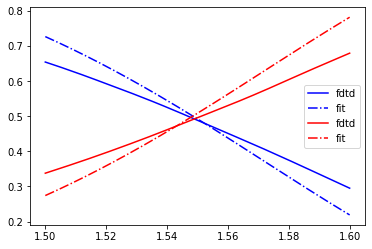

In [56]:
wl = jnp.linspace(1.50, 1.60, 1000)
S = gf.simulation.sax.models.coupler(dn=dn,
                                     length=20,
                                     coupling0=coupling0,
                                     dn1=dn1_fit,
                                     dn2=dn2,
                                     dk1=dk1,
                                     dk2=dk2,
                                     wl=wl)
T_model = abs(S['o1', 'o4'])**2
K_model = abs(S['o1', 'o3'])**2

coupler_fdtd = gs.read.sdict_from_csv(filepath=gf.config.sparameters_path / 'coupler' / 'coupler_G224n_L20_S220.csv', xkey='wavelength_nm', prefix='S', xunits=1e-3, wl=wl)
S = coupler_fdtd
T_fdtd = abs(S['o1', 'o3'])**2
K_fdtd = abs(S['o1', 'o4'])**2

plt.plot(wl, T_fdtd, label='fdtd', c='b')
plt.plot(wl, T_model, label='fit', c='b', ls='-.')
plt.plot(wl, K_fdtd, label='fdtd', c='r')
plt.plot(wl, K_model, label='fit', c='r', ls='-.')
plt.legend()

## Model fit (linear regression)

For a better fit of the coupler we can build a linear regression model of the coupler with `sklearn`

In [57]:
import sax
import gdsfactory as gf
import gdsfactory.simulation.sax as gs
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from scipy.constants import c
from sklearn.linear_model import LinearRegression

In [58]:
f = jnp.linspace(c / 1.0e-6, c / 2.0e-6, 500) * 1e-12  # THz
wl = c / (f * 1e12) * 1e6  # um

filepath = gf.config.sparameters_path / "coupler" / "coupler_G224n_L20_S220.csv"
coupler_fdtd = gf.partial(gs.read.sdict_from_csv, filepath, xkey="wavelength_nm", prefix="S", xunits=1e-3)
sd = coupler_fdtd(wl=wl)

k = sd["o1", "o3"]
t = sd["o1", "o4"]
s = t + k
a = t - k

Lets fit the symmetric (t+k) and antisymmetric (t-k) transmission

### Symmetric

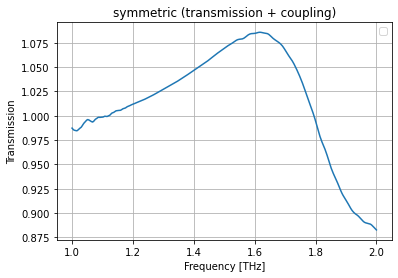

In [59]:
plt.plot(wl, jnp.abs(s))
plt.grid(True)
plt.xlabel("Frequency [THz]")
plt.ylabel("Transmission")
plt.title('symmetric (transmission + coupling)')
plt.legend()
plt.show()

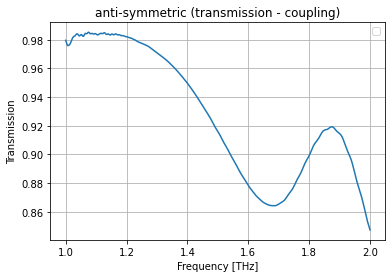

In [60]:
plt.plot(wl, jnp.abs(a))
plt.grid(True)
plt.xlabel("Frequency [THz]")
plt.ylabel("Transmission")
plt.title('anti-symmetric (transmission - coupling)')
plt.legend()
plt.show()

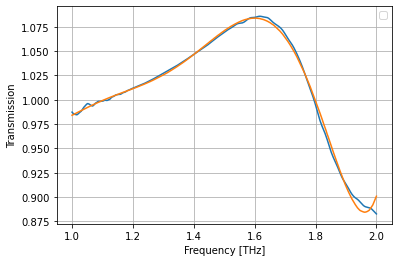

In [61]:
r = LinearRegression()
fX = lambda x, _order=8: x[:,None]**(jnp.arange(_order)[None, :]) # artificially create more 'features' (wl**2, wl**3, wl**4, ...)
X = fX(wl)
r.fit(X, jnp.abs(s))
asm, bsm = r.coef_, r.intercept_
fsm = lambda x: fX(x)@asm + bsm  # fit symmetric module fiir

plt.plot(wl, jnp.abs(s))
plt.plot(wl, fsm(wl))
plt.grid(True)
plt.xlabel("Frequency [THz]")
plt.ylabel("Transmission")
plt.legend()
plt.show()

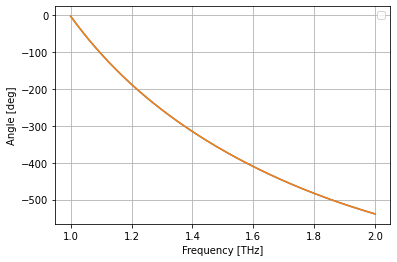

In [62]:
r = LinearRegression()
r.fit(X, jnp.unwrap(jnp.angle(s)))
asp, bsp = r.coef_, r.intercept_
fsp = lambda x: fX(x)@asp + bsp # fit symmetric phase

plt.plot(wl, jnp.unwrap(jnp.angle(s)))
plt.plot(wl, fsp(wl))
plt.grid(True)
plt.xlabel("Frequency [THz]")
plt.ylabel("Angle [deg]")
plt.legend()
plt.show()

In [63]:
fs = lambda x: fsm(x)*jnp.exp(1j*fsp(x))

Lets fit the symmetric (t+k) and antisymmetric (t-k) transmission

### Anti-Symmetric

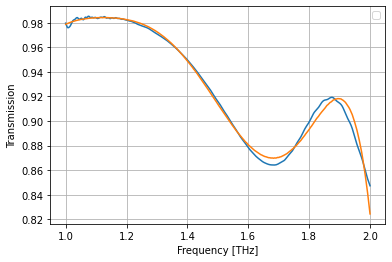

In [64]:
r = LinearRegression()
r.fit(X, jnp.abs(a))
aam, bam = r.coef_, r.intercept_
fam = lambda x: fX(x)@aam + bam

plt.plot(wl, jnp.abs(a))
plt.plot(wl, fam(wl))
plt.grid(True)
plt.xlabel("Frequency [THz]")
plt.ylabel("Transmission")
plt.legend()
plt.show()

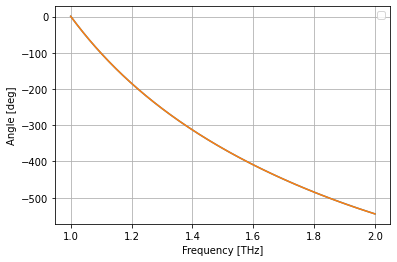

In [65]:
r = LinearRegression()
r.fit(X, jnp.unwrap(jnp.angle(a)))
aap, bap = r.coef_, r.intercept_
fap = lambda x: fX(x)@aap + bap

plt.plot(wl, jnp.unwrap(jnp.angle(a)))
plt.plot(wl, fap(wl))
plt.grid(True)
plt.xlabel("Frequency [THz]")
plt.ylabel("Angle [deg]")
plt.legend()
plt.show()

In [66]:
fa = lambda x: fam(x)*jnp.exp(1j*fap(x))

### Total

Text(0, 0.5, 'Transmission')

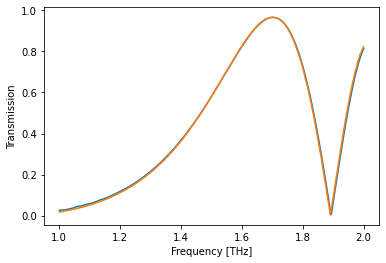

In [67]:
t_ = 0.5 * (fs(wl) + fa(wl))

plt.plot(wl, jnp.abs(t))
plt.plot(wl, jnp.abs(t_))
plt.xlabel("Frequency [THz]")
plt.ylabel("Transmission")

Text(0, 0.5, 'Coupling')

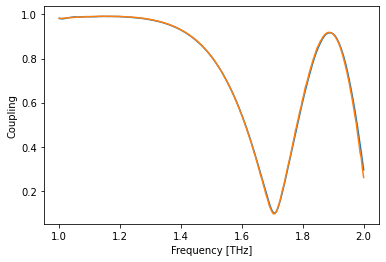

In [68]:
k_ = 0.5 * (fs(wl) - fa(wl))

plt.plot(wl, jnp.abs(k))
plt.plot(wl, jnp.abs(k_))
plt.xlabel("Frequency [THz]")
plt.ylabel("Coupling")

In [69]:
@jax.jit
def coupler(wl=1.5):
    wl = jnp.asarray(wl)
    wl_shape = wl.shape
    wl = wl.ravel()
    t = (0.5 * (fs(wl) + fa(wl))).reshape(*wl_shape)
    k = (0.5 * (fs(wl) - fa(wl))).reshape(*wl_shape)
    sdict = {
        ("o1", "o4"): t,
        ("o1", "o3"): k,
        ("o2", "o3"): k,
        ("o2", "o4"): t,
    }
    return sax.reciprocal(sdict)

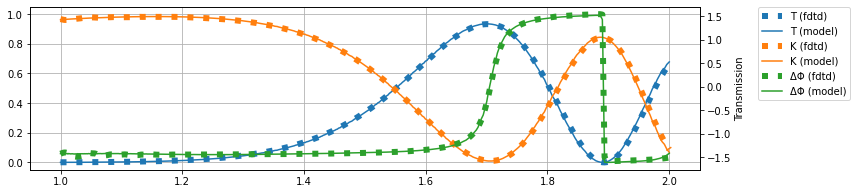

In [70]:
f = jnp.linspace(c / 1.0e-6, c / 2.0e-6, 500) * 1e-12  # THz
wl = c / (f * 1e12) * 1e6  # um

filepath = gf.config.sparameters_path / "coupler" / "coupler_G224n_L20_S220.csv"
coupler_fdtd = gf.partial(gs.read.sdict_from_csv, filepath, xkey="wavelength_nm", prefix="S", xunits=1e-3)
sd = coupler_fdtd(wl=wl)
sd_ = coupler(wl=wl)

T = jnp.abs(sd["o1", "o4"]) ** 2
K = jnp.abs(sd["o1", "o3"]) ** 2
T_ = jnp.abs(sd_["o1", "o4"]) ** 2
K_ = jnp.abs(sd_["o1", "o3"]) ** 2
dP = jnp.unwrap(jnp.angle(sd["o1", "o3"]) - jnp.angle(sd["o1", "o4"]))
dP_ = jnp.unwrap(jnp.angle(sd_["o1", "o3"]) - jnp.angle(sd_["o1", "o4"]))

plt.figure(figsize=(12,3))
plt.plot(wl, T, label="T (fdtd)", c="C0", ls=":", lw="6")
plt.plot(wl, T_, label="T (model)", c="C0")

plt.plot(wl, K, label="K (fdtd)", c="C1", ls=":", lw="6")
plt.plot(wl, K_, label="K (model)", c="C1")

plt.ylim(-0.05, 1.05)
plt.grid(True)

plt.twinx()
plt.plot(wl, dP, label="ΔΦ (fdtd)", color="C2", ls=":", lw="6")
plt.plot(wl, dP_, label="ΔΦ (model)", color="C2")

plt.xlabel("Frequency [THz]")
plt.ylabel("Transmission")
plt.figlegend(bbox_to_anchor=(1.08, 0.9))
plt.savefig("fdtd_vs_model.png", bbox_inches="tight")
plt.show()